<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Total/Total_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "fp.pa"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  38.33  41.00  38.33  41.00      22.82   4915721
2009-01-05  41.68  41.94  40.80  41.70      23.21   7682205
2009-01-06  42.00  42.47  41.35  41.79      23.26   6895659
2009-01-07  41.50  42.10  39.65  40.23      22.40   8883686
2009-01-08  39.78  40.89  39.76  40.67      22.64   5684233
...           ...    ...    ...    ...        ...       ...
2018-12-21  45.90  46.04  45.08  46.04      44.88  13466599
2018-12-24  45.98  46.04  45.23  45.23      44.08   1570694
2018-12-27  46.19  46.19  44.78  45.35      44.20   7100931
2018-12-28  45.56  46.51  45.53  46.08      44.92   5778811
2018-12-31  46.59  46.76  46.16  46.18      45.01   2060626

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     42.950051    43.360082    42.517484    42.948345    32.479288  6.223205e+06
std       4.795083     4.792373     4.827171     4.811741     8.294164  2.970581e+06
min      30.250000    30.880000    29.400000    30.380000    19.230000  0.000000e+00
25%      39.240000    39.600000    38.760000    39.190000    25.035000  4.509666e+06
50%      42.565000    42.980000    42.190000    42.600000    32.110000  5.697930e+06
75%      46.280000    46.670000    45.920000    46.290000    38.292500  7.199009e+06
max      56.380000    56.820000    56.070000    56.370000    54.220000  5.608253e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  38.22  39.03  37.59  37.88      21.09   7954834   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  37.197134  37.021354  34.652873  37.409714  37.267688  36.929432      36.725      36.875  35.158751  36.99875  37.894944  36.8595  37.264444  36.99875  37.756667  37.468865               38.812322                 36.99875               35.185178               39.719108                 36.99875               34.278392               40.625894                 36.99875               33.371606               41.532680                 36.99875               32.464820  37.267688  37.676417  37.298512               39.081260                37.267688               35.454116               39.988046                37.267688               34.547330               40.894832                37.267688               33.640544               41.801618                37.267688   
2009-03-16  38.41  38.62  37.63  38.18      21.25   7645356   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  37.688567  37.188157  34.915501  37.738573  37.470424  36.952167      36.875      36.875  35.468451  37.06750  38.214068  37.1740  37.526944  37.06750  38.030000  37.409623               39.008782                 37.06750               35.126218               39.979423                 37.06750               34.155577               40.950064                 37.06750               33.184936               41.920704                 37.06750               32.214296  37.470424  38.052488  37.265215               39.411706                37.470424               35.529142               40.382347                37.470424               34.558501               41.352988                37.470424               33.587861               42.323629                37.470424   
2009-03-17  37.87  38.00  37.00  37.83   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     43.035527    43.440471    42.610686    43.034497    32.698240  6.170025e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    43.010327    42.975939     2.425310    43.035411    43.021643    43.035280    42.993992    42.962526    42.858104    43.022243    43.035154    43.022409    43.026478    43.022243    43.031276    42.993850               44.218162                43.022243               41.826323               44.816122                43.022243               41.228363               45.414082                43.022243               40.630403               46.012042                43.022243               40.032443    43.021643    43.031730    42.998017               44.217563                43.021643               41.825724               44.815523                43.021643               41.227764               45.413483   
std       4.796887     4.799602     4.821962     4.812734     8.227514  2.955194e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     4.760152     4.677227    43.108486     4.824086     4.748730     4.725051     4.772268     4.774997     4.907993     4.769118     4.823099     4.779243     4.774998     4.769118     4.800843     4.700326                4.810927                 4.769118                4.810003                4.862339                 4.769118                4.860968                4.933327                 4.769118                4.931525                5.023059                 4.769118                5.020847     4.748730     4.793897     4.710268                4.791877                 4.748730                4.788627                4.844066                 4.748730                4.839243                4.915883   
min      30.250000    30.880000    29.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.305013  0.314187  0.307087  0.288573   0.044143   7954834   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.237407  0.210447  0.815870  0.247599  0.230256  0.185509    0.209278    0.226545  0.210020  0.211478  0.273659  0.215784  0.232469  0.211478  0.278156  0.223859                0.224500                 0.211478                0.205534                0.239435                 0.211478                0.205870                0.251928                 0.211478                0.225273                0.262783                 0.211478                0.242773  0.230256  0.267392  0.217294                0.235586                 0.230256                0.226328                0.245746                 0.230256                0.224522                0.255633                 0.230256                0.241720                0.267382                 0.230256   
2009-03-16  0.312285  0.298381  0.308586  0.300115   0.048759   7645356   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.257483  0.217802  0.818213  0.260601  0.238646  0.186487    0.215464    0.226545  0.221315  0.214334  0.286134  0.228622  0.243166  0.214334  0.288802  0.221259                0.232776                 0.214334                0.203211                0.250163                 0.214334                0.201172                0.264825                 0.214334                0.218499                0.277659                 0.214334                0.234128  0.238646  0.282251  0.215842                0.249638                 0.238646                0.229262                0.261991                 0.238646                0.224947                0.273930                 0.238646                0.239815                0.287542                 0.238646   
2009-03-17  0.291619  0.274480  0.284964  0.2866

140176

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 hours 34 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_5y448z
H2O cluster total nodes:    1
H2O cluster free memory:    8.47 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.734456  0.633527              0.383153  0.471258  0.222084
1  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.715257  0.657302              0.333980  0.483518  0.233790
2  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.699873  0.870837              0.392975  0.509147  0.259230
3  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.697584  0.656635              0.343961  0.485588  0.235795
4  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.693007  0.949507              0.437730  0.542032  0.293798
5  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.674317  0.849447              0.402384  0.515860  0.266112
6  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.672282  0.657559              0.407088  0.482819  0.233114
7  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.629371  0.693004              0.495868  0.499594  0.249594
8  DeepLearning_grid_1_AutoML_20190827_174548_mod...  0.627654  7.018139              0.445423  0.669119  0.447720
9              DeepLearning_1_AutoML_20190827_174548  0.566624  1.417143              0.491736  0.516051  0.266309

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006593
1           CDLCLOSINGMARUBOZU             0.997135           0.997135    0.006574
2                  CDLLONGLINE             0.828219           0.828219    0.005460
3                          SUB             0.804263           0.804263    0.005302
4                          DIV             0.714334           0.714334    0.004710
...                        ...                  ...                ...         ...
1034  BBANDS_middleband_20_7_4             0.108561           0.108561    0.000716
1035                    SMA_12             0.108244           0.108244    0.000714
1036               MIDPRICE_20             0.108185           0.108185    0.000713
1037          CDLCOUNTERATTACK             0.099497           0.099497    0.000656
1038       CDLXSIDEGAP3METHODS             0.098144           0.098144    0.000647

[1039 rows x 4 columns]

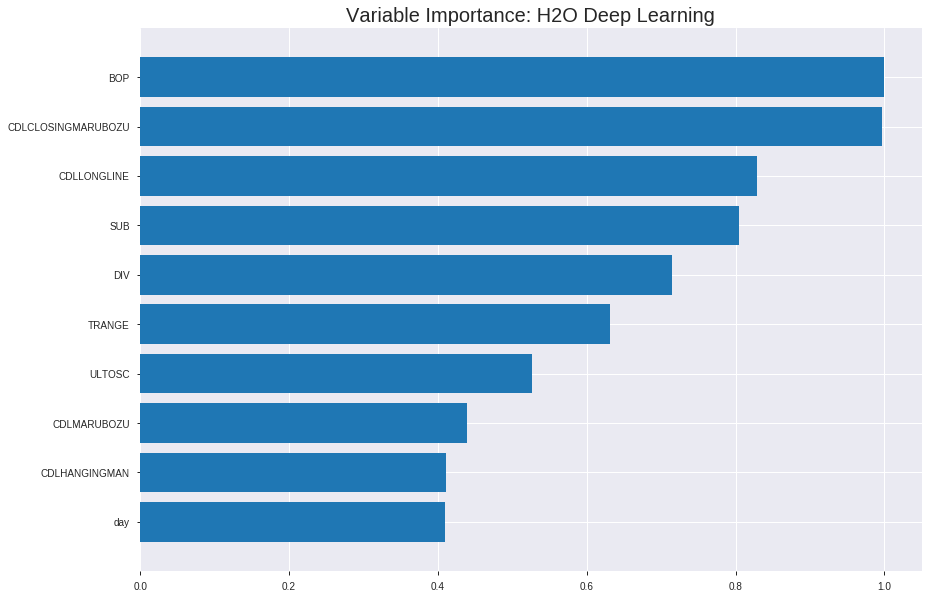

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_174548_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19660737535075973
RMSE: 0.44340430235932504
LogLoss: 0.577610605468965
Mean Per-Class Error: 0.2863304825041433
AUC: 0.7791337023254845
pr_auc: 0.768255832962938
Gini: 0.558267404650969
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43759375531841266: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      414  435   0.5124   (435.0/849.0)
1      96   808   0.1062   (96.0/904.0)
Total  510  1243  0.3029   (531.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437594     0.752678  244
max f2                       0.232257     0.853542  341
max f0point5                 0.586052     0.720409  150
max accuracy                 0.520373     0.714775  193
max precision                0.943363     1         0
max recall                   0.135964     1         374
max specificity              0.943363     1         0
max absolute_mcc             0.505768     0.428724  202
max min_per_class_accuracy   0.53459      0.707892  183
max mean_per_class_accuracy  0.520373     0.71367   193

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 52.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.874603           1.61597   1.61597            0.833333         0.894816  0.833333                    0.894816            0.0165929       0.0165929                  61.5966    61.5966
    2        0.0205362                   0.851313           1.61597   1.61597            0.833333         0.863243  0.833333                    0.879029            0.0165929       0.0331858                  61.5966    61.5966
    3        0.0302339                   0.823114           1.82509   1.68304            0.941176         0.834447  0.867925                    0.86473             0.0176991       0.050885                   82.5091    68.3044
    4        0.040502                    0.800398           1.83143   1.72066            0.944444         0.811071  0.887324                    0.851126            0.0188053       0.0696903                  83.1428    72.0662
    5        0.0501997                   0.7846             1.82509   1.74084            0.941176         0.794311  0.897727                    0.840151            0.0176991       0.0873894                  82.5091    74.0836
    6        0.100399                    0.741332           1.67473   1.70778            0.863636         0.760116  0.880682                    0.800133            0.0840708       0.17146                    67.4728    70.7782
    7        0.150029                    0.707306           1.47109   1.62948            0.758621         0.723729  0.840304                    0.774859            0.0730088       0.244469                   47.1086    62.9484
    8        0.200228                    0.67737            1.52048   1.60215            0.784091         0.692015  0.826211                    0.754089            0.0763274       0.320796                   52.0477    60.2154
    9        0.300057                    0.625098           1.42944   1.54469            0.737143         0.651764  0.796578                    0.720046            0.142699        0.463496                   42.9437    54.4692
    10       0.399886                    0.581504           1.24106   1.46889            0.64             0.602112  0.757489                    0.690604            0.123894        0.587389                   24.1062    46.8892
    11       0.500285                    0.536579           1.11281   1.39743            0.573864         0.559811  0.720639                    0.664356            0.111726        0.699115                   11.2813    39.7433
    12       0.600114                    0.491765           0.997282  1.33087            0.514286         0.515693  0.686312                    0.639626            0.0995575       0.798673                   -0.271808  33.0868
    13       0.699943                    0.440681           0.864311  1.26433            0.445714         0.468194  0.651997                    0.615176            0.0862832       0.884956                   -13.5689   26.4326
    14       0.799772                    0.382288           0.476479  1.16599            0.245714         0.414293  0.601284                    0.590101            0.0475664       0.932522                   -52.3521   16.5985
    15       0.899601                    0.27608            0.443236  1.08578            0.228571         0.33205   0.559924                    0.561465            0.0442478       0.97677                    -55.6764   8.57816
    16       1                           0.0148622          0.231377  1                  0.119318         0.177459  0.515687                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21297211242452835
RMSE: 0.461489016580599
LogLoss: 0.6142492227009753
Mean Per-Class Error: 0.3172073882668198
AUC: 0.7268398889845918
pr_auc: 0.7051306090894983
Gini: 0.4536797779691837
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.410246095128915: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  140  0.5761   (140.0/243.0)
1      29   229  0.1124   (29.0/258.0)
Total  132  369  0.3373   (169.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410246     0.730463  286
max f2                       0.21764      0.850498  372
max f0point5                 0.523511     0.690516  188
max accuracy                 0.481809     0.684631  221
max precision                0.85179      1         0
max recall                   0.136856     1         386
max specificity              0.85179      1         0
max absolute_mcc             0.473661     0.369572  227
max min_per_class_accuracy   0.506684     0.670782  200
max mean_per_class_accuracy  0.481809     0.682793  221

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 49.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.826582           1.61822   1.61822            0.833333         0.837657  0.833333                    0.837657            0.0193798       0.0193798                  61.8217   61.8217
    2        0.0219561                   0.795772           1.55349   1.58879            0.8              0.803182  0.818182                    0.821986            0.0155039       0.0348837                  55.3488   58.8795
    3        0.0319361                   0.773662           1.16512   1.4564             0.6              0.779841  0.75                        0.808816            0.0116279       0.0465116                  16.5116   45.6395
    4        0.0419162                   0.760689           1.55349   1.47951            0.8              0.767057  0.761905                    0.798873            0.0155039       0.0620155                  55.3488   47.9513
    5        0.0518962                   0.740598           1.55349   1.49374            0.8              0.748235  0.769231                    0.789135            0.0155039       0.0775194                  55.3488   49.3739
    6        0.101796                    0.686424           1.63116   1.5611             0.84             0.710553  0.803922                    0.750615            0.0813953       0.158915                   63.1163   56.1104
    7        0.151697                    0.658393           1.39814   1.5075             0.72             0.671002  0.776316                    0.724426            0.0697674       0.228682                   39.814    50.7497
    8        0.201597                    0.632032           1.24279   1.44198            0.64             0.645104  0.742574                    0.704792            0.0620155       0.290698                   24.2791   44.1976
    9        0.301397                    0.588659           1.39814   1.42746            0.72             0.610036  0.735099                    0.673416            0.139535        0.430233                   39.814    42.746
    10       0.401198                    0.549056           1.20395   1.37186            0.62             0.566984  0.706468                    0.64694             0.120155        0.550388                   20.3953   37.1862
    11       0.500998                    0.513647           1.20395   1.33841            0.62             0.530952  0.689243                    0.623835            0.120155        0.670543                   20.3953   33.8414
    12       0.600798                    0.465926           0.893256  1.26447            0.46             0.487797  0.651163                    0.601237            0.0891473       0.75969                    -10.6744  26.4467
    13       0.700599                    0.426378           0.815581  1.20052            0.42             0.448582  0.618234                    0.579492            0.0813953       0.841085                   -18.4419  20.0523
    14       0.800399                    0.37069            0.815581  1.15253            0.42             0.401947  0.593516                    0.557354            0.0813953       0.922481                   -18.4419  15.2526
    15       0.9002                      0.288724           0.427209  1.07211            0.22             0.333102  0.552106                    0.532492            0.0426357       0.965116                   -57.2791  7.21136
    16       1                           0.0451596          0.349535  1                  0.18             0.191443  0.51497                     0.498455          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:14:13  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:14:15  8 min 57.098 sec   216 obs/sec       0.225328  1             395        0.633379         1.76378             -0.606255      0.514225        0.561113           1.61597          0.484313                         0.605414           1.19484               -0.467418        0.533464          0.576517             1.94186            0.483034
    2019-08-27 18:14:52  9 min 35.933 sec   208 obs/sec       4.18369   18            7334       0.496031         0.685221            0.0148452      0.601742        0.606682           1.50824          0.453508                         0.497891           0.688925              0.007529         0.593175          0.603854             1.61822            0.45509
    2019-08-27 18:15:47  10 min 31.370 sec  214 obs/sec       10.4164   45            18260      0.480152         0.653098            0.0769089      0.694002        0.689156           1.83143          0.374786                         0.489973           0.672856              0.0388441        0.628274          0.645246             1.94186            0.439122
    2019-08-27 18:16:43  11 min 26.866 sec  223 obs/sec       17.2516   74            30242      0.471891         0.635957            0.108398       0.729036        0.724508           1.93916          0.346834                         0.481767           0.655554              0.0707697        0.684077          0.676876             1.61822            0.381238
    2019-08-27 18:17:39  12 min 23.518 sec  224 obs/sec       23.8985   102           41894      0.460833         0.6109              0.149695       0.71806         0.722895           1.7237           0.372504                         0.474257           0.638681              0.0995137        0.695098          0.686857             1.94186            0.349301
    2019-08-27 18:18:37  13 min 21.142 sec  225 obs/sec       30.6503   131           53730      0.451442         0.59308             0.183999       0.759057        0.758022           1.93916          0.312607                         0.4692             0.631383              0.118614         0.714064          0.698999             1.61822            0.345309
    2019-08-27 18:19:35  14 min 19.354 sec  228 obs/sec       37.9082   162           66453      0.44468          0.57851             0.20826        0.770052        0.764548           1.93916          0.322875                         0.464515           0.622331              0.136129         0.711009          0.686179             1.29457            0.351297
    2019-08-27 18:20:30  15 min 14.726 sec  230 obs/sec       44.6868   191           78336      0.449182         0.5889              0.192147       0.778291        0.768915           1.83143          0.289218                         0.465699           0.623014              0.13172          0.717317          0.689306             1.29457            0.347305
    2019-08-2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.006592873986302057
CDLCLOSINGMARUBOZU        0.9971348643302917     0.9971348643302917   0.006573984507878012
CDLLONGLINE               0.8282193541526794     0.8282193541526794   0.005460345834945091
SUB                       0.8042626976966858     0.8042626976966858   0.0053024026177975955
DIV                       0.7143341302871704     0.7143341302871704   0.00470951490509799
---                       ---                    ---                  ---
BBANDS_middleband_20_7_4  0.10856068134307861    0.10856068134307861  0.0007157268919620101
SMA_12                    0.1082444041967392     0.1082444041967392   0.0007136417165914471
MIDPRICE_20               0.10818463563919067    0.10818463563919067  0.0007132476700231866
CDLCOUNTERATTACK          0.09949749708175659    0.09949749708175659  0.0006559744602124779
CDLXSIDEGAP3METHODS       0.09814409911632538    0.09814409911632538  0.0006470516779730723


See the whole table with table.as_data_frame()


('accuracy', 0.6892430278884463)

('F1', 0.7304347826086958)

('auc', 0.7344564526382709)

('logloss', 0.6335269595556768)

('mean_per_class_error', 0.30743801652892566)

('rmse', 0.4712576711266924)

('mse', 0.22208379259575378)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


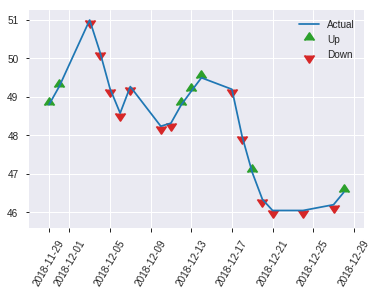


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22208379259575378
RMSE: 0.4712576711266924
LogLoss: 0.6335269595556768
Mean Per-Class Error: 0.30743801652892566
AUC: 0.7344564526382709
pr_auc: 0.7307060571765243
Gini: 0.4689129052765417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3073065985537827: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      32   89   0.7355   (89.0/121.0)
1      4    126  0.0308   (4.0/130.0)
Total  36   215  0.3705   (93.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307307     0.730435  214
max f2                       0.307307     0.857143  214
max f0point5                 0.463804     0.714286  103
max accuracy                 0.463804     0.689243  103
max precision                0.798676     1         0
max recall                   0.166071     1         242
max specificity              0.798676     1         0
max absolute_mcc             0.463804     0.390652  103
max min_per_class_accuracy   0.446047     0.652893  126
max mean_per_class_accuracy  0.463804     0.692562  103

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 43.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.718371           1.93077   1.93077            1                0.776288  1                           0.776288            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.666836           1.28718   1.60897            0.666667         0.68719   0.833333                    0.731739            0.0153846       0.0384615                  28.7179   60.8974
    3        0.0318725                   0.624958           0.965385  1.44808            0.5              0.636427  0.75                        0.707911            0.00769231      0.0461538                  -3.46154  44.8077
    4        0.0438247                   0.618465           1.93077   1.57972            1                0.619963  0.818182                    0.683925            0.0230769       0.0692308                  93.0769   57.972
    5        0.0517928                   0.615088           1.93077   1.63373            1                0.616463  0.846154                    0.673546            0.0153846       0.0846154                  93.0769   63.3728
    6        0.103586                    0.584381           1.48521   1.55947            0.769231         0.601446  0.807692                    0.637496            0.0769231       0.161538                   48.5207   55.9467
    7        0.151394                    0.550736           1.93077   1.67672            1                0.571744  0.868421                    0.616732            0.0923077       0.253846                   93.0769   67.6721
    8        0.203187                    0.530807           1.48521   1.6279             0.769231         0.540387  0.843137                    0.597272            0.0769231       0.330769                   48.5207   62.7903
    9        0.302789                    0.507198           1.08123   1.44808            0.56             0.516576  0.75                        0.570727            0.107692        0.438462                   8.12308   44.8077
    10       0.40239                     0.46755            1.39015   1.43374            0.72             0.489002  0.742574                    0.550498            0.138462        0.576923                   39.0154   43.374
    11       0.501992                    0.446866           0.695077  1.28718            0.36             0.455171  0.666667                    0.531584            0.0692308       0.646154                   -30.4923  28.7179
    12       0.601594                    0.407816           1.08123   1.25308            0.56             0.424823  0.649007                    0.513908            0.107692        0.753846                   8.12308   25.3082
    13       0.701195                    0.372035           1.004     1.2177             0.52             0.388382  0.630682                    0.496078            0.1             0.853846                   0.4       21.7701
    14       0.800797                    0.335447           0.386154  1.11427            0.2              0.354769  0.577114                    0.478502            0.0384615       0.892308                   -61.3846  11.4275
    15       0.900398                    0.265461           0.772308  1.07645            0.4              0.303678  0.557522                    0.459163            0.0769231       0.969231                   -22.7692  7.64466
    16       1                           0.101497           0.308923  1                  0.16             0.190755  0.517928                    0.432429           

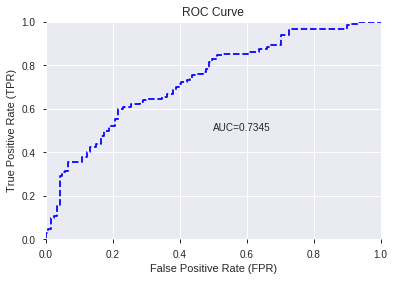

This function is available for GLM models only


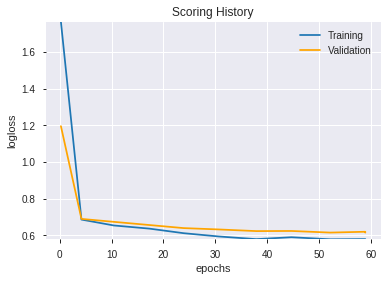

--2019-08-27 18:22:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_174548_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_174548_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_182247_model_6  0.751939  0.588243              0.361634  0.450074  0.202566
1  DeepLearning_grid_1_AutoML_20190827_182247_model_8  0.738334  0.614755              0.344819  0.462640  0.214036
2  DeepLearning_grid_1_AutoML_20190827_182247_model_9  0.735855  0.603608              0.318595  0.456523  0.208414
3               DeepLearning_1_AutoML_20190827_182247  0.728417  0.624706              0.355499  0.463282  0.214630
4  DeepLearning_grid_1_AutoML_20190827_182247_model_7  0.711825  0.770016              0.378449  0.495209  0.245232
5  DeepLearning_grid_1_AutoML_20190827_182247_model_5  0.701271  0.648777              0.378449  0.475664  0.226256
6  DeepLearning_grid_1_AutoML_20190827_182247_model_3  0.680038  0.750705              0.407374  0.500385  0.250386
7  DeepLearning_grid_1_AutoML_20190827_182247_model_4  0.669231  0.802162              0.407374  0.519244  0.269614
8  DeepLearning_grid_1_AutoML_20190827_182247_model_1  0.662301  0.939937              0.402956  0.532658  0.283725
9  DeepLearning_grid_1_AutoML_20190827_182247_model_2  0.658614  0.768469              0.420343  0.511846  0.261986

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.026418
1                  BOP             0.998922           0.998922    0.026389
2                  SUB             0.901743           0.901743    0.023822
3          CDLLONGLINE             0.878206           0.878206    0.023200
4               TRANGE             0.829546           0.829546    0.021915
5                  day             0.823034           0.823034    0.021743
6               ULTOSC             0.809607           0.809607    0.021388
7        CDLHANGINGMAN             0.806157           0.806157    0.021297
8         weekday_name             0.783755           0.783755    0.020705
9     CDLDRAGONFLYDOJI             0.782072           0.782072    0.020661
10      CDLRICKSHAWMAN             0.781020           0.781020    0.020633
11        HT_TRENDMODE             0.774011           0.774011    0.020448
12          aroonup_30             0.770566           0.770566    0.020357
13                 DIV             0.770514           0.770514    0.020355
14              MFI_14             0.761184           0.761184    0.020109
15              MFI_20             0.755404           0.755404    0.019956
16                DX_8             0.751109           0.751109    0.019843
17        CDLENGULFING             0.746920           0.746920    0.019732
18            CORREL_8             0.746497           0.746497    0.019721
19           dayofweek             0.744685           0.744685    0.019673
20               DX_12             0.744402           0.744402    0.019665
21      STOCHRSI_fastk             0.742720           0.742720    0.019621
22      CDLMORNINGSTAR             0.741162           0.741162    0.019580
23             weekday             0.739792           0.739792    0.019544
24            WILLR_30             0.739044           0.739044    0.019524
25              MFI_12             0.738743           0.738743    0.019516
26          PLUS_DI_14             0.738708           0.738708    0.019515
27            WILLR_24             0.738543           0.738543    0.019511
28         AROONOSC_12             0.732626           0.732626    0.019354
29   CDLDARKCLOUDCOVER             0.732200           0.732200    0.019343
30        STOCHF_fastk             0.730420           0.730420    0.019296
31               DX_14             0.729292           0.729292    0.019266
32             CDLDOJI             0.725803           0.725803    0.019174
33           CDLTAKURI             0.724386           0.724386    0.019137
34         CDLMARUBOZU             0.722144           0.722144    0.019077
35           aroonup_8             0.721134           0.721134    0.019051
36              SAREXT             0.720946           0.720946    0.019046
37             WILLR_8             0.719522           0.719522    0.019008
38         STOCH_slowd             0.716893           0.716893    0.018939
39            WILLR_14             0.715787           0.715787    0.018909
40              CCI_12             0.714900           0.714900    0.018886
41               ADOSC             0.711968           0.711968    0.018809
42            WILLR_12             0.711152           0.711152    0.018787
43        is_month_end             0.708020           0.708020    0.018704
44         CDLBELTHOLD             0.704191           0.704191    0.018603
45            WILLR_20             0.703893           0.703893    0.018595
46   HT_PHASOR_inphase             0.702134           0.702134    0.018549
47          CDLHIKKAKE             0.699815           0.699815    0.018488
48   CDLLONGLEGGEDDOJI             0.686328           0.686328    0.018131
49      CDLSPINNINGTOP             0.681678           0.681678    0.018008

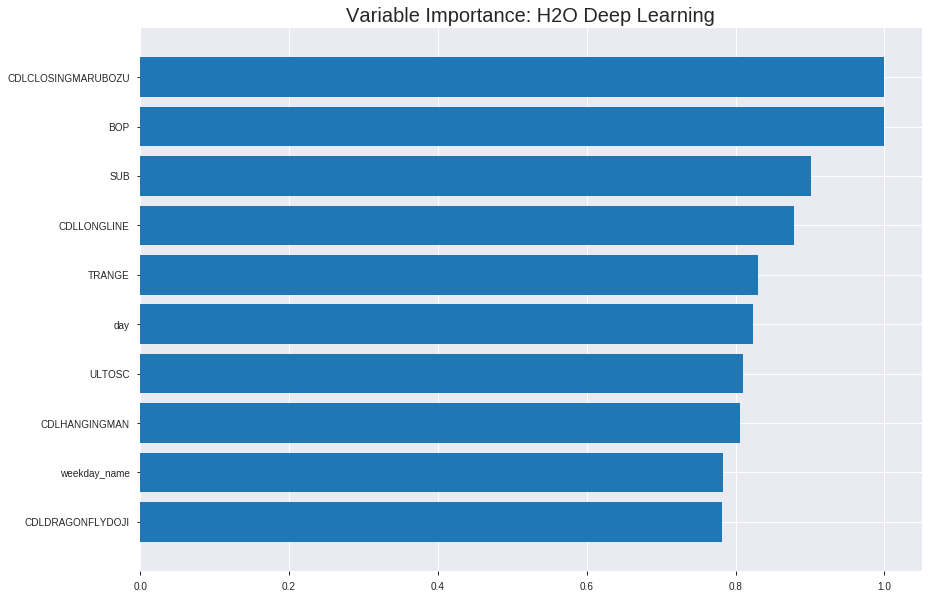

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_182247_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1962860995523289
RMSE: 0.44304187110512355
LogLoss: 0.5758841783161459
Mean Per-Class Error: 0.3032615153694612
AUC: 0.7681167067971689
pr_auc: 0.7685377868471887
Gini: 0.5362334135943378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3327273282028008: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      355  494   0.5819   (494.0/849.0)
1      85   819   0.094    (85.0/904.0)
Total  440  1313  0.3303   (579.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.332727     0.738836  283
max f2                       0.0793843    0.852543  367
max f0point5                 0.630331     0.711902  148
max accuracy                 0.540135     0.697091  195
max precision                0.972411     1         0
max recall                   0.0337651    1         388
max specificity              0.972411     1         0
max absolute_mcc             0.540135     0.393522  195
max min_per_class_accuracy   0.544199     0.69258   193
max mean_per_class_accuracy  0.540135     0.696738  195

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.941599           1.7237    1.7237             0.888889         0.953712   0.888889                    0.953712            0.0176991       0.0176991                  72.3697   72.3697
    2        0.0205362                   0.92951            1.83143   1.77756            0.944444         0.935313   0.916667                    0.944513            0.0188053       0.0365044                  83.1428   77.7563
    3        0.0302339                   0.910804           1.82509   1.79281            0.941176         0.920009   0.924528                    0.936653            0.0176991       0.0542035                  82.5091   79.2808
    4        0.040502                    0.897963           1.7237    1.77529            0.888889         0.903694   0.915493                    0.928297            0.0176991       0.0719027                  72.3697   77.5287
    5        0.0501997                   0.885585           1.48289   1.7188             0.764706         0.890148   0.886364                    0.920927            0.0143805       0.0862832                  48.2887   71.88
    6        0.100399                    0.834521           1.74084   1.72982            0.897727         0.859212   0.892045                    0.89007             0.0873894       0.173673                   74.0836   72.9818
    7        0.150029                    0.787962           1.58253   1.6811             0.816092         0.809287   0.86692                     0.863347            0.0785398       0.252212                   58.2532   68.1096
    8        0.200228                    0.746332           1.47641   1.62978            0.761364         0.765322   0.840456                    0.838771            0.074115        0.326327                   47.6405   62.9778
    9        0.300057                    0.677594           1.34079   1.53363            0.691429         0.710908   0.790875                    0.796231            0.13385         0.460177                   34.079    53.3632
    10       0.399886                    0.620239           1.18566   1.44676            0.611429         0.649315   0.746077                    0.759554            0.118363        0.57854                    18.5657   44.6762
    11       0.500285                    0.549304           1.06874   1.3709             0.551136         0.585424   0.706956                    0.724609            0.107301        0.685841                   6.87412   37.0899
    12       0.600114                    0.480803           0.964039  1.30322            0.497143         0.518328   0.672053                    0.690294            0.0962389       0.78208                    -3.59608  30.3218
    13       0.699943                    0.383736           0.85323   1.23904            0.44             0.43877    0.638957                    0.654421            0.085177        0.867257                   -14.677   23.9039
    14       0.799772                    0.264164           0.642693  1.1646             0.331429         0.329366   0.600571                    0.613847            0.0641593       0.931416                   -35.7307  16.4602
    15       0.899601                    0.119818           0.443236  1.08455            0.228571         0.193408   0.55929                     0.567191            0.0442478       0.975664                   -55.6764  8.4552
    16       1                           0.0037942          0.242395  1                  0.125            0.0624603  0.515687                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2215060321698215
RMSE: 0.47064427349094723
LogLoss: 0.6401630963608329
Mean Per-Class Error: 0.3378074456885827
AUC: 0.7036319265001436
pr_auc: 0.6746496052608129
Gini: 0.4072638530002872
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48656164790256984: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  130  0.535    (130.0/243.0)
1      38   220  0.1473   (38.0/258.0)
Total  151  350  0.3353   (168.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486562     0.723684  272
max f2                       0.0909542    0.848806  377
max f0point5                 0.596082     0.672043  205
max accuracy                 0.527953     0.666667  255
max precision                0.935063     0.8       4
max recall                   0.019139     1         396
max specificity              0.946122     0.995885  0
max absolute_mcc             0.50122      0.347887  268
max min_per_class_accuracy   0.599615     0.647287  201
max mean_per_class_accuracy  0.596082     0.662193  205

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 55.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.933926           1.29457   1.29457            0.666667         0.940199   0.666667                    0.940199            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.911776           1.55349   1.41226            0.8              0.915919   0.727273                    0.929163            0.0155039       0.0310078                  55.3488   41.2262
    3        0.0319361                   0.907484           1.55349   1.4564             0.8              0.909305   0.75                        0.922957            0.0155039       0.0465116                  55.3488   45.6395
    4        0.0419162                   0.889911           1.55349   1.47951            0.8              0.895839   0.761905                    0.916501            0.0155039       0.0620155                  55.3488   47.9513
    5        0.0518962                   0.874617           1.55349   1.49374            0.8              0.884474   0.769231                    0.910342            0.0155039       0.0775194                  55.3488   49.3739
    6        0.101796                    0.835854           1.39814   1.44688            0.72             0.855359   0.745098                    0.88339             0.0697674       0.147287                   39.814    44.6876
    7        0.151697                    0.797542           1.32047   1.40529            0.68             0.814599   0.723684                    0.860761            0.0658915       0.213178                   32.0465   40.5294
    8        0.201597                    0.764323           1.32047   1.3843             0.68             0.777109   0.712871                    0.840055            0.0658915       0.27907                    32.0465   38.4297
    9        0.301397                    0.703197           1.28163   1.3503             0.66             0.731234   0.695364                    0.804022            0.127907        0.406977                   28.1628   35.03
    10       0.401198                    0.649288           1.24279   1.32356            0.64             0.677527   0.681592                    0.772555            0.124031        0.531008                   24.2791   32.3557
    11       0.500998                    0.599743           1.12628   1.28426            0.58             0.622883   0.661355                    0.74274             0.112403        0.643411                   12.6279   28.4258
    12       0.600798                    0.563263           1.0486    1.24511            0.54             0.581927   0.641196                    0.716027            0.104651        0.748062                   4.86047   24.5113
    13       0.700599                    0.482186           1.0486    1.21712            0.54             0.530206   0.626781                    0.689557            0.104651        0.852713                   4.86047   21.7121
    14       0.800399                    0.358125           0.621395  1.14284            0.32             0.415081   0.588529                    0.655333            0.0620155       0.914729                   -37.8605  14.2841
    15       0.9002                      0.148482           0.582558  1.08073            0.3              0.249104   0.556541                    0.610296            0.0581395       0.972868                   -41.7442  8.0725
    16       1                           0.00726392         0.27186   1                  0.14             0.0839504  0.51497                     0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:26:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:26:29  1 min 54.436 sec  799 obs/sec       0.922989  1             1618       0.500855         0.841265            -0.00441344    0.747367        0.750583           1.83143          0.351968                         0.518342           0.835992              -0.075679        0.69123           0.665898             1.61822            0.339321
    2019-08-27 18:26:36  2 min  1.611 sec  1520 obs/sec      7.4267    8             13019      0.443042         0.575884            0.214082       0.768117        0.768538           1.7237           0.330291                         0.470644           0.640163              0.113181         0.703632          0.67465              1.29457            0.335329
    2019-08-27 18:26:43  2 min  8.163 sec  1910 obs/sec      15.7872   17            27675      0.435729         0.55865             0.239812       0.783043        0.785762           1.93916          0.31603                          0.473298           0.651175              0.103151         0.69572           0.659776             1.29457            0.345309
    2019-08-27 18:26:49  2 min 14.655 sec  2162 obs/sec      25.0941   27            43990      0.43123          0.549118            0.255429       0.791915        0.793208           1.83143          0.309755                         0.480714           0.684999              0.074826         0.692411          0.65106              0.97093            0.341317
    2019-08-27 18:26:56  2 min 21.122 sec  2304 obs/sec      34.3731   37            60256      0.423173         0.531782            0.282993       0.808744        0.812283           1.83143          0.300627                         0.482258           0.690952              0.0688759        0.683175          0.640779             0.647287           0.369261
    2019-08-27 18:27:03  2 min 27.941 sec  2416 obs/sec      44.5727   48            78136      0.413796         0.514703            0.314416       0.823478        0.824208           1.83143          0.2915                           0.489758           0.730095              0.0396878        0.676205          0.628112             0.647287           0.379242
    2019-08-27 18:27:09  2 min 34.456 sec  2512 obs/sec      54.7963   59            96058      0.407227         0.499423            0.336012       0.834791        0.837079           1.83143          0.264119                         0.495966           0.757737              0.0151879        0.667656          0.614956             0.323643           0.373253
    2019-08-27 18:27:10  2 min 35.116 sec  2510 obs/sec      54.7963   59            96058      0.443042         0.575884            0.214082       0.768117        0.768538           1.7237           0.330291                         0.470644           0.640163              0.113181         0.703632          0.67465              1.29457            0.335329

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.026417778256574927
BOP                 0.9989224076271057     0.9989224076271057   0.02638931066021683
SUB                 0.9017425179481506     0.9017425179481506   0.023822033883679778
CDLLONGLINE         0.8782058358192444     0.8782058358192444   0.023200247034302846
TRANGE              0.8295455574989319     0.8295455574989319   0.021914750591733607
---                 ---                    ---                  ---
WILLR_20            0.7038933038711548     0.7038933038711548   0.01859529721795608
HT_PHASOR_inphase   0.7021338939666748     0.7021338939666748   0.018548817517237106
CDLHIKKAKE          0.6998152732849121     0.6998152732849121   0.01848756471020519
CDLLONGLEGGEDDOJI   0.6863281726837158     0.6863281726837158   0.01813126547719867
CDLSPINNINGTOP      0.6816781163215637     0.6816781163215637   0.01800842131934276


See the whole table with table.as_data_frame()


('accuracy', 0.7051792828685259)

('F1', 0.7365269461077845)

('auc', 0.7519389701207883)

('logloss', 0.5882432443190171)

('mean_per_class_error', 0.2926255562619199)

('rmse', 0.45007382753801134)

('mse', 0.2025664502347156)

deeplearning prediction progress: |███████████████████████████████████████| 100%


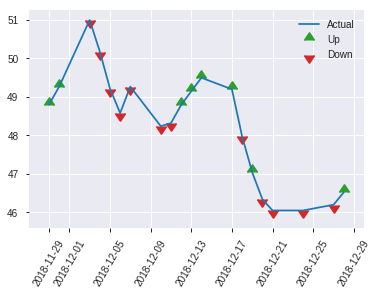


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2025664502347156
RMSE: 0.45007382753801134
LogLoss: 0.5882432443190171
Mean Per-Class Error: 0.2926255562619199
AUC: 0.7519389701207883
pr_auc: 0.756148999722944
Gini: 0.5038779402415765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28133389806934317: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      40   81   0.6694   (81.0/121.0)
1      7    123  0.0538   (7.0/130.0)
Total  47   204  0.3506   (88.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281334     0.736527  203
max f2                       0.10522      0.855615  227
max f0point5                 0.592886     0.726644  111
max accuracy                 0.592886     0.705179  111
max precision                0.947888     1         0
max recall                   0.0453429    1         241
max specificity              0.947888     1         0
max absolute_mcc             0.592886     0.416901  111
max min_per_class_accuracy   0.559981     0.7       126
max mean_per_class_accuracy  0.592886     0.707374  111

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 51.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.925845           1.93077   1.93077            1                0.943873   1                           0.943873            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.90057            1.93077   1.93077            1                0.907099   1                           0.925486            0.0230769       0.0461538                  93.0769   93.0769
    3        0.0318725                   0.875195           1.93077   1.93077            1                0.878752   1                           0.913802            0.0153846       0.0615385                  93.0769   93.0769
    4        0.0438247                   0.8623             1.93077   1.93077            1                0.866567   1                           0.90092             0.0230769       0.0846154                  93.0769   93.0769
    5        0.0517928                   0.860322           0.965385  1.78225            0.5              0.86088    0.923077                    0.89476             0.00769231      0.0923077                  -3.46154  78.2249
    6        0.103586                    0.801719           1.78225   1.78225            0.923077         0.822113   0.923077                    0.858436            0.0923077       0.184615                   78.2249   78.2249
    7        0.151394                    0.761143           1.28718   1.62591            0.666667         0.778159   0.842105                    0.833085            0.0615385       0.246154                   28.7179   62.5911
    8        0.203187                    0.719666           1.33669   1.55219            0.692308         0.736726   0.803922                    0.808523            0.0692308       0.315385                   33.6686   55.2187
    9        0.302789                    0.655149           1.15846   1.42267            0.6              0.691974   0.736842                    0.770185            0.115385        0.430769                   15.8462   42.2672
    10       0.40239                     0.607898           1.46738   1.43374            0.76             0.628896   0.742574                    0.735212            0.146154        0.576923                   46.7385   43.374
    11       0.501992                    0.560564           1.15846   1.37912            0.6              0.584863   0.714286                    0.705381            0.115385        0.692308                   15.8462   37.9121
    12       0.601594                    0.49657            0.617846  1.25308            0.32             0.52769    0.649007                    0.675962            0.0615385       0.753846                   -38.2154  25.3082
    13       0.701195                    0.400168           0.926769  1.20673            0.48             0.451842   0.625                       0.644127            0.0923077       0.846154                   -7.32308  20.6731
    14       0.800797                    0.296594           0.849538  1.1623             0.44             0.344511   0.60199                     0.606861            0.0846154       0.930769                   -15.0462  16.2304
    15       0.900398                    0.115853           0.463385  1.08499            0.24             0.205362   0.561947                    0.562448            0.0461538       0.976923                   -53.6615  8.49898
    16       1                           0.0163524          0.231692  1                  0.12             0.0601369  0.517928                    

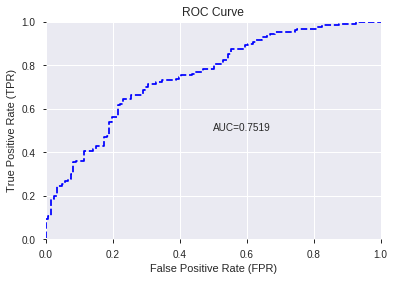

This function is available for GLM models only


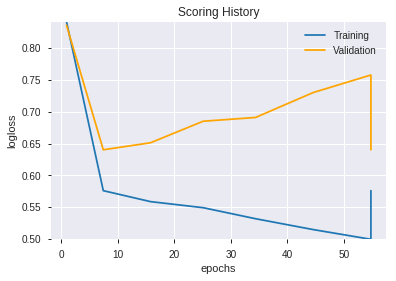

--2019-08-27 18:31:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_182247_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_182247_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'SUB',
 'CDLLONGLINE',
 'TRANGE',
 'day',
 'ULTOSC',
 'CDLHANGINGMAN',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'aroonup_30',
 'DIV',
 'MFI_14',
 'MFI_20',
 'DX_8',
 'CDLENGULFING',
 'CORREL_8',
 'dayofweek',
 'DX_12',
 'STOCHRSI_fastk',
 'CDLMORNINGSTAR',
 'weekday',
 'WILLR_30',
 'MFI_12',
 'PLUS_DI_14',
 'WILLR_24',
 'AROONOSC_12',
 'CDLDARKCLOUDCOVER',
 'STOCHF_fastk',
 'DX_14',
 'CDLDOJI',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'aroonup_8',
 'SAREXT',
 'WILLR_8',
 'STOCH_slowd',
 'WILLR_14',
 'CCI_12',
 'ADOSC',
 'WILLR_12',
 'is_month_end',
 'CDLBELTHOLD',
 'WILLR_20',
 'HT_PHASOR_inphase',
 'CDLHIKKAKE',
 'CDLLONGLEGGEDDOJI',
 'CDLSPINNINGTOP']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_183110_model_1  0.732041  0.605249              0.383439  0.457086  0.208927

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.345993           1.000000    0.070624
1                  SUB             0.310209           0.896574    0.063320
2               CCI_12             0.242644           0.701296    0.049528
3               ULTOSC             0.226818           0.655556    0.046298
4   CDLCLOSINGMARUBOZU             0.194178           0.561220    0.039636
5             WILLR_30             0.157378           0.454857    0.032124
6             WILLR_24             0.147085           0.425109    0.030023
7        CDLHANGINGMAN             0.134145           0.387709    0.027382
8               MFI_14             0.126011           0.364201    0.025721
9           aroonup_30             0.123579           0.357171    0.025225
10          PLUS_DI_14             0.123488           0.356908    0.025206
11         AROONOSC_12             0.121889           0.352288    0.024880
12         CDLLONGLINE             0.121746           0.351875    0.024851
13              MFI_20             0.119663           0.345852    0.024426
14         STOCH_slowd             0.115140           0.332780    0.023502
15                 day             0.108303           0.313021    0.022107
16            WILLR_14             0.105523           0.304986    0.021539
17   CDLDARKCLOUDCOVER             0.104446           0.301872    0.021319
18              MFI_12             0.103370           0.298762    0.021100
19            CORREL_8             0.103115           0.298026    0.021048
20         CDLMARUBOZU             0.101044           0.292039    0.020625
21             WILLR_8             0.100240           0.289717    0.020461
22          CDLHIKKAKE             0.097574           0.282012    0.019917
23            WILLR_12             0.096791           0.279747    0.019757
24        weekday_name             0.095228           0.275232    0.019438
25   HT_PHASOR_inphase             0.093296           0.269648    0.019044
26      CDLMORNINGSTAR             0.090371           0.261194    0.018447
27        STOCHF_fastk             0.083965           0.242678    0.017139
28           aroonup_8             0.082187           0.237538    0.016776
29      CDLRICKSHAWMAN             0.079728           0.230431    0.016274
30           CDLTAKURI             0.077127           0.222914    0.015743
31        HT_TRENDMODE             0.076686           0.221642    0.015653
32         CDLBELTHOLD             0.069420           0.200639    0.014170
33      CDLSPINNINGTOP             0.064182           0.185502    0.013101
34           dayofweek             0.054925           0.158747    0.011211
35             weekday             0.054721           0.158158    0.011170
36            WILLR_20             0.052719           0.152370    0.010761
37                DX_8             0.046421           0.134167    0.009475
38      STOCHRSI_fastk             0.045944           0.132788    0.009378
39        is_month_end             0.043912           0.126915    0.008963
40   CDLLONGLEGGEDDOJI             0.040714           0.117672    0.008311
41              SAREXT             0.037376           0.108026    0.007629
42               DX_14             0.035872           0.103678    0.007322
43        CDLENGULFING             0.035009           0.101184    0.007146
44    CDLDRAGONFLYDOJI             0.027160           0.078497    0.005544
45              TRANGE             0.027091           0.078300    0.005530
46               ADOSC             0.025021           0.072317    0.005107
47               DX_12             0.022513           0.065069    0.004595
48             CDLDOJI             0.006423           0.018565    0.001311
49                 DIV             0.000698           0.002016    0.000142

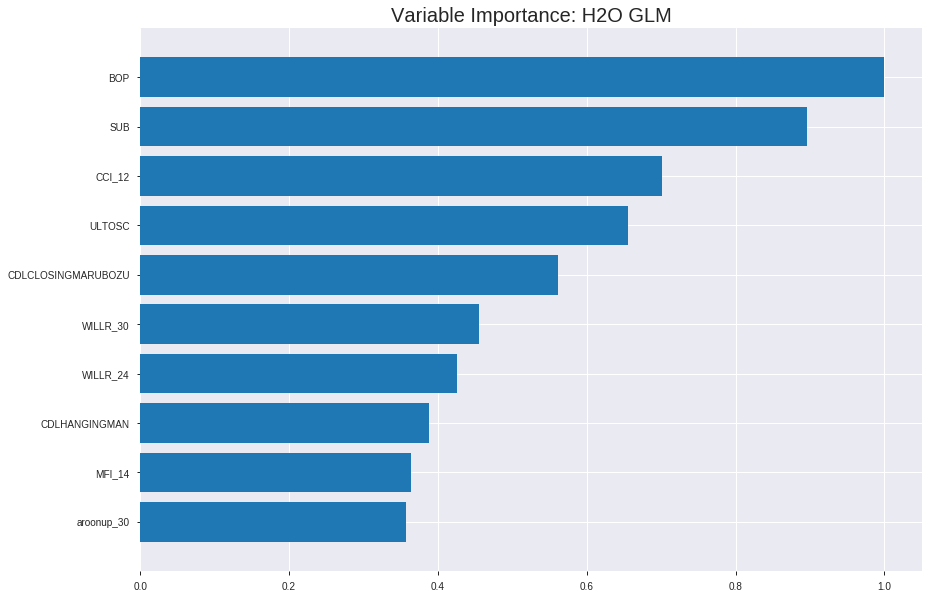

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_183110_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19511772072664949
RMSE: 0.4417213156806557
LogLoss: 0.5728595698087656
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2428.4481185881305
Residual deviance: 2008.445651749532
AIC: 2110.445651749532
AUC: 0.7704431032865318
pr_auc: 0.7662246586308785
Gini: 0.5408862065730635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38576882866539314: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      396  453   0.5336   (453.0/849.0)
1      100  804   0.1106   (100.0/904.0)
Total  496  1257  0.3155   (553.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385769     0.7441    263
max f2                       0.153798     0.851873  361
max f0point5                 0.560127     0.712379  176
max accuracy                 0.497582     0.703936  208
max precision                0.979723     1         0
max recall                   0.0606786    1         390
max specificity              0.979723     1         0
max absolute_mcc             0.497582     0.406925  208
max min_per_class_accuracy   0.529881     0.700824  192
max mean_per_class_accuracy  0.497582     0.702659  208

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.919951           1.83143   1.83143            0.944444         0.938989  0.944444                    0.938989            0.0188053       0.0188053                  83.1428   83.1428
    2        0.0205362                   0.902444           1.61597   1.7237             0.833333         0.910122  0.888889                    0.924555            0.0165929       0.0353982                  61.5966   72.3697
    3        0.0302339                   0.88123            1.82509   1.75622            0.941176         0.891971  0.90566                     0.914104            0.0176991       0.0530973                  82.5091   75.622
    4        0.040502                    0.866837           1.93916   1.8026             1                0.873368  0.929577                    0.903776            0.0199115       0.0730088                  93.9159   80.2599
    5        0.0501997                   0.856079           1.59695   1.76287            0.823529         0.861233  0.909091                    0.895558            0.0154867       0.0884956                  59.6955   76.2872
    6        0.100399                    0.792747           1.56455   1.66371            0.806818         0.823774  0.857955                    0.859666            0.0785398       0.167035                   56.4549   66.3711
    7        0.150029                    0.746954           1.53795   1.62211            0.793103         0.76814   0.836502                    0.829389            0.0763274       0.243363                   53.7954   62.211
    8        0.200228                    0.71761            1.60862   1.61873            0.829545         0.731352  0.834758                    0.80481             0.0807522       0.324115                   60.8621   61.8728
    9        0.300057                    0.659295           1.37403   1.53732            0.708571         0.687177  0.792776                    0.765674            0.137168        0.461283                   37.4033   53.7318
    10       0.399886                    0.594491           1.14133   1.43846            0.588571         0.624957  0.741797                    0.730545            0.113938        0.575221                   14.1334   43.8463
    11       0.500285                    0.53298            1.18994   1.38859            0.613636         0.565251  0.716078                    0.697373            0.119469        0.69469                    18.9939   38.8588
    12       0.600114                    0.459347           0.908635  1.30875            0.468571         0.496316  0.674905                    0.663927            0.090708        0.785398                   -9.13654  30.8748
    13       0.699943                    0.396906           0.897554  1.2501             0.462857         0.428269  0.644662                    0.630317            0.0896018       0.875                      -10.2446  25.0102
    14       0.799772                    0.318439           0.598369  1.16875            0.308571         0.360642  0.60271                     0.596655            0.0597345       0.934735                   -40.1631  16.8751
    15       0.899601                    0.205302           0.409994  1.08455            0.211429         0.257721  0.55929                     0.559044            0.0409292       0.975664                   -59.0006  8.4552
    16       1                           0.00618917         0.242395  1                  0.125            0.127205  0.515687                    0.515687            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21475027334247743
RMSE: 0.4634115593535377
LogLoss: 0.6221401084061094
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.0853381814004
Residual deviance: 623.3843886229216
AIC: 725.3843886229216
AUC: 0.7172057932178517
pr_auc: 0.6863807722281744
Gini: 0.43441158643570343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35993983611154695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      82   161  0.6626   (161.0/243.0)
1      19   239  0.0736   (19.0/258.0)
Total  101  400  0.3593   (180.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35994      0.726444  310
max f2                       0.257582     0.850777  349
max f0point5                 0.535409     0.67852   218
max accuracy                 0.535409     0.672655  218
max precision                0.900926     0.8       9
max recall                   0.0742163    1         394
max specificity              0.953688     0.995885  0
max absolute_mcc             0.506162     0.348318  237
max min_per_class_accuracy   0.5702       0.654321  197
max mean_per_class_accuracy  0.535409     0.671045  218

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 54.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.915799           1.29457   1.29457            0.666667         0.932683  0.666667                    0.932683            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.900213           1.55349   1.41226            0.8              0.904855  0.727273                    0.920034            0.0155039       0.0310078                  55.3488   41.2262
    3        0.0319361                   0.866681           1.55349   1.4564             0.8              0.877966  0.75                        0.906888            0.0155039       0.0465116                  55.3488   45.6395
    4        0.0419162                   0.854949           1.16512   1.38704            0.6              0.857644  0.714286                    0.895163            0.0116279       0.0581395                  16.5116   38.7043
    5        0.0518962                   0.840819           1.94186   1.49374            1                0.843128  0.769231                    0.885156            0.0193798       0.0775194                  94.186    49.3739
    6        0.101796                    0.791116           1.47581   1.48495            0.76             0.814052  0.764706                    0.850301            0.0736434       0.151163                   47.5814   48.4952
    7        0.151697                    0.760307           1.32047   1.43084            0.68             0.778306  0.736842                    0.826618            0.0658915       0.217054                   32.0465   43.0845
    8        0.201597                    0.721773           1.47581   1.44198            0.76             0.740617  0.742574                    0.805331            0.0736434       0.290698                   47.5814   44.1976
    9        0.301397                    0.673092           1.28163   1.38888            0.66             0.695215  0.715232                    0.768869            0.127907        0.418605                   28.1628   38.888
    10       0.401198                    0.627094           1.32047   1.37186            0.68             0.646732  0.706468                    0.738486            0.131783        0.550388                   32.0465   37.1862
    11       0.500998                    0.571533           1.00977   1.29973            0.52             0.599085  0.669323                    0.710717            0.100775        0.651163                   0.976744  29.9731
    12       0.600798                    0.515194           0.97093   1.24511            0.5              0.542195  0.641196                    0.682723            0.0968992       0.748062                   -2.90698  24.5113
    13       0.700599                    0.449194           1.00977   1.21159            0.52             0.482984  0.623932                    0.654271            0.100775        0.848837                   0.976744  21.1588
    14       0.800399                    0.358122           0.776744  1.15737            0.4              0.405571  0.59601                     0.623261            0.0775194       0.926357                   -22.3256  15.7368
    15       0.9002                      0.250718           0.504884  1.08503            0.26             0.306941  0.558758                    0.588192            0.0503876       0.976744                   -49.5116  8.50307
    16       1                           0.0234812          0.233023  1                  0.12             0.154037  0.51497                     0.544863          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:31:10  0.000 sec   2            17        51            1.36256           1.36942
    2019-08-27 18:31:10  0.013 sec   4            11        51            1.35161           1.3618
    2019-08-27 18:31:10  0.026 sec   6            6.7       51            1.33696           1.35168
    2019-08-27 18:31:10  0.039 sec   8            4.1       51            1.31852           1.33905
    2019-08-27 18:31:10  0.053 sec   10           2.6       51            1.29667           1.32427
    2019-08-27 18:31:10  0.066 sec   12           1.6       51            1.27255           1.30823
    2019-08-27 18:31:10  0.079 sec   14           0.99      51            1.24791           1.29232
    2019-08-27 18:31:10  0.092 sec   16           0.62      51            1.22458           1.27791
    2019-08-27 18:31:10  0.105 sec   18           0.38      51            1.20405           1.26604
    2019-08-27 18:31:10  0.119 sec   20           0.24      51            1.18702           1.25705
    2019-08-27 18:31:11  0.132 sec   22           0.15      51            1.17352           1.25082
    2019-08-27 18:31:11  0.145 sec   24           0.092     51            1.1632            1.24697
    2019-08-27 18:31:11  0.158 sec   26           0.057     51            1.15554           1.24499
    2019-08-27 18:31:11  0.174 sec   28           0.035     51            1.14993           1.24432
    2019-08-27 18:31:11  0.186 sec   30           0.022     51            1.14572           1.24428
    2019-08-27 18:31:11  0.199 sec   32           0.014     51            1.1424            1.24453
    2019-08-27 18:31:11  0.213 sec   34           0.0085    51            1.13964           1.24478
    2019-08-27 18:31:11  0.226 sec   36           0.0053    51            1.13735           1.24528
    2019-08-27 18:31:11  0.240 sec   38           0.0033    51            1.13551           1.24591
    2019-08-27 18:31:11  0.253 sec   40           0.002     51            1.13414           1.24658

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7319884726224785)

('auc', 0.7320406865861412)

('logloss', 0.6052489632765383)

('mean_per_class_error', 0.3007628734901462)

('rmse', 0.45708570861232806)

('mse', 0.20892734501763408)

glm prediction progress: |████████████████████████████████████████████████| 100%


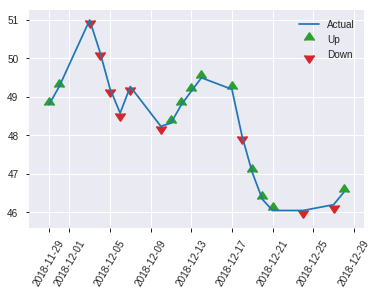


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20892734501763408
RMSE: 0.45708570861232806
LogLoss: 0.6052489632765383
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.642153441148
Residual deviance: 303.83497956482216
AIC: 405.83497956482216
AUC: 0.7320406865861412
pr_auc: 0.7039742489799926
Gini: 0.4640813731722824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2254278116882864: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      31   90   0.7438   (90.0/121.0)
1      3    127  0.0231   (3.0/130.0)
Total  34   217  0.3705   (93.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.225428     0.731988  216
max f2                       0.225428     0.861601  216
max f0point5                 0.490216     0.706052  140
max accuracy                 0.490216     0.701195  140
max precision                0.966323     1         0
max recall                   0.102162     1         243
max specificity              0.966323     1         0
max absolute_mcc             0.487166     0.401569  142
max min_per_class_accuracy   0.523719     0.68595   127
max mean_per_class_accuracy  0.490216     0.699237  140

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.90108            1.93077   1.93077            1                0.923721  1                           0.923721            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.856141           0.64359   1.28718            0.333333         0.875425  0.666667                    0.899573            0.00769231      0.0307692                  -35.641   28.7179
    3        0.0318725                   0.840231           1.93077   1.44808            1                0.843842  0.75                        0.88564             0.0153846       0.0461538                  93.0769   44.8077
    4        0.0438247                   0.82875            1.28718   1.4042             0.666667         0.83551   0.727273                    0.871968            0.0153846       0.0615385                  28.7179   40.4196
    5        0.0517928                   0.818702           0.965385  1.33669            0.5              0.822047  0.692308                    0.864288            0.00769231      0.0692308                  -3.46154  33.6686
    6        0.103586                    0.754921           1.63373   1.48521            0.846154         0.78787   0.769231                    0.826079            0.0846154       0.153846                   63.3728   48.5207
    7        0.151394                    0.718642           1.60897   1.52429            0.833333         0.735748  0.789474                    0.797553            0.0769231       0.230769                   60.8974   52.4291
    8        0.203187                    0.688669           1.18817   1.43861            0.615385         0.701116  0.745098                    0.772971            0.0615385       0.292308                   18.8166   43.8612
    9        0.302789                    0.620999           1.39015   1.42267            0.72             0.648568  0.736842                    0.732049            0.138462        0.430769                   39.0154   42.2672
    10       0.40239                     0.584196           1.23569   1.37639            0.64             0.600399  0.712871                    0.699462            0.123077        0.553846                   23.5692   37.639
    11       0.501992                    0.52891            1.23569   1.34847            0.64             0.557491  0.698413                    0.671293            0.123077        0.676923                   23.5692   34.8474
    12       0.601594                    0.442292           1.004     1.29144            0.52             0.490716  0.668874                    0.641397            0.1             0.776923                   0.4       29.1442
    13       0.701195                    0.380518           0.617846  1.19576            0.32             0.410068  0.619318                    0.608537            0.0615385       0.838462                   -38.2154  19.576
    14       0.800797                    0.311506           0.772308  1.14309            0.4              0.348138  0.59204                     0.576149            0.0769231       0.915385                   -22.7692  14.3092
    15       0.900398                    0.193235           0.617846  1.08499            0.32             0.242637  0.561947                    0.539256            0.0615385       0.976923                   -38.2154  8.49898
    16       1                           0.0400186          0.231692  1                  0.12             0.114278  0.517928                    0.496928           

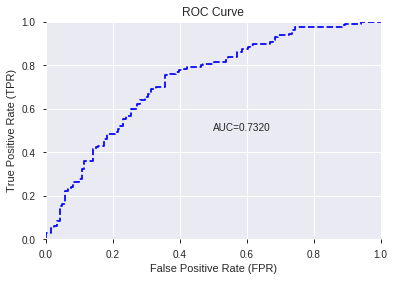

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


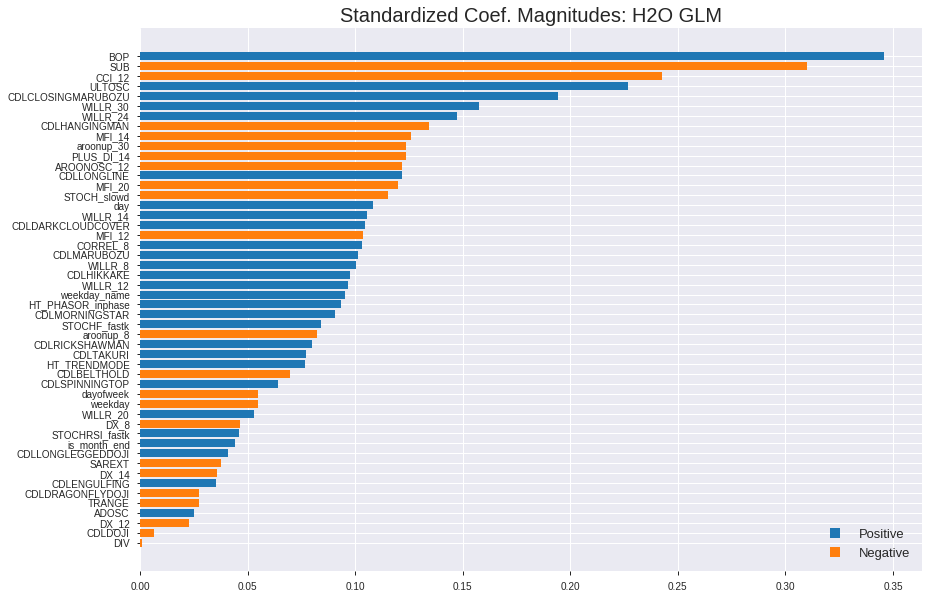

'log_likelihood'
--2019-08-27 18:31:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.44
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.44|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_183110_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_183110_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'CCI_12',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'WILLR_30',
 'WILLR_24',
 'CDLHANGINGMAN',
 'MFI_14',
 'aroonup_30',
 'PLUS_DI_14',
 'AROONOSC_12',
 'CDLLONGLINE',
 'MFI_20',
 'STOCH_slowd',
 'day',
 'WILLR_14',
 'CDLDARKCLOUDCOVER',
 'MFI_12',
 'CORREL_8',
 'CDLMARUBOZU',
 'WILLR_8',
 'CDLHIKKAKE',
 'WILLR_12',
 'weekday_name',
 'HT_PHASOR_inphase',
 'CDLMORNINGSTAR',
 'STOCHF_fastk',
 'aroonup_8',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'CDLBELTHOLD',
 'CDLSPINNINGTOP',
 'dayofweek',
 'weekday',
 'WILLR_20',
 'DX_8',
 'STOCHRSI_fastk',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'SAREXT',
 'DX_14',
 'CDLENGULFING',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'ADOSC',
 'DX_12',
 'CDLDOJI',
 'DIV']

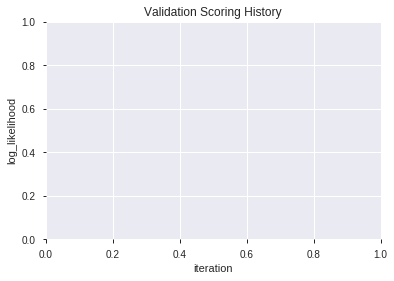

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_183123_model_4  0.740814  0.598164              0.309758  0.453342  0.205519
1               XGBoost_1_AutoML_20190827_183123  0.712206  0.619011              0.321011  0.464508  0.215768
2  XGBoost_grid_1_AutoML_20190827_183123_model_2  0.709409  0.617906              0.305626  0.463277  0.214625
3               XGBoost_3_AutoML_20190827_183123  0.702861  0.624084              0.334838  0.467282  0.218352
4  XGBoost_grid_1_AutoML_20190827_183123_model_6  0.701907  0.622140              0.296790  0.466126  0.217273
5               XGBoost_2_AutoML_20190827_183123  0.701399  0.627681              0.346949  0.468373  0.219373
6  XGBoost_grid_1_AutoML_20190827_183123_model_7  0.697521  0.634194              0.364050  0.471069  0.221906
7  XGBoost_grid_1_AutoML_20190827_183123_model_1  0.696758  0.625337              0.323713  0.468163  0.219177
8  XGBoost_grid_1_AutoML_20190827_183123_model_3  0.683853  0.630556              0.337254  0.470740  0.221596
9  XGBoost_grid_1_AutoML_20190827_183123_model_5  0.674952  0.652176              0.360490  0.479146  0.229581

variable  relative_importance  scaled_importance  percentage
0                  BOP          1619.229858           1.000000    0.329003
1                  SUB           488.778839           0.301859    0.099313
2         STOCHF_fastk           326.535309           0.201661    0.066347
3               ULTOSC           278.913422           0.172251    0.056671
4               CCI_12           191.767944           0.118432    0.038964
5                  DIV           146.331818           0.090371    0.029732
6           PLUS_DI_14           133.855698           0.082666    0.027197
7                  day           131.469772           0.081193    0.026713
8               MFI_12           123.388786           0.076202    0.025071
9                ADOSC           120.887741           0.074658    0.024563
10              SAREXT           115.198402           0.071144    0.023407
11               DX_12           109.681419           0.067737    0.022286
12               DX_14            90.551811           0.055923    0.018399
13              MFI_14            90.345154           0.055795    0.018357
14              MFI_20            88.284882           0.054523    0.017938
15            WILLR_30            81.900177           0.050580    0.016641
16           dayofweek            78.414978           0.048427    0.015933
17             WILLR_8            76.484291           0.047235    0.015540
18      STOCHRSI_fastk            62.481747           0.038587    0.012695
19         STOCH_slowd            61.711296           0.038112    0.012539
20              TRANGE            60.050167           0.037086    0.012201
21           aroonup_8            58.030113           0.035838    0.011791
22            CORREL_8            53.733616           0.033185    0.010918
23                DX_8            53.393234           0.032974    0.010849
24   HT_PHASOR_inphase            43.917999           0.027123    0.008923
25            WILLR_12            41.466805           0.025609    0.008425
26          aroonup_30            36.678543           0.022652    0.007453
27            WILLR_14            35.726067           0.022064    0.007259
28            WILLR_24            35.363518           0.021840    0.007185
29         AROONOSC_12            32.790985           0.020251    0.006663
30         CDLLONGLINE            16.580509           0.010240    0.003369
31  CDLCLOSINGMARUBOZU            14.713947           0.009087    0.002990
32             CDLDOJI            10.376314           0.006408    0.002108
33        weekday_name            10.204649           0.006302    0.002073
34            WILLR_20             2.382715           0.001472    0.000484

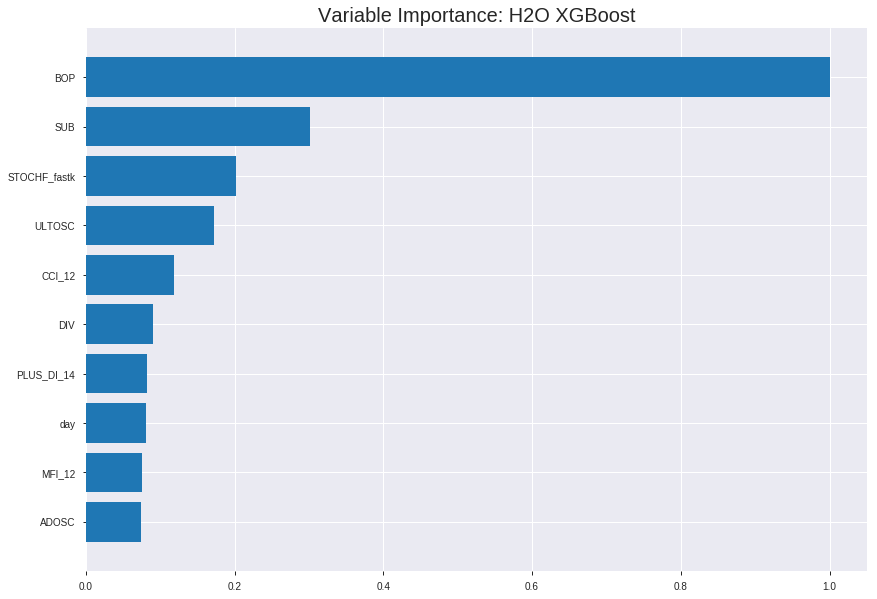

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_183123_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1794901939181396
RMSE: 0.42366283046561876
LogLoss: 0.5392310771759264
Mean Per-Class Error: 0.24530030123935498
AUC: 0.8221111250091206
pr_auc: 0.8266067028926808
Gini: 0.6442222500182413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4480753421783447: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      474  375   0.4417   (375.0/849.0)
1      113  791   0.125    (113.0/904.0)
Total  587  1166  0.2784   (488.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448075     0.764251  242
max f2                       0.218168     0.865142  348
max f0point5                 0.586813     0.771144  162
max accuracy                 0.564205     0.754136  176
max precision                0.882012     1         0
max recall                   0.152134     1         381
max specificity              0.882012     1         0
max absolute_mcc             0.564205     0.50925   176
max min_per_class_accuracy   0.55384      0.75      182
max mean_per_class_accuracy  0.564205     0.7547    176

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.76 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.837795           1.93916    1.93916            1                0.850804  1                           0.850804            0.0199115       0.0199115                  93.9159   93.9159
    2        0.0205362                   0.823983           1.93916    1.93916            1                0.830385  1                           0.840595            0.0199115       0.039823                   93.9159   93.9159
    3        0.0302339                   0.815252           1.82509    1.90257            0.941176         0.819517  0.981132                    0.833834            0.0176991       0.0575221                  82.5091   90.2571
    4        0.040502                    0.805968           1.83143    1.88454            0.944444         0.81102   0.971831                    0.82805             0.0188053       0.0763274                  83.1428   88.4535
    5        0.0501997                   0.797652           1.71102    1.85102            0.882353         0.801276  0.954545                    0.822878            0.0165929       0.0929204                  71.1023   85.1016
    6        0.100399                    0.755318           1.78491    1.81796            0.920455         0.772636  0.9375                      0.797757            0.0896018       0.182522                   78.4908   81.7962
    7        0.150029                    0.730302           1.67169    1.76958            0.862069         0.743198  0.912548                    0.779709            0.0829646       0.265487                   67.1689   76.9575
    8        0.200228                    0.703077           1.67473    1.7458             0.863636         0.71682   0.900285                    0.763942            0.0840708       0.349558                   67.4728   74.5796
    9        0.300057                    0.653235           1.41836    1.63686            0.731429         0.677792  0.844106                    0.73528             0.141593        0.49115                    41.8357   63.6857
    10       0.399886                    0.607517           1.34079    1.56295            0.691429         0.630863  0.805991                    0.709213            0.13385         0.625                      34.079    56.2946
    11       0.500285                    0.556539           1.20096    1.4903             0.619318         0.583866  0.768529                    0.684058            0.120575        0.745575                   20.0957   49.03
    12       0.600114                    0.497025           0.73134    1.36405            0.377143         0.524739  0.703422                    0.657555            0.0730088       0.818584                   -26.866   36.4047
    13       0.699943                    0.412651           0.764583   1.27855            0.394286         0.456969  0.659332                    0.628947            0.0763274       0.894912                   -23.5417  27.8549
    14       0.799772                    0.300923           0.587288   1.19226            0.302857         0.361278  0.614836                    0.595536            0.0586283       0.95354                    -41.2712  19.2265
    15       0.899601                    0.200872           0.36567    1.10054            0.188571         0.24913   0.567533                    0.557095            0.0365044       0.990044                   -63.433   10.0537
    16       1                           0.103342           0.0991616  1                  0.0511364        0.163692  0.515687                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21363144779921464
RMSE: 0.46220282106366967
LogLoss: 0.6171777778790258
Mean Per-Class Error: 0.3071825055029189
AUC: 0.7198376240150572
pr_auc: 0.6841830225418701
Gini: 0.4396752480301145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4582596719264984: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  128  0.5267   (128.0/243.0)
1      36   222  0.1395   (36.0/258.0)
Total  151  350  0.3273   (164.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45826      0.730263  266
max f2                       0.234521     0.850706  362
max f0point5                 0.57404      0.703498  189
max accuracy                 0.57404      0.692615  189
max precision                0.816666     0.8       9
max recall                   0.14902      1         397
max specificity              0.854037     0.995885  0
max absolute_mcc             0.57404      0.385463  189
max min_per_class_accuracy   0.57404      0.686047  189
max mean_per_class_accuracy  0.57404      0.692817  189

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 53.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.825306           1.29457   1.29457            0.666667         0.836702  0.666667                    0.836702            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.816077           1.55349   1.41226            0.8              0.81797   0.727273                    0.828187            0.0155039       0.0310078                  55.3488   41.2262
    3        0.0319361                   0.800275           1.16512   1.33503            0.6              0.808662  0.6875                      0.822086            0.0116279       0.0426357                  16.5116   33.5029
    4        0.0419162                   0.792913           1.55349   1.38704            0.8              0.796355  0.714286                    0.815959            0.0155039       0.0581395                  55.3488   38.7043
    5        0.0518962                   0.782233           1.16512   1.34436            0.6              0.78824   0.692308                    0.810629            0.0116279       0.0697674                  16.5116   34.4365
    6        0.101796                    0.740403           1.55349   1.44688            0.8              0.756107  0.745098                    0.783903            0.0775194       0.147287                   55.3488   44.6876
    7        0.151697                    0.718998           1.47581   1.4564             0.76             0.727707  0.75                        0.765417            0.0736434       0.22093                    47.5814   45.6395
    8        0.201597                    0.701739           1.24279   1.40352            0.64             0.710327  0.722772                    0.751781            0.0620155       0.282946                   24.2791   40.3523
    9        0.301397                    0.656757           1.32047   1.37602            0.68             0.676032  0.708609                    0.726699            0.131783        0.414729                   32.0465   37.602
    10       0.401198                    0.617897           1.24279   1.34288            0.64             0.635414  0.691542                    0.703991            0.124031        0.53876                    24.2791   34.2879
    11       0.500998                    0.572157           1.47581   1.36936            0.76             0.595596  0.705179                    0.682398            0.147287        0.686047                   47.5814   36.936
    12       0.600798                    0.523727           0.776744  1.27092            0.4              0.546698  0.654485                    0.659857            0.0775194       0.763566                   -22.3256  27.0919
    13       0.700599                    0.456703           0.97093   1.22819            0.5              0.488467  0.632479                    0.635442            0.0968992       0.860465                   -2.90698  22.8185
    14       0.800399                    0.371976           0.504884  1.138              0.26             0.415325  0.586035                    0.607996            0.0503876       0.910853                   -49.5116  13.7998
    15       0.9002                      0.246159           0.582558  1.07642            0.3              0.30608   0.554324                    0.574524            0.0581395       0.968992                   -41.7442  7.64193
    16       1                           0.138483           0.310698  1                  0.16             0.191802  0.51497                     0.536329           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:31:32  3.618 sec   0                  0.5              0.693147            0.5             0                  1                0.484313                         0.5                0.693147              0.5               0                    1                  0.48503
    2019-08-27 18:31:32  3.729 sec   5                  0.480939         0.655551            0.762523        0.745833           1.93916          0.334855                         0.487051           0.667475              0.699285          0.663573             1.21366            0.387226
    2019-08-27 18:31:32  3.808 sec   10                 0.468034         0.630285            0.772319        0.773001           1.93916          0.327439                         0.479232           0.651978              0.701941          0.658865             0.97093            0.331337
    2019-08-27 18:31:32  3.875 sec   15                 0.458501         0.611412            0.780838        0.785508           1.93916          0.324016                         0.473489           0.640485              0.710084          0.670494             0.97093            0.337325
    2019-08-27 18:31:32  3.949 sec   20                 0.45123          0.596858            0.788234        0.78844            1.93916          0.296634                         0.469635           0.6327                0.715603          0.677759             0.97093            0.331337
    2019-08-27 18:31:32  4.028 sec   25                 0.445751         0.585506            0.791807        0.793665           1.93916          0.30405                          0.467312           0.627843              0.716815          0.681698             0.97093            0.323353
    2019-08-27 18:31:33  4.101 sec   30                 0.441533         0.576732            0.797359        0.798951           1.93916          0.298916                         0.465721           0.624478              0.717963          0.68204              0.97093            0.331337
    2019-08-27 18:31:33  4.175 sec   35                 0.437602         0.568519            0.802409        0.805676           1.93916          0.296634                         0.464297           0.621575              0.720436          0.684331             0.97093            0.337325
    2019-08-27 18:31:33  4.251 sec   40                 0.434216         0.56146             0.807228        0.811112           1.93916          0.300627                         0.46341            0.619689              0.721744          0.684817             0.97093            0.323353
    2019-08-27 18:31:33  4.342 sec   45                 0.4312           0.55513             0.811521        0.816486           1.93916          0.2915                           0.463024           0.618906              0.721201          0.682127             0.97093            0.323353
    2019-08-27 18:31:33  4.427 sec   50                 0.427891         0.548415            0.817196        0.820779           1.93916          0.280662                         0.463533           0.619947              0.718155          0.680056             1.29457            0.321357
    2019-08-27 18:31:33  4.512 sec   55                 0.425439         0.543132            0.819691        0.823846           1.93916          0.279521                         0.46302            0.61883               0.717764          0.

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1619.2298583984375     1.0                    0.3290032606006841
SUB                 488.7788391113281      0.3018588352828263     0.09931254104917468
STOCHF_fastk        326.5353088378906      0.20166087423861065    0.0663470851600874
ULTOSC              278.9134216308594      0.17225066607080083    0.0566710307779331
CCI_12              191.7679443359375      0.11843157618499764    0.03896437472294255
---                 ---                    ---                    ---
CDLLONGLINE         16.580509185791016     0.010239750150229206   0.003368911187161753
CDLCLOSINGMARUBOZU  14.713947296142578     0.009087003441683061   0.0029896537614033654
CDLDOJI             10.376314163208008     0.006408178622318086   0.0021083116612542496
weekday_name        10.204648971557617     0.0063021620547751775  0.0020734318648549404
WILLR_20            2.3827147483825684     0.0014715111236518856  0.0004841319576916468


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7516339869281047)

('auc', 0.7408137317228226)

('logloss', 0.5981636507632573)

('mean_per_class_error', 0.30832803560076294)

('rmse', 0.45334217539948923)

('mse', 0.20551912799594124)

xgboost prediction progress: |████████████████████████████████████████████| 100%


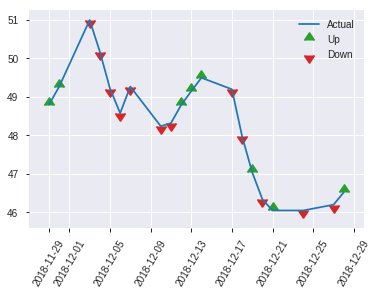


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20551912799594124
RMSE: 0.45334217539948923
LogLoss: 0.5981636507632573
Mean Per-Class Error: 0.30832803560076294
AUC: 0.7408137317228226
pr_auc: 0.7182816932905937
Gini: 0.4816274634456452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40378299355506897: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   61   0.5041   (61.0/121.0)
1      15   115  0.1154   (15.0/130.0)
Total  75   176  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403783     0.751634  175
max f2                       0.201321     0.857909  225
max f0point5                 0.56109      0.695876  112
max accuracy                 0.44448      0.697211  165
max precision                0.841362     1         0
max recall                   0.124861     1         247
max specificity              0.841362     1         0
max absolute_mcc             0.403783     0.415349  175
max min_per_class_accuracy   0.531205     0.669421  127
max mean_per_class_accuracy  0.44448      0.691672  165

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.793119           1.28718   1.28718            0.666667         0.819356  0.666667                    0.819356            0.0153846       0.0153846                  28.7179   28.7179
    2        0.0239044                   0.781363           1.93077   1.60897            1                0.784091  0.833333                    0.801723            0.0230769       0.0384615                  93.0769   60.8974
    3        0.0318725                   0.778462           1.93077   1.68942            1                0.779902  0.875                       0.796268            0.0153846       0.0538462                  93.0769   68.9423
    4        0.0438247                   0.773157           1.28718   1.57972            0.666667         0.775387  0.818182                    0.790573            0.0153846       0.0692308                  28.7179   57.972
    5        0.0517928                   0.757862           0.965385  1.48521            0.5              0.759545  0.769231                    0.7858              0.00769231      0.0769231                  -3.46154  48.5207
    6        0.103586                    0.70499            1.78225   1.63373            0.923077         0.724992  0.846154                    0.755396            0.0923077       0.169231                   78.2249   63.3728
    7        0.151394                    0.669077           1.12628   1.47348            0.583333         0.688482  0.763158                    0.734265            0.0538462       0.223077                   12.6282   47.3482
    8        0.203187                    0.657328           1.48521   1.47647            0.769231         0.661642  0.764706                    0.715753            0.0769231       0.3                        48.5207   47.6471
    9        0.302789                    0.619165           1.31292   1.42267            0.68             0.63594   0.736842                    0.689499            0.130769        0.430769                   31.2923   42.2672
    10       0.40239                     0.582621           1.31292   1.39551            0.68             0.598035  0.722772                    0.666859            0.130769        0.561538                   31.2923   39.5506
    11       0.501992                    0.535063           1.004     1.31783            0.52             0.557663  0.68254                     0.645193            0.1             0.661538                   0.4       31.7827
    12       0.601594                    0.488972           0.926769  1.25308            0.48             0.512088  0.649007                    0.623156            0.0923077       0.753846                   -7.32308  25.3082
    13       0.701195                    0.403783           1.31292   1.26158            0.68             0.449318  0.653409                    0.598463            0.130769        0.884615                   31.2923   26.1582
    14       0.800797                    0.305078           0.386154  1.1527             0.2              0.347053  0.597015                    0.567193            0.0384615       0.923077                   -61.3846  15.2698
    15       0.900398                    0.201321           0.617846  1.09353            0.32             0.254045  0.566372                    0.532553            0.0615385       0.984615                   -38.2154  9.3533
    16       1                           0.108424           0.154462  1                  0.08             0.15313   0.517928                    0.494762           

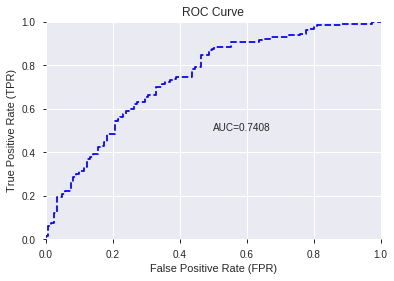

This function is available for GLM models only


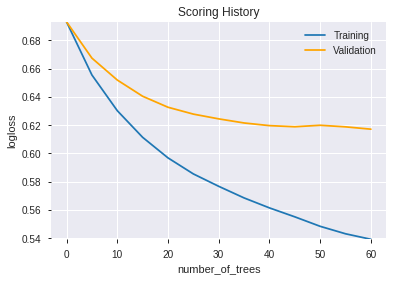

--2019-08-27 18:31:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_183123_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_183123_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'STOCHF_fastk',
 'ULTOSC',
 'CCI_12',
 'DIV',
 'PLUS_DI_14',
 'day',
 'MFI_12',
 'ADOSC',
 'SAREXT',
 'DX_12',
 'DX_14',
 'MFI_14',
 'MFI_20',
 'WILLR_30',
 'dayofweek',
 'WILLR_8',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'TRANGE',
 'aroonup_8',
 'CORREL_8',
 'DX_8',
 'HT_PHASOR_inphase',
 'WILLR_12',
 'aroonup_30',
 'WILLR_14',
 'WILLR_24',
 'AROONOSC_12',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI',
 'weekday_name',
 'WILLR_20']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_183155_model_1  0.693071  0.64174              0.363191  0.474247  0.22491

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.223102           1.000000  2.413322e-02
1                          SUB             0.155229           0.695775  1.679128e-02
2           CDLCLOSINGMARUBOZU             0.153939           0.689993  1.665175e-02
3                          DIV             0.136299           0.610927  1.474364e-02
4                       ULTOSC             0.119773           0.536854  1.295601e-02
...                        ...                  ...                ...           ...
1034  BBANDS_middleband_24_3_5             0.000033           0.000146  3.518671e-06
1035  BBANDS_middleband_24_3_4             0.000027           0.000122  2.940481e-06
1036   BBANDS_lowerband_12_4_5             0.000017           0.000075  1.811578e-06
1037   BBANDS_middleband_8_1_2             0.000011           0.000050  1.196474e-06
1038                  STDDEV_8             0.000004           0.000016  3.823312e-07

[1039 rows x 4 columns]

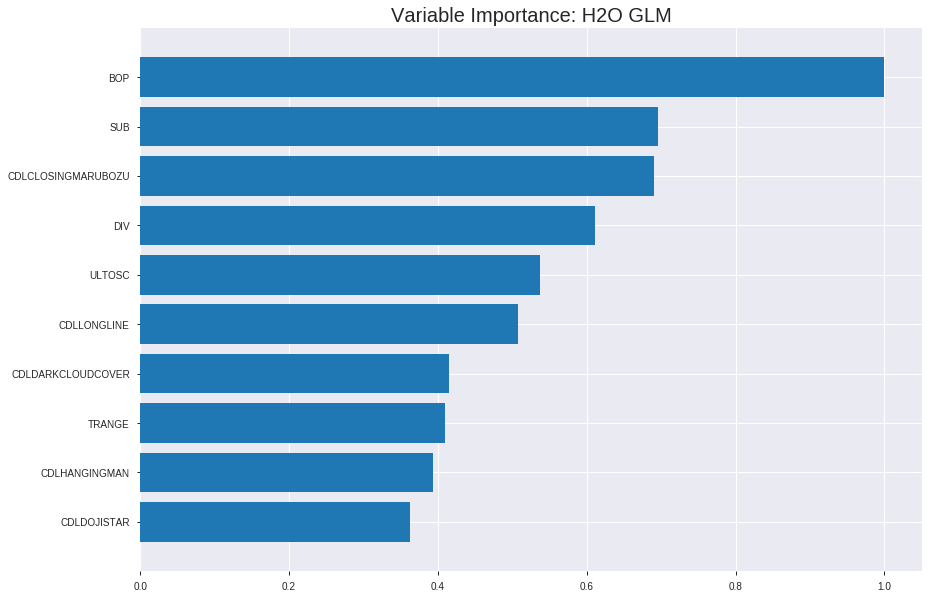

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_183155_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18976144598098563
RMSE: 0.435616168181331
LogLoss: 0.5613360632185843
Null degrees of freedom: 1752
Residual degrees of freedom: 713
Null deviance: 2428.4481185881305
Residual deviance: 1968.0442376443566
AIC: 4048.0442376443566
AUC: 0.7885357057235478
pr_auc: 0.7838609234981492
Gini: 0.5770714114470956
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3846380690800011: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      390  459   0.5406   (459.0/849.0)
1      78   826   0.0863   (78.0/904.0)
Total  468  1285  0.3063   (537.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384638     0.754683  268
max f2                       0.165271     0.853404  360
max f0point5                 0.592741     0.730728  155
max accuracy                 0.483734     0.714775  216
max precision                0.946862     1         0
max recall                   0.0910855    1         387
max specificity              0.946862     1         0
max absolute_mcc             0.446453     0.43404   238
max min_per_class_accuracy   0.53651      0.706714  189
max mean_per_class_accuracy  0.52343      0.71285   196

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.903069           1.83143   1.83143            0.944444         0.91768   0.944444                    0.91768             0.0188053       0.0188053                  83.1428   83.1428
    2        0.0205362                   0.867933           1.83143   1.83143            0.944444         0.883462  0.944444                    0.900571            0.0188053       0.0376106                  83.1428   83.1428
    3        0.0302339                   0.855748           1.71102   1.79281            0.882353         0.861842  0.924528                    0.888149            0.0165929       0.0542035                  71.1023   79.2808
    4        0.040502                    0.840463           1.61597   1.74797            0.833333         0.846223  0.901408                    0.87752             0.0165929       0.0707965                  61.5966   74.7975
    5        0.0501997                   0.824514           1.59695   1.7188             0.823529         0.832674  0.886364                    0.868856            0.0154867       0.0862832                  59.6955   71.88
    6        0.100399                    0.768257           1.7188    1.7188             0.886364         0.793973  0.886364                    0.831414            0.0862832       0.172566                   71.88     71.88
    7        0.150029                    0.732115           1.6494    1.69584            0.850575         0.750927  0.874525                    0.804789            0.0818584       0.254425                   64.94     69.5843
    8        0.200228                    0.702618           1.45437   1.6353             0.75             0.716239  0.843305                    0.782589            0.0730088       0.327434                   45.4369   63.5302
    9        0.300057                    0.643341           1.44052   1.5705             0.742857         0.670731  0.809886                    0.745374            0.143805        0.471239                   44.0518   57.0498
    10       0.399886                    0.593917           1.2743    1.49656            0.657143         0.617378  0.771755                    0.71342             0.127212        0.598451                   27.4305   49.6555
    11       0.500285                    0.540413           1.02467   1.40186            0.528409         0.565698  0.722919                    0.683775            0.102876        0.701327                   2.46694   40.1855
    12       0.600114                    0.475732           1.03052   1.34008            0.531429         0.508496  0.691065                    0.654617            0.102876        0.804204                   3.05247   34.0084
    13       0.699943                    0.409561           0.797826  1.26275            0.411429         0.444231  0.651182                    0.624611            0.079646        0.88385                    -20.2174  26.2745
    14       0.799772                    0.322905           0.576207  1.17705            0.297143         0.367059  0.60699                     0.592463            0.0575221       0.941372                   -42.3793  17.705
    15       0.899601                    0.217376           0.321346  1.08209            0.165714         0.271048  0.558022                    0.556796            0.0320796       0.973451                   -67.8654  8.20927
    16       1                           0.00746893         0.264431  1                  0.136364         0.147349  0.515687                    0.515687            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21142347406713533
RMSE: 0.4598080839514844
LogLoss: 0.612686872249427
Null degrees of freedom: 500
Residual degrees of freedom: -539
Null deviance: 694.0853381814004
Residual deviance: 613.9122459939258
AIC: 2693.912245993926
AUC: 0.7273343541646728
pr_auc: 0.7018453701082432
Gini: 0.4546687083293457
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4476969013666445: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  125  0.5144   (125.0/243.0)
1      35   223  0.1357   (35.0/258.0)
Total  153  348  0.3194   (160.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447697     0.735974  270
max f2                       0.246436     0.850706  359
max f0point5                 0.570559     0.68595   186
max accuracy                 0.447697     0.680639  270
max precision                0.85247      0.818182  9
max recall                   0.0957805    1         394
max specificity              0.913634     0.995885  0
max absolute_mcc             0.447697     0.379724  270
max min_per_class_accuracy   0.554186     0.662791  197
max mean_per_class_accuracy  0.447697     0.674969  270

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 53.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.864854           1.29457   1.29457            0.666667         0.895009  0.666667                    0.895009            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.852343           1.94186   1.58879            1                0.856865  0.818182                    0.877671            0.0193798       0.0348837                  94.186    58.8795
    3        0.0319361                   0.837454           1.55349   1.57776            0.8              0.843775  0.8125                      0.867078            0.0155039       0.0503876                  55.3488   57.7762
    4        0.0419162                   0.819097           1.16512   1.47951            0.6              0.826993  0.761905                    0.857534            0.0116279       0.0620155                  16.5116   47.9513
    5        0.0518962                   0.809122           1.16512   1.41905            0.6              0.812688  0.730769                    0.84891             0.0116279       0.0736434                  16.5116   41.9052
    6        0.101796                    0.760017           1.63116   1.52303            0.84             0.777927  0.784314                    0.814114            0.0813953       0.155039                   63.1163   52.3028
    7        0.151697                    0.723848           1.47581   1.5075             0.76             0.738812  0.776316                    0.789344            0.0736434       0.228682                   47.5814   50.7497
    8        0.201597                    0.693909           1.47581   1.49965            0.76             0.705932  0.772277                    0.768697            0.0736434       0.302326                   47.5814   49.9655
    9        0.301397                    0.646744           1.28163   1.42746            0.66             0.671551  0.735099                    0.73653             0.127907        0.430233                   28.1628   42.746
    10       0.401198                    0.60008            1.28163   1.39118            0.66             0.622842  0.716418                    0.708249            0.127907        0.55814                    28.1628   39.1184
    11       0.500998                    0.555542           1.00977   1.3152             0.52             0.578638  0.677291                    0.68243             0.100775        0.658915                   0.976744  31.5204
    12       0.600798                    0.506093           0.97093   1.25802            0.5              0.527855  0.647841                    0.656753            0.0968992       0.755814                   -2.90698  25.8016
    13       0.700599                    0.440574           1.08744   1.23372            0.56             0.474108  0.635328                    0.630736            0.108527        0.864341                   8.74419   23.3718
    14       0.800399                    0.360789           0.582558  1.15253            0.3              0.401615  0.593516                    0.602167            0.0581395       0.922481                   -41.7442  15.2526
    15       0.9002                      0.271105           0.466047  1.07642            0.24             0.319704  0.554324                    0.570852            0.0465116       0.968992                   -53.3953  7.64193
    16       1                           0.039369           0.310698  1                  0.16             0.17741   0.51497                     0.531586          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 18:31:59  0.000 sec   2            .17E2     1040          1.348520385876925   1.3629965653107503
     2019-08-27 18:32:01  2.154 sec   4            .13E2     1040          1.340720392869865   1.3578535308167499
     2019-08-27 18:32:03  4.296 sec   6            .92E1     1040          1.3311973924312122  1.3514681417795216
     2019-08-27 18:32:05  6.429 sec   8            .67E1     1040          1.3200953311869503  1.3439077877172396
     2019-08-27 18:32:07  8.548 sec   10           .49E1     1040          1.3072806586321657  1.3349975448228957
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 18:32:36  37.122 sec  36           .78E-1    1040          1.1134370897311057  1.226787248985952
     2019-08-27 18:32:38  39.283 sec  38           .57E-1    1040          1.1052915113827364  1.2301537866915124
     2019-08-27 18:32:40  41.400 sec  40           .41E-1    1040          1.0980684222909558  1.235080273893504
     2019-08-27 18:32:42  43.747 sec  42           .3E-1     1040          1.0915310285456654  1.2412332504866588
     2019-08-27 18:32:45  46.044 sec  44           .22E-1    1040          1.0856025113740633  1.2479916195174683


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6573705179282868)

('F1', 0.7192429022082019)

('auc', 0.6930705657978385)

('logloss', 0.6417400864866373)

('mean_per_class_error', 0.34392879847425295)

('rmse', 0.4742472236700679)

('mse', 0.22491042915876738)

glm prediction progress: |████████████████████████████████████████████████| 100%


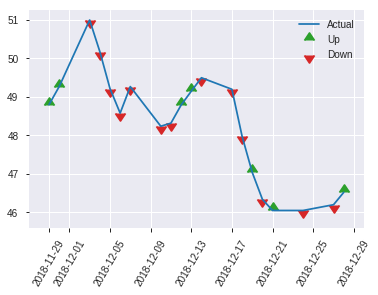


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22491042915876738
RMSE: 0.4742472236700679
LogLoss: 0.6417400864866373
Null degrees of freedom: 250
Residual degrees of freedom: -789
Null deviance: 347.642153441148
Residual deviance: 322.15352341629193
AIC: 2402.153523416292
AUC: 0.6930705657978385
pr_auc: 0.6639590833834599
Gini: 0.3861411315956771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3307601998356002: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   73   0.6033   (73.0/121.0)
1      16   114  0.1231   (16.0/130.0)
Total  64   187  0.3546   (89.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33076      0.719243  186
max f2                       0.129574     0.85639   238
max f0point5                 0.461722     0.667656  135
max accuracy                 0.461722     0.657371  135
max precision                0.978571     1         0
max recall                   0.129574     1         238
max specificity              0.978571     1         0
max absolute_mcc             0.365018     0.322441  178
max min_per_class_accuracy   0.476183     0.644628  126
max mean_per_class_accuracy  0.461722     0.656071  135

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 48.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.943381           1.93077   1.93077            1                0.971234  1                           0.971234            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.90275            0.64359   1.28718            0.333333         0.913982  0.666667                    0.942608            0.00769231      0.0307692                  -35.641   28.7179
    3        0.0318725                   0.882269           1.93077   1.44808            1                0.885751  0.75                        0.928394            0.0153846       0.0461538                  93.0769   44.8077
    4        0.0438247                   0.854047           1.93077   1.57972            1                0.870394  0.818182                    0.912576            0.0230769       0.0692308                  93.0769   57.972
    5        0.0517928                   0.828295           0.965385  1.48521            0.5              0.83431   0.769231                    0.900535            0.00769231      0.0769231                  -3.46154  48.5207
    6        0.103586                    0.76611            1.03964   1.26243            0.538462         0.792373  0.653846                    0.846454            0.0538462       0.130769                   3.9645    26.2426
    7        0.151394                    0.726536           1.12628   1.21943            0.583333         0.746352  0.631579                    0.814843            0.0538462       0.184615                   12.6282   21.9433
    8        0.203187                    0.672481           1.78225   1.3629             0.923077         0.697221  0.705882                    0.784861            0.0923077       0.276923                   78.2249   36.2896
    9        0.302789                    0.595326           1.31292   1.34646            0.68             0.630532  0.697368                    0.734095            0.130769        0.407692                   31.2923   34.6457
    10       0.40239                     0.538931           1.31292   1.33816            0.68             0.565082  0.693069                    0.69226             0.130769        0.538462                   31.2923   33.8157
    11       0.501992                    0.476427           1.004     1.27186            0.52             0.508803  0.65873                     0.65586             0.1             0.638462                   0.4       27.1856
    12       0.601594                    0.434874           0.926769  1.21472            0.48             0.456516  0.629139                    0.622856            0.0923077       0.730769                   -7.32308  21.4722
    13       0.701195                    0.371119           1.08123   1.19576            0.56             0.392844  0.619318                    0.590184            0.107692        0.838462                   8.12308   19.576
    14       0.800797                    0.310752           0.617846  1.12388            0.32             0.33476   0.58209                     0.558415            0.0615385       0.9                        -38.2154  12.3881
    15       0.900398                    0.187921           0.695077  1.07645            0.36             0.251812  0.557522                    0.524498            0.0692308       0.969231                   -30.4923  7.64466
    16       1                           0.0492845          0.308923  1                  0.16             0.128715  0.517928                    0.485078           

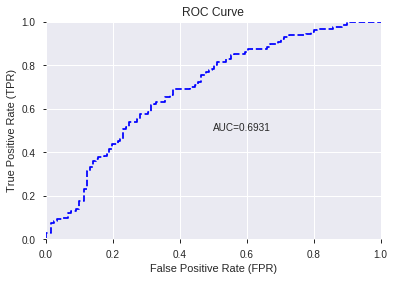

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


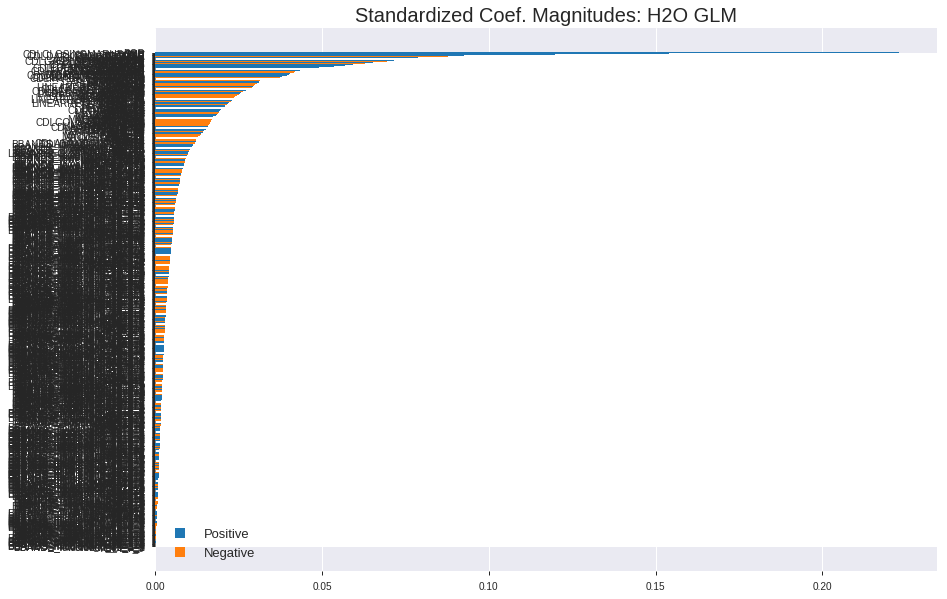

'log_likelihood'
--2019-08-27 18:33:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_183155_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_183155_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

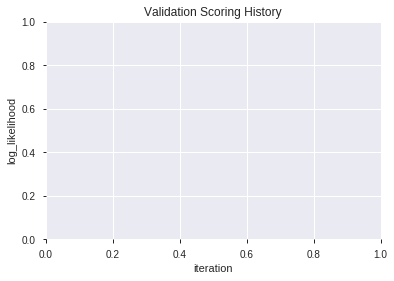

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_183318_model_7  0.738907  0.608471              0.356929  0.459231  0.210893
1  XGBoost_grid_1_AutoML_20190827_183318_model_1  0.736109  0.611949              0.305912  0.460183  0.211768
2  XGBoost_grid_1_AutoML_20190827_183318_model_4  0.728036  0.612636              0.335124  0.460594  0.212147
3               XGBoost_3_AutoML_20190827_183318  0.727654  0.622413              0.325429  0.465831  0.216998
4               XGBoost_2_AutoML_20190827_183318  0.720534  0.621066              0.327146  0.465079  0.216298
5  XGBoost_grid_1_AutoML_20190827_183318_model_2  0.720025  0.621487              0.338970  0.464600  0.215853
6  XGBoost_grid_1_AutoML_20190827_183318_model_6  0.715957  0.626884              0.334266  0.468303  0.219308
7               XGBoost_1_AutoML_20190827_183318  0.706612  0.634092              0.329561  0.471725  0.222524
8  XGBoost_grid_1_AutoML_20190827_183318_model_3  0.705658  0.629764              0.417069  0.469724  0.220641
9  XGBoost_grid_1_AutoML_20190827_183318_model_5  0.702161  0.640211              0.385855  0.474096  0.224767

variable  relative_importance  scaled_importance  percentage
0                        BOP          1216.238037           1.000000    0.104026
1               STOCHF_fastk           544.176086           0.447426    0.046544
2                        SUB           386.860535           0.318080    0.033089
3                        DIV           311.641724           0.256234    0.026655
4                     ULTOSC           203.784988           0.167554    0.017430
..                       ...                  ...                ...         ...
449             aroondown_20             0.663631           0.000546    0.000057
450  BBANDS_upperband_12_3_5             0.532827           0.000438    0.000046
451       LINEARREG_ANGLE_24             0.524195           0.000431    0.000045
452  BBANDS_lowerband_20_1_5             0.463463           0.000381    0.000040
453       LINEARREG_SLOPE_20             0.353218           0.000290    0.000030

[454 rows x 4 columns]

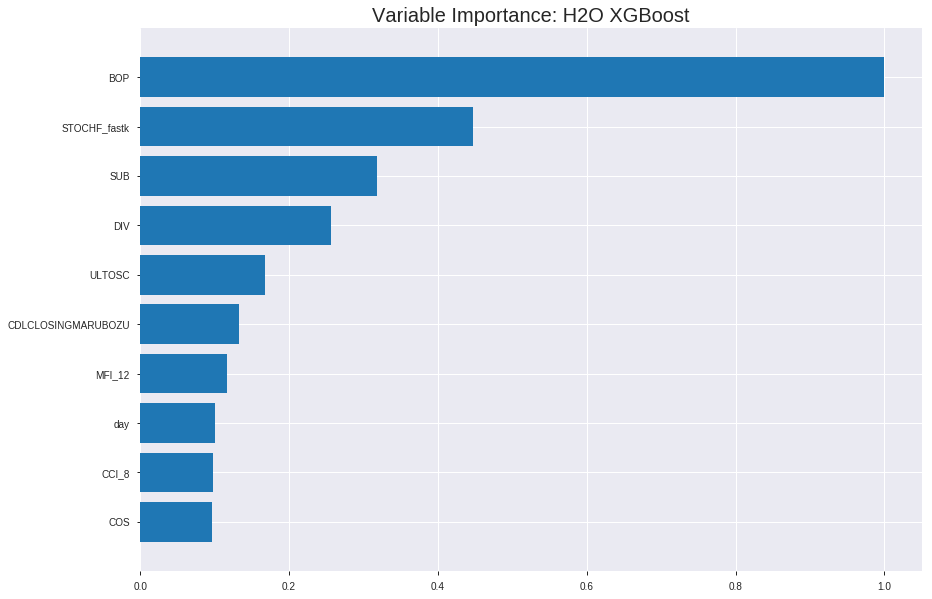

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_183318_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10002949726358273
RMSE: 0.31627440184684996
LogLoss: 0.3583328376580664
Mean Per-Class Error: 0.0747847545785254
AUC: 0.979317807519518
pr_auc: 0.9798282923349974
Gini: 0.958635615039036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5200008749961853: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      784  65   0.0766   (65.0/849.0)
1      66   838  0.073    (66.0/904.0)
Total  850  903  0.0747   (131.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520001     0.927504  197
max f2                       0.464858     0.945858  218
max f0point5                 0.575785     0.944444  172
max accuracy                 0.520001     0.925271  197
max precision                0.928049     1         0
max recall                   0.229243     1         325
max specificity              0.928049     1         0
max absolute_mcc             0.520001     0.850401  197
max min_per_class_accuracy   0.522836     0.923439  196
max mean_per_class_accuracy  0.520001     0.925215  197

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.905836           1.93916    1.93916            1                0.914902  1                           0.914902            0.0199115       0.0199115                  93.9159   93.9159
    2        0.0205362                   0.889885           1.93916    1.93916            1                0.897806  1                           0.906354            0.0199115       0.039823                   93.9159   93.9159
    3        0.0302339                   0.87392            1.93916    1.93916            1                0.881634  1                           0.898425            0.0188053       0.0586283                  93.9159   93.9159
    4        0.040502                    0.867271           1.93916    1.93916            1                0.870301  1                           0.891295            0.0199115       0.0785398                  93.9159   93.9159
    5        0.0501997                   0.861002           1.93916    1.93916            1                0.864031  1                           0.886028            0.0188053       0.0973451                  93.9159   93.9159
    6        0.100399                    0.830457           1.93916    1.93916            1                0.84833   1                           0.867179            0.0973451       0.19469                    93.9159   93.9159
    7        0.150029                    0.79991            1.93916    1.93916            1                0.816158  1                           0.850301            0.0962389       0.290929                   93.9159   93.9159
    8        0.200228                    0.775047           1.93916    1.93916            1                0.786587  1                           0.834327            0.0973451       0.388274                   93.9159   93.9159
    9        0.300057                    0.716981           1.93916    1.93916            1                0.749241  1                           0.806019            0.193584        0.581858                   93.9159   93.9159
    10       0.399886                    0.649036           1.82835    1.9115             0.942857         0.686028  0.985735                    0.776064            0.182522        0.764381                   82.835    91.1497
    11       0.500285                    0.536249           1.45437    1.81976            0.75             0.59056   0.938426                    0.738836            0.146018        0.910398                   45.4369   81.9758
    12       0.600114                    0.421955           0.620531   1.62027            0.32             0.476618  0.835551                    0.695217            0.0619469       0.972345                   -37.9469  62.0267
    13       0.699943                    0.327543           0.221618   1.42079            0.114286         0.371512  0.732681                    0.649048            0.0221239       0.994469                   -77.8382  42.0786
    14       0.799772                    0.246336           0.0443236  1.24897            0.0228571        0.289587  0.64408                     0.60418             0.00442478      0.998894                   -95.5676  24.8973
    15       0.899601                    0.156112           0.0110809  1.1116             0.00571429       0.202093  0.57324                     0.55956             0.00110619      1                          -98.8919  11.1604
    16       1                           0.0575763          0          1                  0                0.119255  0.515687                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21754151970526842
RMSE: 0.466413464326737
LogLoss: 0.6253996436536504
Mean Per-Class Error: 0.3357737582543785
AUC: 0.7080900883657129
pr_auc: 0.6960248819283795
Gini: 0.4161801767314257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3102143108844757: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      77   166  0.6831   (166.0/243.0)
1      23   235  0.0891   (23.0/258.0)
Total  100  401  0.3772   (189.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310214     0.713202  310
max f2                       0.127169     0.847012  390
max f0point5                 0.557477     0.67753   171
max accuracy                 0.499237     0.664671  208
max precision                0.892603     1         0
max recall                   0.127169     1         390
max specificity              0.892603     1         0
max absolute_mcc             0.557477     0.32976   171
max min_per_class_accuracy   0.525594     0.658915  192
max mean_per_class_accuracy  0.557477     0.664226  171

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.832422           1.61822   1.61822            0.833333         0.848744  0.833333                    0.848744            0.0193798       0.0193798                  61.8217   61.8217
    2        0.0219561                   0.804601           1.55349   1.58879            0.8              0.811888  0.818182                    0.831991            0.0155039       0.0348837                  55.3488   58.8795
    3        0.0319361                   0.79851            1.16512   1.4564             0.6              0.800945  0.75                        0.822289            0.0116279       0.0465116                  16.5116   45.6395
    4        0.0419162                   0.793397           1.94186   1.57198            1                0.79563   0.809524                    0.815942            0.0193798       0.0658915                  94.186    57.1982
    5        0.0518962                   0.790278           1.55349   1.56843            0.8              0.791224  0.807692                    0.811188            0.0155039       0.0813953                  55.3488   56.8426
    6        0.101796                    0.756703           1.70884   1.63725            0.88             0.775607  0.843137                    0.793746            0.0852713       0.166667                   70.8837   63.7255
    7        0.151697                    0.726179           1.00977   1.43084            0.52             0.738988  0.736842                    0.775734            0.0503876       0.217054                   0.976744  43.0845
    8        0.201597                    0.685147           1.47581   1.44198            0.76             0.707435  0.742574                    0.758828            0.0736434       0.290698                   47.5814   44.1976
    9        0.301397                    0.637931           1.3593    1.4146             0.7              0.661678  0.728477                    0.726659            0.135659        0.426357                   35.9302   41.46
    10       0.401198                    0.581391           1.28163   1.38152            0.66             0.607119  0.711443                    0.696923            0.127907        0.554264                   28.1628   38.1523
    11       0.500998                    0.530239           1.00977   1.30747            0.52             0.557649  0.673307                    0.669179            0.100775        0.655039                   0.976744  30.7468
    12       0.600798                    0.462238           0.932093  1.24511            0.48             0.490438  0.641196                    0.639488            0.0930233       0.748062                   -6.7907   24.5113
    13       0.700599                    0.397393           0.776744  1.17839            0.4              0.429682  0.606838                    0.609601            0.0775194       0.825581                   -22.3256  17.8394
    14       0.800399                    0.310187           0.854419  1.138              0.44             0.347434  0.586035                    0.576912            0.0852713       0.910853                   -14.5581  13.7998
    15       0.9002                      0.20854            0.427209  1.0592             0.22             0.260224  0.545455                    0.541802            0.0426357       0.953488                   -57.2791  5.91966
    16       1                           0.0960483          0.466047  1                  0.24             0.159689  0.51497                     0.503667           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:34:15  36.693 sec  0                  0.5              0.693147            0.5             0                  1                0.484313                         0.5                0.693147              0.5               0                    1                  0.48503
    2019-08-27 18:34:16  37.933 sec  5                  0.468652         0.632004            0.866623        0.861912           1.7237           0.22761                          0.485926           0.665221              0.690696          0.685934             1.61822            0.427146
    2019-08-27 18:34:16  38.280 sec  10                 0.440354         0.5787              0.898908        0.902046           1.93916          0.183685                         0.475608           0.644784              0.713298          0.706238             1.94186            0.363273
    2019-08-27 18:34:17  38.610 sec  15                 0.419192         0.539441            0.914431        0.918935           1.93916          0.166572                         0.471048           0.635526              0.71329           0.701491             1.61822            0.359281
    2019-08-27 18:34:17  38.933 sec  20                 0.400633         0.505592            0.932521        0.937742           1.93916          0.147747                         0.469251           0.63158               0.710953          0.703152             1.61822            0.367265
    2019-08-27 18:34:17  39.301 sec  25                 0.385058         0.477045            0.939698        0.945356           1.93916          0.143754                         0.467609           0.628149              0.709239          0.69206              1.61822            0.391218
    2019-08-27 18:34:18  39.616 sec  30                 0.370851         0.451597            0.949888        0.955267           1.93916          0.12607                          0.466827           0.626207              0.708577          0.697286             1.61822            0.393214
    2019-08-27 18:34:18  39.974 sec  35                 0.357483         0.428052            0.958118        0.962804           1.93916          0.110667                         0.463531           0.619048              0.716464          0.714026             1.94186            0.369261
    2019-08-27 18:34:18  40.270 sec  40                 0.346826         0.409442            0.964157        0.967919           1.93916          0.103822                         0.464962           0.621401              0.709956          0.708189             1.94186            0.359281
    2019-08-27 18:34:19  40.587 sec  45                 0.337122         0.392575            0.968574        0.971803           1.93916          0.0964062                        0.464274           0.620086              0.712413          0.704917             1.94186            0.367265
    2019-08-27 18:34:19  40.889 sec  50                 0.326741         0.375455            0.974821        0.976042           1.93916          0.0827153                        0.464737           0.621561              0.712205          0.699869             1.61822            0.367265
    2019-08-27 18:34:19  41.209 sec  55                 0.316274         0.358333            0.979318        0.979828           1.93916          0.074729                         0.466413           0.6254                0.70809           0.

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1216.238037109375      1.0                     0.10402599272971742
STOCHF_fastk             544.1760864257812      0.4474256435188633      0.04654389673978242
SUB                      386.86053466796875     0.3180796216400349      0.03308854840819754
DIV                      311.6417236328125      0.2562341532858891      0.026655012166823203
ULTOSC                   203.7849884033203      0.16755353983801952     0.017429923317028237
---                      ---                    ---                     ---
aroondown_20             0.6636314392089844     0.0005456427269666988   5.6761026348461e-05
BBANDS_upperband_12_3_5  0.5328273773193359     0.0004380946501111767   4.5573230887393364e-05
LINEARREG_ANGLE_24       0.5241947174072266     0.00043099681264127925  4.48348712983531e-05
BBANDS_lowerband_20_1_5  0.46346282958984375    0.00038106260078113723  3.9640415338425795e-05
LINEARREG_SLOPE_20       0.35321807861328125    0.0002904185429463893   3.021107723711622e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.735562310030395)

('auc', 0.738906547997457)

('logloss', 0.6084706698158333)

('mean_per_class_error', 0.30289256198347103)

('rmse', 0.4592307852434673)

('mse', 0.21089291411533156)

xgboost prediction progress: |████████████████████████████████████████████| 100%


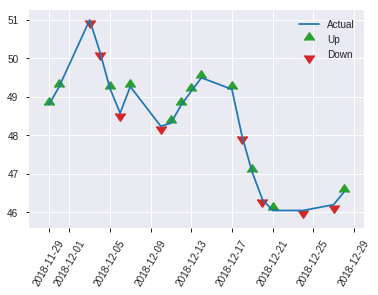


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21089291411533156
RMSE: 0.4592307852434673
LogLoss: 0.6084706698158333
Mean Per-Class Error: 0.30289256198347103
AUC: 0.738906547997457
pr_auc: 0.7210596720305613
Gini: 0.47781309599491406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2783363163471222: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   78   0.6446   (78.0/121.0)
1      9    121  0.0692   (9.0/130.0)
Total  52   199  0.3466   (87.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.278336     0.735562  198
max f2                       0.14431      0.85752   237
max f0point5                 0.489006     0.716846  106
max accuracy                 0.442093     0.697211  127
max precision                0.865899     1         0
max recall                   0.14431      1         237
max specificity              0.865899     1         0
max absolute_mcc             0.489006     0.396322  106
max min_per_class_accuracy   0.442093     0.694215  127
max mean_per_class_accuracy  0.442093     0.697107  127

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 45.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.788631           1.93077   1.93077            1                0.839601  1                           0.839601            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.751307           1.93077   1.93077            1                0.762117  1                           0.800859            0.0230769       0.0461538                  93.0769   93.0769
    3        0.0318725                   0.742366           1.93077   1.93077            1                0.746853  1                           0.787357            0.0153846       0.0615385                  93.0769   93.0769
    4        0.0438247                   0.739731           0.64359   1.57972            0.333333         0.740729  0.818182                    0.77464             0.00769231      0.0692308                  -35.641   57.972
    5        0.0517928                   0.730758           0.965385  1.48521            0.5              0.733551  0.769231                    0.768319            0.00769231      0.0769231                  -3.46154  48.5207
    6        0.103586                    0.689984           1.48521   1.48521            0.769231         0.71073   0.769231                    0.739524            0.0769231       0.153846                   48.5207   48.5207
    7        0.151394                    0.666984           1.60897   1.52429            0.833333         0.680196  0.789474                    0.720789            0.0769231       0.230769                   60.8974   52.4291
    8        0.203187                    0.641702           1.03964   1.40075            0.538462         0.65514   0.72549                     0.704055            0.0538462       0.284615                   3.9645    40.0754
    9        0.302789                    0.590146           1.46738   1.42267            0.76             0.609156  0.736842                    0.672838            0.146154        0.430769                   46.7385   42.2672
    10       0.40239                     0.515231           1.46738   1.43374            0.76             0.554071  0.742574                    0.643441            0.146154        0.576923                   46.7385   43.374
    11       0.501992                    0.443197           1.08123   1.3638             0.56             0.472801  0.706349                    0.609583            0.107692        0.684615                   8.12308   36.3797
    12       0.601594                    0.39919            0.849538  1.27866            0.44             0.422915  0.662252                    0.578678            0.0846154       0.769231                   -15.0462  27.8655
    13       0.701195                    0.330899           0.772308  1.20673            0.4              0.364846  0.625                       0.548304            0.0769231       0.846154                   -22.7692  20.6731
    14       0.800797                    0.268685           0.849538  1.1623             0.44             0.300247  0.60199                     0.517451            0.0846154       0.930769                   -15.0462  16.2304
    15       0.900398                    0.186689           0.463385  1.08499            0.24             0.225653  0.561947                    0.485173            0.0461538       0.976923                   -53.6615  8.49898
    16       1                           0.0913325          0.231692  1                  0.12             0.142976  0.517928                    0.451089           

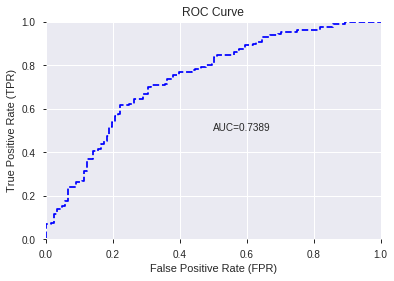

This function is available for GLM models only


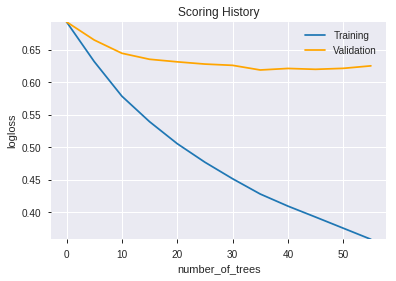

--2019-08-27 18:34:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedT

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_183318_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_183318_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_183430_model_9  0.755245  0.597782              0.339828  0.453405  0.205576
1  DeepLearning_grid_1_AutoML_20190827_183430_model_6  0.738207  0.606656              0.365766  0.457198  0.209030
2  DeepLearning_grid_1_AutoML_20190827_183430_model_7  0.728671  0.648324              0.345105  0.469699  0.220617
3               DeepLearning_1_AutoML_20190827_183430  0.726701  0.634293              0.400254  0.468213  0.219223
4  DeepLearning_grid_1_AutoML_20190827_183430_model_8  0.716910  0.617057              0.374603  0.462956  0.214328
5  DeepLearning_grid_1_AutoML_20190827_183430_model_3  0.693198  0.760255              0.390273  0.493989  0.244026
6  DeepLearning_grid_1_AutoML_20190827_183430_model_5  0.682390  0.641578              0.360490  0.471609  0.222415
7  DeepLearning_grid_1_AutoML_20190827_183430_model_1  0.638652  1.087128              0.400254  0.557362  0.310652
8  DeepLearning_grid_1_AutoML_20190827_183430_model_2  0.637889  0.935443              0.420057  0.540922  0.292596
9  DeepLearning_grid_1_AutoML_20190827_183430_model_4  0.637063  0.867865              0.420629  0.533800  0.284942

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.034012
1                  BOP             0.843956           0.843956    0.028704
2          CDLLONGLINE             0.796320           0.796320    0.027084
3                  SUB             0.720936           0.720936    0.024520
4        CDLHANGINGMAN             0.703891           0.703891    0.023940
5               ULTOSC             0.702991           0.702991    0.023910
6               TRANGE             0.658672           0.658672    0.022402
7           aroonup_30             0.635049           0.635049    0.021599
8                  day             0.633293           0.633293    0.021539
9                  DIV             0.612957           0.612957    0.020848
10           CDLTAKURI             0.610555           0.610555    0.020766
11        weekday_name             0.601453           0.601453    0.020456
12         CDLMARUBOZU             0.590565           0.590565    0.020086
13      CDLRICKSHAWMAN             0.590461           0.590461    0.020083
14      CDLMORNINGSTAR             0.589447           0.589447    0.020048
15        CDLENGULFING             0.587901           0.587901    0.019995
16              MFI_12             0.586989           0.586989    0.019964
17   CDLDARKCLOUDCOVER             0.578461           0.578461    0.019674
18               DX_14             0.576940           0.576940    0.019623
19              CCI_12             0.575783           0.575783    0.019583
20         AROONOSC_12             0.573790           0.573790    0.019515
21              MFI_14             0.570803           0.570803    0.019414
22    CDLDRAGONFLYDOJI             0.569293           0.569293    0.019363
23               DX_12             0.566610           0.566610    0.019271
24      CDLSPINNINGTOP             0.566371           0.566371    0.019263
25              MFI_20             0.562379           0.562379    0.019127
26              SAREXT             0.558550           0.558550    0.018997
27      STOCHRSI_fastk             0.558040           0.558040    0.018980
28        STOCHF_fastk             0.556490           0.556490    0.018927
29               ADOSC             0.554082           0.554082    0.018845
30        HT_TRENDMODE             0.553666           0.553666    0.018831
31            WILLR_30             0.551354           0.551354    0.018752
32           aroonup_8             0.546719           0.546719    0.018595
33                DX_8             0.543390           0.543390    0.018482
34   HT_PHASOR_inphase             0.541313           0.541313    0.018411
35           dayofweek             0.538937           0.538937    0.018330
36         CDLBELTHOLD             0.535338           0.535338    0.018208
37             WILLR_8             0.531899           0.531899    0.018091
38            CORREL_8             0.531074           0.531074    0.018063
39             weekday             0.529865           0.529865    0.018022
40         STOCH_slowd             0.527726           0.527726    0.017949
41             CDLDOJI             0.526772           0.526772    0.017916
42          PLUS_DI_14             0.523755           0.523755    0.017814
43            WILLR_20             0.523225           0.523225    0.017796
44            WILLR_24             0.519225           0.519225    0.017660
45            WILLR_14             0.517667           0.517667    0.017607
46        is_month_end             0.513015           0.513015    0.017448
47          CDLHIKKAKE             0.508893           0.508893    0.017308
48   CDLLONGLEGGEDDOJI             0.503401           0.503401    0.017121
49            WILLR_12             0.501495           0.501495    0.017057

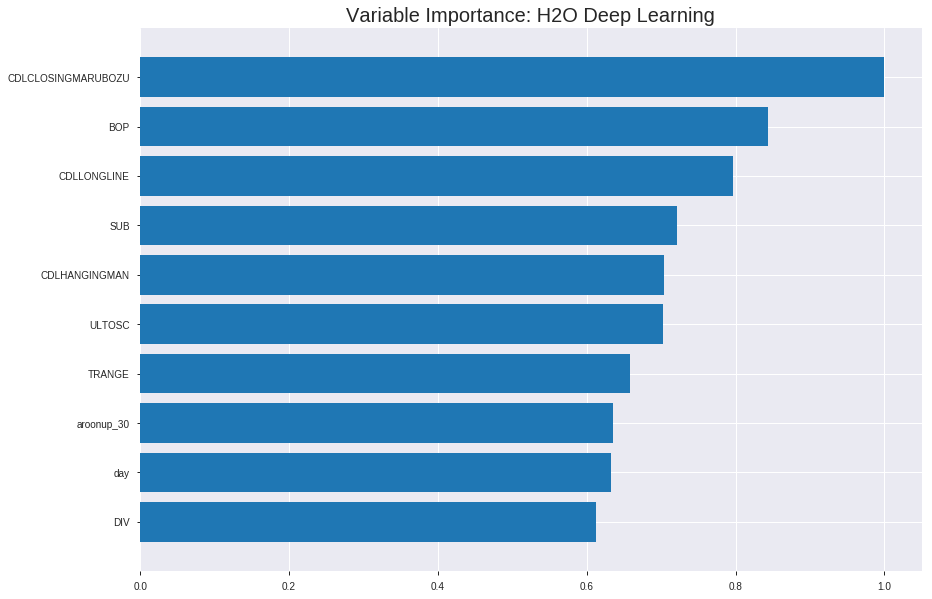

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_183430_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19924062558564748
RMSE: 0.4463637816687724
LogLoss: 0.5827369204574083
Mean Per-Class Error: 0.30520289356556907
AUC: 0.7681004200673358
pr_auc: 0.7636969710805929
Gini: 0.5362008401346716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3988209505391676: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  469   0.5524   (469.0/849.0)
1      97   807   0.1073   (97.0/904.0)
Total  477  1276  0.3229   (566.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398821     0.740367  253
max f2                       0.22614      0.851375  322
max f0point5                 0.550508     0.710756  155
max accuracy                 0.474942     0.69595   209
max precision                0.913819     1         0
max recall                   0.0952603    1         377
max specificity              0.913819     1         0
max absolute_mcc             0.451582     0.395239  224
max min_per_class_accuracy   0.491586     0.69258   196
max mean_per_class_accuracy  0.49715      0.694797  192

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 47.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.852375           1.61597   1.61597            0.833333         0.877174  0.833333                    0.877174            0.0165929       0.0165929                  61.5966   61.5966
    2        0.0205362                   0.828437           1.7237    1.66983            0.888889         0.835825  0.861111                    0.856499            0.0176991       0.034292                   72.3697   66.9832
    3        0.0302339                   0.810812           1.71102   1.68304            0.882353         0.818897  0.867925                    0.844438            0.0165929       0.050885                   71.1023   68.3044
    4        0.040502                    0.799552           1.83143   1.72066            0.944444         0.804311  0.887324                    0.834265            0.0188053       0.0696903                  83.1428   72.0662
    5        0.0501997                   0.783964           1.59695   1.69676            0.823529         0.789868  0.875                       0.825688            0.0154867       0.085177                   59.6955   69.6764
    6        0.100399                    0.726228           1.80694   1.75185            0.931818         0.753397  0.903409                    0.789543            0.090708        0.175885                   80.6944   75.1854
    7        0.150029                    0.680158           1.56024   1.68847            0.804598         0.70045   0.870722                    0.760071            0.0774336       0.253319                   56.0243   68.8469
    8        0.200228                    0.641295           1.4103    1.61873            0.727273         0.66176   0.834758                    0.735423            0.0707965       0.324115                   41.0298   61.8728
    9        0.300057                    0.581304           1.35187   1.52995            0.697143         0.609811  0.788973                    0.693632            0.134956        0.459071                   35.1871   52.9945
    10       0.399886                    0.525368           1.2189    1.45229            0.628571         0.554167  0.74893                     0.658816            0.121681        0.580752                   21.89     45.2295
    11       0.500285                    0.493127           1.06874   1.37532            0.551136         0.506913  0.709236                    0.628331            0.107301        0.688053                   6.87412   37.5322
    12       0.600114                    0.468644           0.97512   1.30875            0.502857         0.481746  0.674905                    0.603947            0.0973451       0.785398                   -2.48799  30.8748
    13       0.699943                    0.42136            0.819987  1.23904            0.422857         0.44731   0.638957                    0.581607            0.0818584       0.867257                   -18.0013  23.9039
    14       0.799772                    0.309499           0.653774  1.16599            0.337143         0.369739  0.601284                    0.555161            0.0652655       0.932522                   -34.6226  16.5985
    15       0.899601                    0.162844           0.432155  1.08455            0.222857         0.238151  0.55929                     0.519982            0.0431416       0.975664                   -56.7845  8.4552
    16       1                           0.0222926          0.242395  1                  0.125            0.110196  0.515687                    0.47884           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21651005690066233
RMSE: 0.4653064118413396
LogLoss: 0.6225987057425745
Mean Per-Class Error: 0.3318260120585702
AUC: 0.7075637222062718
pr_auc: 0.6777457745873227
Gini: 0.4151274444125437
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4710575677446677: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  128  0.5267   (128.0/243.0)
1      37   221  0.1434   (37.0/258.0)
Total  152  349  0.3293   (165.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471058     0.728171  262
max f2                       0.13591      0.851064  372
max f0point5                 0.483502     0.671975  247
max accuracy                 0.483502     0.672655  247
max precision                0.841155     1         0
max recall                   0.0533638    1         398
max specificity              0.841155     1         0
max absolute_mcc             0.471058     0.358577  262
max min_per_class_accuracy   0.518696     0.633745  201
max mean_per_class_accuracy  0.483502     0.668174  247

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.812643           1.61822   1.61822            0.833333         0.82936   0.833333                    0.82936             0.0193798       0.0193798                  61.8217   61.8217
    2        0.0219561                   0.798515           1.16512   1.41226            0.6              0.801833  0.727273                    0.816848            0.0116279       0.0310078                  16.5116   41.2262
    3        0.0319361                   0.785438           1.55349   1.4564             0.8              0.793173  0.75                        0.809449            0.0155039       0.0465116                  55.3488   45.6395
    4        0.0419162                   0.773847           1.55349   1.47951            0.8              0.780584  0.761905                    0.802577            0.0155039       0.0620155                  55.3488   47.9513
    5        0.0518962                   0.767673           1.16512   1.41905            0.6              0.77068   0.730769                    0.796443            0.0116279       0.0736434                  16.5116   41.9052
    6        0.101796                    0.73408            1.47581   1.44688            0.76             0.748965  0.745098                    0.773169            0.0736434       0.147287                   47.5814   44.6876
    7        0.151697                    0.698912           1.55349   1.48195            0.8              0.714937  0.763158                    0.754014            0.0775194       0.224806                   55.3488   48.1946
    8        0.201597                    0.664006           1.47581   1.48043            0.76             0.683023  0.762376                    0.736442            0.0736434       0.29845                    47.5814   48.0428
    9        0.301397                    0.592562           1.12628   1.36316            0.58             0.625863  0.701987                    0.699826            0.112403        0.410853                   12.6279   36.316
    10       0.401198                    0.549317           1.24279   1.33322            0.64             0.570124  0.686567                    0.667562            0.124031        0.534884                   24.2791   33.3218
    11       0.500998                    0.519925           0.932093  1.25331            0.48             0.532511  0.645418                    0.640659            0.0930233       0.627907                   -6.7907   25.3312
    12       0.600798                    0.493385           1.24279   1.25156            0.64             0.503815  0.644518                    0.617928            0.124031        0.751938                   24.2791   25.1565
    13       0.700599                    0.468314           1.0486    1.22265            0.54             0.482707  0.62963                     0.598666            0.104651        0.856589                   4.86047   22.2653
    14       0.800399                    0.386963           0.582558  1.14284            0.3              0.433583  0.588529                    0.578082            0.0581395       0.914729                   -41.7442  14.2841
    15       0.9002                      0.199354           0.543721  1.07642            0.28             0.280026  0.554324                    0.545038            0.0542636       0.968992                   -45.6279  7.64193
    16       1                           0.0439626          0.310698  1                  0.16             0.126779  0.51497                     0.503295          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:41:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:41:30  2 min 30.982 sec  357 obs/sec       0.508272  1             891        0.488536         0.734452            0.0443889      0.735844        0.727599           1.83143          0.357673                         0.527069           0.882773              -0.112206        0.668437          0.636266             1.29457            0.377246
    2019-08-27 18:41:41  2 min 41.931 sec  736 obs/sec       5.19966   10            9115       0.447654         0.584978            0.197635       0.759621        0.753214           1.61597          0.331432                         0.468936           0.63078               0.119608         0.699979          0.665717             0.97093            0.351297
    2019-08-27 18:41:52  2 min 53.286 sec  881 obs/sec       11.3862   22            19960      0.446364         0.582737            0.202252       0.7681          0.763697           1.61597          0.322875                         0.465306           0.622599              0.133183         0.707564          0.677746             1.61822            0.329341
    2019-08-27 18:42:03  3 min  4.767 sec  985 obs/sec       18.5762   36            32564      0.442095         0.574459            0.217436       0.770465        0.763713           1.61597          0.31603                          0.477623           0.655732              0.0866864        0.698472          0.667774             1.29457            0.333333
    2019-08-27 18:42:14  3 min 15.738 sec  1079 obs/sec      26.4358   51            46342      0.439935         0.570292            0.225065       0.77797         0.770772           1.61597          0.312037                         0.468417           0.630302              0.121556         0.698711          0.667838             0.97093            0.373253
    2019-08-27 18:42:26  3 min 26.828 sec  1166 obs/sec      35.255    68            61802      0.436563         0.564642            0.236899       0.780702        0.771936           1.61597          0.310325                         0.475544           0.653778              0.0946183        0.697371          0.667592             0.97093            0.371257
    2019-08-27 18:42:37  3 min 37.851 sec  1243 obs/sec      44.6149   86            78210      0.434791         0.560898            0.243083       0.788454        0.781983           1.61597          0.29093                          0.47208            0.640948              0.107762         0.688981          0.651537             0.647287           0.349301
    2019-08-27 18:42:38  3 min 38.924 sec  1242 obs/sec      44.6149   86            78210      0.446364         0.582737            0.202252       0.7681          0.763697           1.61597          0.322875                         0.465306           0.622599              0.133183         0.707564          0.677746             1.61822            0.329341

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.03401157394682673
BOP                 0.843955934047699      0.843955934047699    0.02870426965872654
CDLLONGLINE         0.7963197231292725     0.7963197231292725   0.027084087148527843
SUB                 0.7209362387657166     0.7209362387657166   0.024520176195727304
CDLHANGINGMAN       0.7038914561271667     0.7038914561271667   0.023940456310608677
---                 ---                    ---                  ---
WILLR_14            0.5176666975021362     0.5176666975021362   0.017606659161903494
is_month_end        0.5130146741867065     0.5130146741867065   0.017448436526908393
CDLHIKKAKE          0.5088934302330017     0.5088934302330017   0.01730826653342405
CDLLONGLEGGEDDOJI   0.5034008026123047     0.5034008026123047   0.01712145362294033
WILLR_12            0.5014951825141907     0.5014951825141907   0.017056640484058767


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.7414330218068537)

('auc', 0.7552447552447553)

('logloss', 0.5977823425051821)

('mean_per_class_error', 0.29221233312142403)

('rmse', 0.45340540829563)

('mse', 0.20557646427172693)

deeplearning prediction progress: |███████████████████████████████████████| 100%


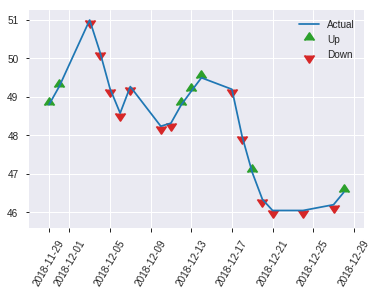


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20557646427172693
RMSE: 0.45340540829563
LogLoss: 0.5977823425051821
Mean Per-Class Error: 0.29221233312142403
AUC: 0.7552447552447553
pr_auc: 0.7343092636712686
Gini: 0.5104895104895106
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38459285853639613: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   72   0.595    (72.0/121.0)
1      11   119  0.0846   (11.0/130.0)
Total  60   191  0.3307   (83.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384593     0.741433  190
max f2                       0.155449     0.857909  225
max f0point5                 0.486916     0.715339  136
max accuracy                 0.486916     0.709163  136
max precision                0.737916     0.882353  16
max recall                   0.0890188    1         244
max specificity              0.86548      0.991736  0
max absolute_mcc             0.486916     0.417063  136
max min_per_class_accuracy   0.496379     0.68595   127
max mean_per_class_accuracy  0.486916     0.707788  136

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 47.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.841273           1.28718   1.28718            0.666667         0.856453  0.666667                    0.856453            0.0153846       0.0153846                  28.7179   28.7179
    2        0.0239044                   0.787679           1.93077   1.60897            1                0.808221  0.833333                    0.832337            0.0230769       0.0384615                  93.0769   60.8974
    3        0.0318725                   0.767812           1.93077   1.68942            1                0.77886   0.875                       0.818968            0.0153846       0.0538462                  93.0769   68.9423
    4        0.0438247                   0.754422           1.28718   1.57972            0.666667         0.759293  0.818182                    0.802693            0.0153846       0.0692308                  28.7179   57.972
    5        0.0517928                   0.745777           1.93077   1.63373            1                0.750636  0.846154                    0.794684            0.0153846       0.0846154                  93.0769   63.3728
    6        0.103586                    0.701986           1.63373   1.63373            0.846154         0.72452   0.846154                    0.759602            0.0846154       0.169231                   63.3728   63.3728
    7        0.151394                    0.657181           1.44808   1.5751             0.75             0.674485  0.815789                    0.732723            0.0692308       0.238462                   44.8077   57.5101
    8        0.203187                    0.618588           1.33669   1.51433            0.692308         0.639398  0.784314                    0.708934            0.0692308       0.307692                   33.6686   51.4329
    9        0.302789                    0.566654           1.62185   1.5497             0.84             0.589065  0.802632                    0.669503            0.161538        0.469231                   62.1846   54.9696
    10       0.40239                     0.5189             1.08123   1.43374            0.56             0.5364    0.742574                    0.636557            0.107692        0.576923                   8.12308   43.374
    11       0.501992                    0.496875           1.004     1.34847            0.52             0.50554   0.698413                    0.610562            0.1             0.676923                   0.4       34.8474
    12       0.601594                    0.477721           0.926769  1.27866            0.48             0.487139  0.662252                    0.590127            0.0923077       0.769231                   -7.32308  27.8655
    13       0.701195                    0.431025           0.926769  1.22867            0.48             0.45592   0.636364                    0.571064            0.0923077       0.861538                   -7.32308  22.8671
    14       0.800797                    0.32782            0.695077  1.1623             0.36             0.381016  0.60199                     0.547426            0.0692308       0.930769                   -30.4923  16.2304
    15       0.900398                    0.155449           0.540615  1.09353            0.28             0.248927  0.566372                    0.514406            0.0538462       0.984615                   -45.9385  9.3533
    16       1                           0.0580491          0.154462  1                  0.08             0.112226  0.517928                    0.474348            

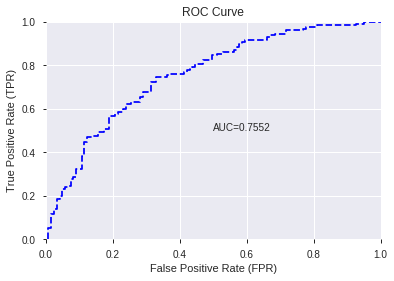

This function is available for GLM models only


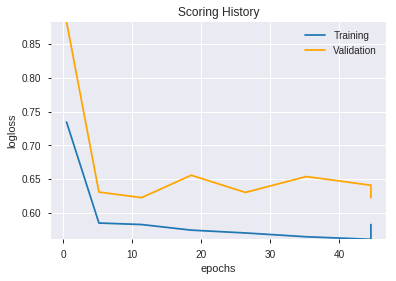

--2019-08-27 18:42:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.68
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_183430_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_183430_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'SUB',
 'CDLHANGINGMAN',
 'ULTOSC',
 'TRANGE',
 'aroonup_30',
 'day',
 'DIV',
 'CDLTAKURI',
 'weekday_name',
 'CDLMARUBOZU',
 'CDLRICKSHAWMAN',
 'CDLMORNINGSTAR',
 'CDLENGULFING',
 'MFI_12',
 'CDLDARKCLOUDCOVER',
 'DX_14',
 'CCI_12',
 'AROONOSC_12',
 'MFI_14',
 'CDLDRAGONFLYDOJI',
 'DX_12',
 'CDLSPINNINGTOP',
 'MFI_20',
 'SAREXT',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'ADOSC',
 'HT_TRENDMODE',
 'WILLR_30',
 'aroonup_8',
 'DX_8',
 'HT_PHASOR_inphase',
 'dayofweek',
 'CDLBELTHOLD',
 'WILLR_8',
 'CORREL_8',
 'weekday',
 'STOCH_slowd',
 'CDLDOJI',
 'PLUS_DI_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_14',
 'is_month_end',
 'CDLHIKKAKE',
 'CDLLONGLEGGEDDOJI',
 'WILLR_12']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_184252_model_1  0.732041  0.605249              0.383439  0.457086  0.208927

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.345993           1.000000    0.070624
1                  SUB             0.310209           0.896574    0.063320
2               CCI_12             0.242644           0.701296    0.049528
3               ULTOSC             0.226818           0.655556    0.046298
4   CDLCLOSINGMARUBOZU             0.194178           0.561220    0.039636
5             WILLR_30             0.157378           0.454857    0.032124
6             WILLR_24             0.147085           0.425109    0.030023
7        CDLHANGINGMAN             0.134145           0.387709    0.027382
8               MFI_14             0.126011           0.364201    0.025721
9           aroonup_30             0.123579           0.357171    0.025225
10          PLUS_DI_14             0.123488           0.356908    0.025206
11         AROONOSC_12             0.121889           0.352288    0.024880
12         CDLLONGLINE             0.121746           0.351875    0.024851
13              MFI_20             0.119663           0.345852    0.024426
14         STOCH_slowd             0.115140           0.332780    0.023502
15                 day             0.108303           0.313021    0.022107
16            WILLR_14             0.105523           0.304986    0.021539
17   CDLDARKCLOUDCOVER             0.104446           0.301872    0.021319
18              MFI_12             0.103370           0.298762    0.021100
19            CORREL_8             0.103115           0.298026    0.021048
20         CDLMARUBOZU             0.101044           0.292039    0.020625
21             WILLR_8             0.100240           0.289717    0.020461
22          CDLHIKKAKE             0.097574           0.282012    0.019917
23            WILLR_12             0.096791           0.279747    0.019757
24        weekday_name             0.095228           0.275232    0.019438
25   HT_PHASOR_inphase             0.093296           0.269648    0.019044
26      CDLMORNINGSTAR             0.090371           0.261194    0.018447
27        STOCHF_fastk             0.083965           0.242678    0.017139
28           aroonup_8             0.082187           0.237538    0.016776
29      CDLRICKSHAWMAN             0.079728           0.230431    0.016274
30           CDLTAKURI             0.077127           0.222914    0.015743
31        HT_TRENDMODE             0.076686           0.221642    0.015653
32         CDLBELTHOLD             0.069420           0.200639    0.014170
33      CDLSPINNINGTOP             0.064182           0.185502    0.013101
34           dayofweek             0.054925           0.158747    0.011211
35             weekday             0.054721           0.158158    0.011170
36            WILLR_20             0.052719           0.152370    0.010761
37                DX_8             0.046421           0.134167    0.009475
38      STOCHRSI_fastk             0.045944           0.132788    0.009378
39        is_month_end             0.043912           0.126915    0.008963
40   CDLLONGLEGGEDDOJI             0.040714           0.117672    0.008311
41              SAREXT             0.037376           0.108026    0.007629
42               DX_14             0.035872           0.103678    0.007322
43        CDLENGULFING             0.035009           0.101184    0.007146
44    CDLDRAGONFLYDOJI             0.027160           0.078497    0.005544
45              TRANGE             0.027091           0.078300    0.005530
46               ADOSC             0.025021           0.072317    0.005107
47               DX_12             0.022513           0.065069    0.004595
48             CDLDOJI             0.006423           0.018565    0.001311
49                 DIV             0.000698           0.002016    0.000142

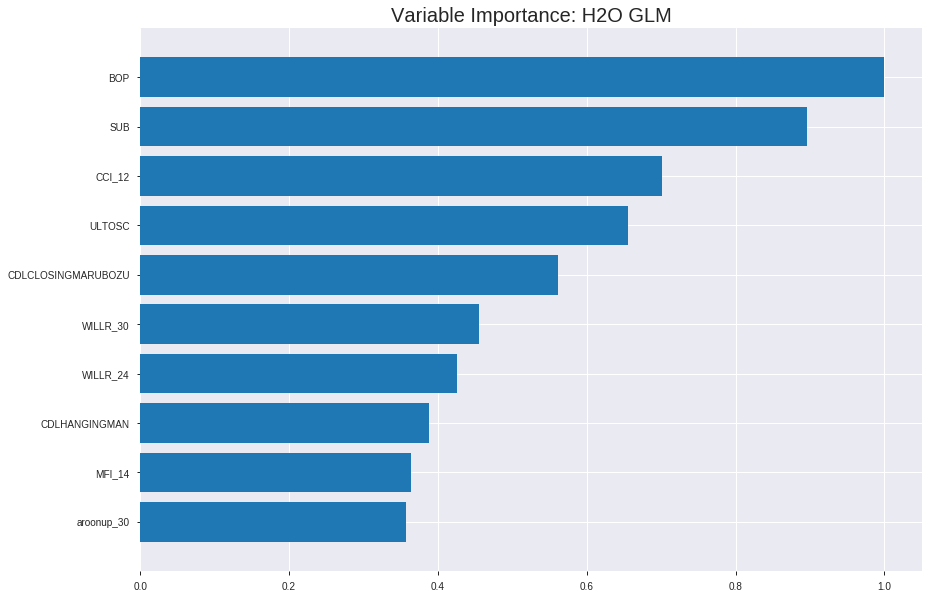

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_184252_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19511772072664949
RMSE: 0.4417213156806557
LogLoss: 0.5728595698087656
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2428.4481185881305
Residual deviance: 2008.445651749532
AIC: 2110.445651749532
AUC: 0.7704431032865318
pr_auc: 0.7662246586308785
Gini: 0.5408862065730635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38576882866539314: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      396  453   0.5336   (453.0/849.0)
1      100  804   0.1106   (100.0/904.0)
Total  496  1257  0.3155   (553.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385769     0.7441    263
max f2                       0.153798     0.851873  361
max f0point5                 0.560127     0.712379  176
max accuracy                 0.497582     0.703936  208
max precision                0.979723     1         0
max recall                   0.0606786    1         390
max specificity              0.979723     1         0
max absolute_mcc             0.497582     0.406925  208
max min_per_class_accuracy   0.529881     0.700824  192
max mean_per_class_accuracy  0.497582     0.702659  208

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.919951           1.83143   1.83143            0.944444         0.938989  0.944444                    0.938989            0.0188053       0.0188053                  83.1428   83.1428
    2        0.0205362                   0.902444           1.61597   1.7237             0.833333         0.910122  0.888889                    0.924555            0.0165929       0.0353982                  61.5966   72.3697
    3        0.0302339                   0.88123            1.82509   1.75622            0.941176         0.891971  0.90566                     0.914104            0.0176991       0.0530973                  82.5091   75.622
    4        0.040502                    0.866837           1.93916   1.8026             1                0.873368  0.929577                    0.903776            0.0199115       0.0730088                  93.9159   80.2599
    5        0.0501997                   0.856079           1.59695   1.76287            0.823529         0.861233  0.909091                    0.895558            0.0154867       0.0884956                  59.6955   76.2872
    6        0.100399                    0.792747           1.56455   1.66371            0.806818         0.823774  0.857955                    0.859666            0.0785398       0.167035                   56.4549   66.3711
    7        0.150029                    0.746954           1.53795   1.62211            0.793103         0.76814   0.836502                    0.829389            0.0763274       0.243363                   53.7954   62.211
    8        0.200228                    0.71761            1.60862   1.61873            0.829545         0.731352  0.834758                    0.80481             0.0807522       0.324115                   60.8621   61.8728
    9        0.300057                    0.659295           1.37403   1.53732            0.708571         0.687177  0.792776                    0.765674            0.137168        0.461283                   37.4033   53.7318
    10       0.399886                    0.594491           1.14133   1.43846            0.588571         0.624957  0.741797                    0.730545            0.113938        0.575221                   14.1334   43.8463
    11       0.500285                    0.53298            1.18994   1.38859            0.613636         0.565251  0.716078                    0.697373            0.119469        0.69469                    18.9939   38.8588
    12       0.600114                    0.459347           0.908635  1.30875            0.468571         0.496316  0.674905                    0.663927            0.090708        0.785398                   -9.13654  30.8748
    13       0.699943                    0.396906           0.897554  1.2501             0.462857         0.428269  0.644662                    0.630317            0.0896018       0.875                      -10.2446  25.0102
    14       0.799772                    0.318439           0.598369  1.16875            0.308571         0.360642  0.60271                     0.596655            0.0597345       0.934735                   -40.1631  16.8751
    15       0.899601                    0.205302           0.409994  1.08455            0.211429         0.257721  0.55929                     0.559044            0.0409292       0.975664                   -59.0006  8.4552
    16       1                           0.00618917         0.242395  1                  0.125            0.127205  0.515687                    0.515687            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21475027334247743
RMSE: 0.4634115593535377
LogLoss: 0.6221401084061094
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.0853381814004
Residual deviance: 623.3843886229216
AIC: 725.3843886229216
AUC: 0.7172057932178517
pr_auc: 0.6863807722281744
Gini: 0.43441158643570343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35993983611154695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      82   161  0.6626   (161.0/243.0)
1      19   239  0.0736   (19.0/258.0)
Total  101  400  0.3593   (180.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35994      0.726444  310
max f2                       0.257582     0.850777  349
max f0point5                 0.535409     0.67852   218
max accuracy                 0.535409     0.672655  218
max precision                0.900926     0.8       9
max recall                   0.0742163    1         394
max specificity              0.953688     0.995885  0
max absolute_mcc             0.506162     0.348318  237
max min_per_class_accuracy   0.5702       0.654321  197
max mean_per_class_accuracy  0.535409     0.671045  218

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 54.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.915799           1.29457   1.29457            0.666667         0.932683  0.666667                    0.932683            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.900213           1.55349   1.41226            0.8              0.904855  0.727273                    0.920034            0.0155039       0.0310078                  55.3488   41.2262
    3        0.0319361                   0.866681           1.55349   1.4564             0.8              0.877966  0.75                        0.906888            0.0155039       0.0465116                  55.3488   45.6395
    4        0.0419162                   0.854949           1.16512   1.38704            0.6              0.857644  0.714286                    0.895163            0.0116279       0.0581395                  16.5116   38.7043
    5        0.0518962                   0.840819           1.94186   1.49374            1                0.843128  0.769231                    0.885156            0.0193798       0.0775194                  94.186    49.3739
    6        0.101796                    0.791116           1.47581   1.48495            0.76             0.814052  0.764706                    0.850301            0.0736434       0.151163                   47.5814   48.4952
    7        0.151697                    0.760307           1.32047   1.43084            0.68             0.778306  0.736842                    0.826618            0.0658915       0.217054                   32.0465   43.0845
    8        0.201597                    0.721773           1.47581   1.44198            0.76             0.740617  0.742574                    0.805331            0.0736434       0.290698                   47.5814   44.1976
    9        0.301397                    0.673092           1.28163   1.38888            0.66             0.695215  0.715232                    0.768869            0.127907        0.418605                   28.1628   38.888
    10       0.401198                    0.627094           1.32047   1.37186            0.68             0.646732  0.706468                    0.738486            0.131783        0.550388                   32.0465   37.1862
    11       0.500998                    0.571533           1.00977   1.29973            0.52             0.599085  0.669323                    0.710717            0.100775        0.651163                   0.976744  29.9731
    12       0.600798                    0.515194           0.97093   1.24511            0.5              0.542195  0.641196                    0.682723            0.0968992       0.748062                   -2.90698  24.5113
    13       0.700599                    0.449194           1.00977   1.21159            0.52             0.482984  0.623932                    0.654271            0.100775        0.848837                   0.976744  21.1588
    14       0.800399                    0.358122           0.776744  1.15737            0.4              0.405571  0.59601                     0.623261            0.0775194       0.926357                   -22.3256  15.7368
    15       0.9002                      0.250718           0.504884  1.08503            0.26             0.306941  0.558758                    0.588192            0.0503876       0.976744                   -49.5116  8.50307
    16       1                           0.0234812          0.233023  1                  0.12             0.154037  0.51497                     0.544863          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:42:52  0.000 sec   2            17        51            1.36256           1.36942
    2019-08-27 18:42:52  0.019 sec   4            11        51            1.35161           1.3618
    2019-08-27 18:42:52  0.031 sec   6            6.7       51            1.33696           1.35168
    2019-08-27 18:42:52  0.044 sec   8            4.1       51            1.31852           1.33905
    2019-08-27 18:42:52  0.057 sec   10           2.6       51            1.29667           1.32427
    2019-08-27 18:42:52  0.070 sec   12           1.6       51            1.27255           1.30823
    2019-08-27 18:42:52  0.082 sec   14           0.99      51            1.24791           1.29232
    2019-08-27 18:42:52  0.095 sec   16           0.62      51            1.22458           1.27791
    2019-08-27 18:42:52  0.107 sec   18           0.38      51            1.20405           1.26604
    2019-08-27 18:42:52  0.120 sec   20           0.24      51            1.18702           1.25705
    2019-08-27 18:42:52  0.133 sec   22           0.15      51            1.17352           1.25082
    2019-08-27 18:42:52  0.145 sec   24           0.092     51            1.1632            1.24697
    2019-08-27 18:42:52  0.157 sec   26           0.057     51            1.15554           1.24499
    2019-08-27 18:42:52  0.172 sec   28           0.035     51            1.14993           1.24432
    2019-08-27 18:42:52  0.187 sec   30           0.022     51            1.14572           1.24428
    2019-08-27 18:42:52  0.200 sec   32           0.014     51            1.1424            1.24453
    2019-08-27 18:42:52  0.213 sec   34           0.0085    51            1.13964           1.24478
    2019-08-27 18:42:52  0.227 sec   36           0.0053    51            1.13735           1.24528
    2019-08-27 18:42:52  0.241 sec   38           0.0033    51            1.13551           1.24591
    2019-08-27 18:42:52  0.256 sec   40           0.002     51            1.13414           1.24658

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7319884726224785)

('auc', 0.7320406865861412)

('logloss', 0.6052489632765383)

('mean_per_class_error', 0.3007628734901462)

('rmse', 0.45708570861232806)

('mse', 0.20892734501763408)

glm prediction progress: |████████████████████████████████████████████████| 100%


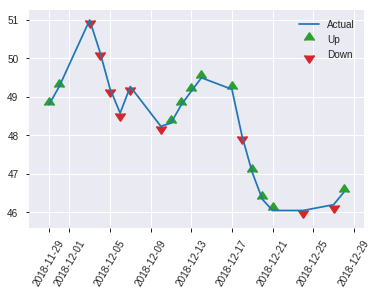


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20892734501763408
RMSE: 0.45708570861232806
LogLoss: 0.6052489632765383
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.642153441148
Residual deviance: 303.83497956482216
AIC: 405.83497956482216
AUC: 0.7320406865861412
pr_auc: 0.7039742489799926
Gini: 0.4640813731722824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2254278116882864: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      31   90   0.7438   (90.0/121.0)
1      3    127  0.0231   (3.0/130.0)
Total  34   217  0.3705   (93.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.225428     0.731988  216
max f2                       0.225428     0.861601  216
max f0point5                 0.490216     0.706052  140
max accuracy                 0.490216     0.701195  140
max precision                0.966323     1         0
max recall                   0.102162     1         243
max specificity              0.966323     1         0
max absolute_mcc             0.487166     0.401569  142
max min_per_class_accuracy   0.523719     0.68595   127
max mean_per_class_accuracy  0.490216     0.699237  140

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.90108            1.93077   1.93077            1                0.923721  1                           0.923721            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.856141           0.64359   1.28718            0.333333         0.875425  0.666667                    0.899573            0.00769231      0.0307692                  -35.641   28.7179
    3        0.0318725                   0.840231           1.93077   1.44808            1                0.843842  0.75                        0.88564             0.0153846       0.0461538                  93.0769   44.8077
    4        0.0438247                   0.82875            1.28718   1.4042             0.666667         0.83551   0.727273                    0.871968            0.0153846       0.0615385                  28.7179   40.4196
    5        0.0517928                   0.818702           0.965385  1.33669            0.5              0.822047  0.692308                    0.864288            0.00769231      0.0692308                  -3.46154  33.6686
    6        0.103586                    0.754921           1.63373   1.48521            0.846154         0.78787   0.769231                    0.826079            0.0846154       0.153846                   63.3728   48.5207
    7        0.151394                    0.718642           1.60897   1.52429            0.833333         0.735748  0.789474                    0.797553            0.0769231       0.230769                   60.8974   52.4291
    8        0.203187                    0.688669           1.18817   1.43861            0.615385         0.701116  0.745098                    0.772971            0.0615385       0.292308                   18.8166   43.8612
    9        0.302789                    0.620999           1.39015   1.42267            0.72             0.648568  0.736842                    0.732049            0.138462        0.430769                   39.0154   42.2672
    10       0.40239                     0.584196           1.23569   1.37639            0.64             0.600399  0.712871                    0.699462            0.123077        0.553846                   23.5692   37.639
    11       0.501992                    0.52891            1.23569   1.34847            0.64             0.557491  0.698413                    0.671293            0.123077        0.676923                   23.5692   34.8474
    12       0.601594                    0.442292           1.004     1.29144            0.52             0.490716  0.668874                    0.641397            0.1             0.776923                   0.4       29.1442
    13       0.701195                    0.380518           0.617846  1.19576            0.32             0.410068  0.619318                    0.608537            0.0615385       0.838462                   -38.2154  19.576
    14       0.800797                    0.311506           0.772308  1.14309            0.4              0.348138  0.59204                     0.576149            0.0769231       0.915385                   -22.7692  14.3092
    15       0.900398                    0.193235           0.617846  1.08499            0.32             0.242637  0.561947                    0.539256            0.0615385       0.976923                   -38.2154  8.49898
    16       1                           0.0400186          0.231692  1                  0.12             0.114278  0.517928                    0.496928           

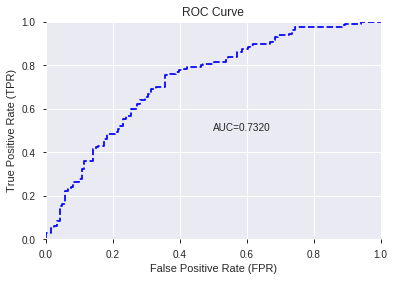

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


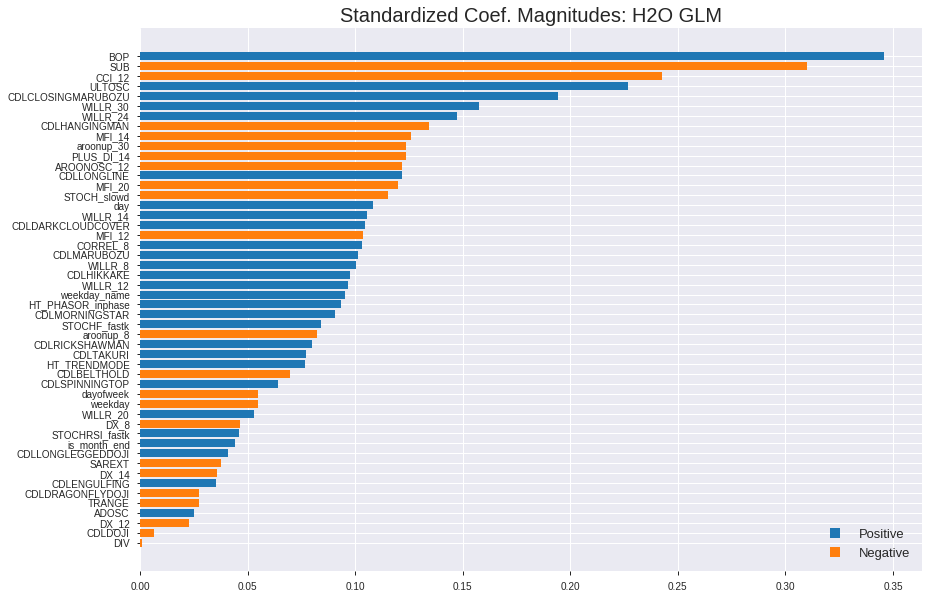

'log_likelihood'
--2019-08-27 18:42:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_184252_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_184252_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'CCI_12',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'WILLR_30',
 'WILLR_24',
 'CDLHANGINGMAN',
 'MFI_14',
 'aroonup_30',
 'PLUS_DI_14',
 'AROONOSC_12',
 'CDLLONGLINE',
 'MFI_20',
 'STOCH_slowd',
 'day',
 'WILLR_14',
 'CDLDARKCLOUDCOVER',
 'MFI_12',
 'CORREL_8',
 'CDLMARUBOZU',
 'WILLR_8',
 'CDLHIKKAKE',
 'WILLR_12',
 'weekday_name',
 'HT_PHASOR_inphase',
 'CDLMORNINGSTAR',
 'STOCHF_fastk',
 'aroonup_8',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'CDLBELTHOLD',
 'CDLSPINNINGTOP',
 'dayofweek',
 'weekday',
 'WILLR_20',
 'DX_8',
 'STOCHRSI_fastk',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'SAREXT',
 'DX_14',
 'CDLENGULFING',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'ADOSC',
 'DX_12',
 'CDLDOJI',
 'DIV']

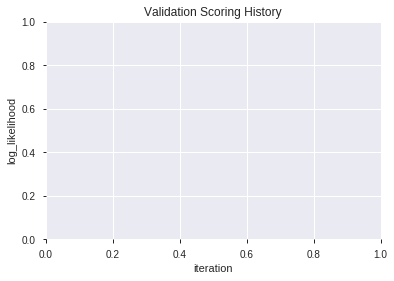

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_184303_model_4  0.740814  0.598164              0.309758  0.453342  0.205519
1               XGBoost_1_AutoML_20190827_184303  0.712206  0.619011              0.321011  0.464508  0.215768
2  XGBoost_grid_1_AutoML_20190827_184303_model_2  0.709409  0.617906              0.305626  0.463277  0.214625
3               XGBoost_3_AutoML_20190827_184303  0.702861  0.624084              0.334838  0.467282  0.218352
4  XGBoost_grid_1_AutoML_20190827_184303_model_6  0.701907  0.622140              0.296790  0.466126  0.217273
5               XGBoost_2_AutoML_20190827_184303  0.701399  0.627681              0.346949  0.468373  0.219373
6  XGBoost_grid_1_AutoML_20190827_184303_model_7  0.697521  0.634194              0.364050  0.471069  0.221906
7  XGBoost_grid_1_AutoML_20190827_184303_model_1  0.696758  0.625337              0.323713  0.468163  0.219177
8  XGBoost_grid_1_AutoML_20190827_184303_model_3  0.683853  0.630556              0.337254  0.470740  0.221596
9  XGBoost_grid_1_AutoML_20190827_184303_model_5  0.674952  0.652176              0.360490  0.479146  0.229581

variable  relative_importance  scaled_importance  percentage
0                  BOP          1619.229858           1.000000    0.329003
1                  SUB           488.778839           0.301859    0.099313
2         STOCHF_fastk           326.535309           0.201661    0.066347
3               ULTOSC           278.913422           0.172251    0.056671
4               CCI_12           191.767944           0.118432    0.038964
5                  DIV           146.331818           0.090371    0.029732
6           PLUS_DI_14           133.855698           0.082666    0.027197
7                  day           131.469772           0.081193    0.026713
8               MFI_12           123.388786           0.076202    0.025071
9                ADOSC           120.887741           0.074658    0.024563
10              SAREXT           115.198402           0.071144    0.023407
11               DX_12           109.681419           0.067737    0.022286
12               DX_14            90.551811           0.055923    0.018399
13              MFI_14            90.345154           0.055795    0.018357
14              MFI_20            88.284882           0.054523    0.017938
15            WILLR_30            81.900177           0.050580    0.016641
16           dayofweek            78.414978           0.048427    0.015933
17             WILLR_8            76.484291           0.047235    0.015540
18      STOCHRSI_fastk            62.481747           0.038587    0.012695
19         STOCH_slowd            61.711296           0.038112    0.012539
20              TRANGE            60.050167           0.037086    0.012201
21           aroonup_8            58.030113           0.035838    0.011791
22            CORREL_8            53.733616           0.033185    0.010918
23                DX_8            53.393234           0.032974    0.010849
24   HT_PHASOR_inphase            43.917999           0.027123    0.008923
25            WILLR_12            41.466805           0.025609    0.008425
26          aroonup_30            36.678543           0.022652    0.007453
27            WILLR_14            35.726067           0.022064    0.007259
28            WILLR_24            35.363518           0.021840    0.007185
29         AROONOSC_12            32.790985           0.020251    0.006663
30         CDLLONGLINE            16.580509           0.010240    0.003369
31  CDLCLOSINGMARUBOZU            14.713947           0.009087    0.002990
32             CDLDOJI            10.376314           0.006408    0.002108
33        weekday_name            10.204649           0.006302    0.002073
34            WILLR_20             2.382715           0.001472    0.000484

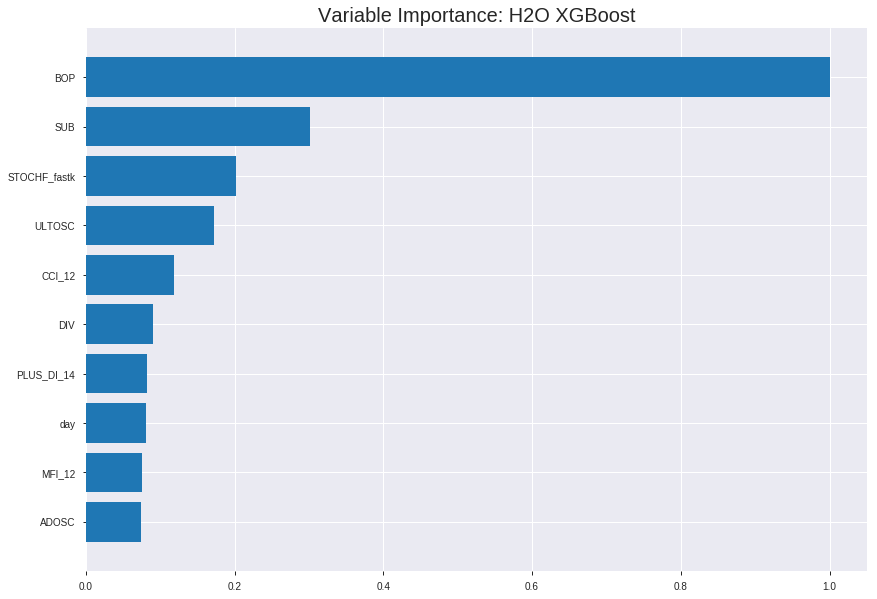

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_184303_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1794901939181396
RMSE: 0.42366283046561876
LogLoss: 0.5392310771759264
Mean Per-Class Error: 0.24530030123935498
AUC: 0.8221111250091206
pr_auc: 0.8266067028926808
Gini: 0.6442222500182413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4480753421783447: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      474  375   0.4417   (375.0/849.0)
1      113  791   0.125    (113.0/904.0)
Total  587  1166  0.2784   (488.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448075     0.764251  242
max f2                       0.218168     0.865142  348
max f0point5                 0.586813     0.771144  162
max accuracy                 0.564205     0.754136  176
max precision                0.882012     1         0
max recall                   0.152134     1         381
max specificity              0.882012     1         0
max absolute_mcc             0.564205     0.50925   176
max min_per_class_accuracy   0.55384      0.75      182
max mean_per_class_accuracy  0.564205     0.7547    176

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.76 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.837795           1.93916    1.93916            1                0.850804  1                           0.850804            0.0199115       0.0199115                  93.9159   93.9159
    2        0.0205362                   0.823983           1.93916    1.93916            1                0.830385  1                           0.840595            0.0199115       0.039823                   93.9159   93.9159
    3        0.0302339                   0.815252           1.82509    1.90257            0.941176         0.819517  0.981132                    0.833834            0.0176991       0.0575221                  82.5091   90.2571
    4        0.040502                    0.805968           1.83143    1.88454            0.944444         0.81102   0.971831                    0.82805             0.0188053       0.0763274                  83.1428   88.4535
    5        0.0501997                   0.797652           1.71102    1.85102            0.882353         0.801276  0.954545                    0.822878            0.0165929       0.0929204                  71.1023   85.1016
    6        0.100399                    0.755318           1.78491    1.81796            0.920455         0.772636  0.9375                      0.797757            0.0896018       0.182522                   78.4908   81.7962
    7        0.150029                    0.730302           1.67169    1.76958            0.862069         0.743198  0.912548                    0.779709            0.0829646       0.265487                   67.1689   76.9575
    8        0.200228                    0.703077           1.67473    1.7458             0.863636         0.71682   0.900285                    0.763942            0.0840708       0.349558                   67.4728   74.5796
    9        0.300057                    0.653235           1.41836    1.63686            0.731429         0.677792  0.844106                    0.73528             0.141593        0.49115                    41.8357   63.6857
    10       0.399886                    0.607517           1.34079    1.56295            0.691429         0.630863  0.805991                    0.709213            0.13385         0.625                      34.079    56.2946
    11       0.500285                    0.556539           1.20096    1.4903             0.619318         0.583866  0.768529                    0.684058            0.120575        0.745575                   20.0957   49.03
    12       0.600114                    0.497025           0.73134    1.36405            0.377143         0.524739  0.703422                    0.657555            0.0730088       0.818584                   -26.866   36.4047
    13       0.699943                    0.412651           0.764583   1.27855            0.394286         0.456969  0.659332                    0.628947            0.0763274       0.894912                   -23.5417  27.8549
    14       0.799772                    0.300923           0.587288   1.19226            0.302857         0.361278  0.614836                    0.595536            0.0586283       0.95354                    -41.2712  19.2265
    15       0.899601                    0.200872           0.36567    1.10054            0.188571         0.24913   0.567533                    0.557095            0.0365044       0.990044                   -63.433   10.0537
    16       1                           0.103342           0.0991616  1                  0.0511364        0.163692  0.515687                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21363144779921464
RMSE: 0.46220282106366967
LogLoss: 0.6171777778790258
Mean Per-Class Error: 0.3071825055029189
AUC: 0.7198376240150572
pr_auc: 0.6841830225418701
Gini: 0.4396752480301145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4582596719264984: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  128  0.5267   (128.0/243.0)
1      36   222  0.1395   (36.0/258.0)
Total  151  350  0.3273   (164.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45826      0.730263  266
max f2                       0.234521     0.850706  362
max f0point5                 0.57404      0.703498  189
max accuracy                 0.57404      0.692615  189
max precision                0.816666     0.8       9
max recall                   0.14902      1         397
max specificity              0.854037     0.995885  0
max absolute_mcc             0.57404      0.385463  189
max min_per_class_accuracy   0.57404      0.686047  189
max mean_per_class_accuracy  0.57404      0.692817  189

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 53.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.825306           1.29457   1.29457            0.666667         0.836702  0.666667                    0.836702            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.816077           1.55349   1.41226            0.8              0.81797   0.727273                    0.828187            0.0155039       0.0310078                  55.3488   41.2262
    3        0.0319361                   0.800275           1.16512   1.33503            0.6              0.808662  0.6875                      0.822086            0.0116279       0.0426357                  16.5116   33.5029
    4        0.0419162                   0.792913           1.55349   1.38704            0.8              0.796355  0.714286                    0.815959            0.0155039       0.0581395                  55.3488   38.7043
    5        0.0518962                   0.782233           1.16512   1.34436            0.6              0.78824   0.692308                    0.810629            0.0116279       0.0697674                  16.5116   34.4365
    6        0.101796                    0.740403           1.55349   1.44688            0.8              0.756107  0.745098                    0.783903            0.0775194       0.147287                   55.3488   44.6876
    7        0.151697                    0.718998           1.47581   1.4564             0.76             0.727707  0.75                        0.765417            0.0736434       0.22093                    47.5814   45.6395
    8        0.201597                    0.701739           1.24279   1.40352            0.64             0.710327  0.722772                    0.751781            0.0620155       0.282946                   24.2791   40.3523
    9        0.301397                    0.656757           1.32047   1.37602            0.68             0.676032  0.708609                    0.726699            0.131783        0.414729                   32.0465   37.602
    10       0.401198                    0.617897           1.24279   1.34288            0.64             0.635414  0.691542                    0.703991            0.124031        0.53876                    24.2791   34.2879
    11       0.500998                    0.572157           1.47581   1.36936            0.76             0.595596  0.705179                    0.682398            0.147287        0.686047                   47.5814   36.936
    12       0.600798                    0.523727           0.776744  1.27092            0.4              0.546698  0.654485                    0.659857            0.0775194       0.763566                   -22.3256  27.0919
    13       0.700599                    0.456703           0.97093   1.22819            0.5              0.488467  0.632479                    0.635442            0.0968992       0.860465                   -2.90698  22.8185
    14       0.800399                    0.371976           0.504884  1.138              0.26             0.415325  0.586035                    0.607996            0.0503876       0.910853                   -49.5116  13.7998
    15       0.9002                      0.246159           0.582558  1.07642            0.3              0.30608   0.554324                    0.574524            0.0581395       0.968992                   -41.7442  7.64193
    16       1                           0.138483           0.310698  1                  0.16             0.191802  0.51497                     0.536329           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:43:12  3.408 sec   0                  0.5              0.693147            0.5             0                  1                0.484313                         0.5                0.693147              0.5               0                    1                  0.48503
    2019-08-27 18:43:12  3.515 sec   5                  0.480939         0.655551            0.762523        0.745833           1.93916          0.334855                         0.487051           0.667475              0.699285          0.663573             1.21366            0.387226
    2019-08-27 18:43:12  3.575 sec   10                 0.468034         0.630285            0.772319        0.773001           1.93916          0.327439                         0.479232           0.651978              0.701941          0.658865             0.97093            0.331337
    2019-08-27 18:43:12  3.640 sec   15                 0.458501         0.611412            0.780838        0.785508           1.93916          0.324016                         0.473489           0.640485              0.710084          0.670494             0.97093            0.337325
    2019-08-27 18:43:12  3.721 sec   20                 0.45123          0.596858            0.788234        0.78844            1.93916          0.296634                         0.469635           0.6327                0.715603          0.677759             0.97093            0.331337
    2019-08-27 18:43:12  3.785 sec   25                 0.445751         0.585506            0.791807        0.793665           1.93916          0.30405                          0.467312           0.627843              0.716815          0.681698             0.97093            0.323353
    2019-08-27 18:43:12  3.850 sec   30                 0.441533         0.576732            0.797359        0.798951           1.93916          0.298916                         0.465721           0.624478              0.717963          0.68204              0.97093            0.331337
    2019-08-27 18:43:13  3.922 sec   35                 0.437602         0.568519            0.802409        0.805676           1.93916          0.296634                         0.464297           0.621575              0.720436          0.684331             0.97093            0.337325
    2019-08-27 18:43:13  3.991 sec   40                 0.434216         0.56146             0.807228        0.811112           1.93916          0.300627                         0.46341            0.619689              0.721744          0.684817             0.97093            0.323353
    2019-08-27 18:43:13  4.074 sec   45                 0.4312           0.55513             0.811521        0.816486           1.93916          0.2915                           0.463024           0.618906              0.721201          0.682127             0.97093            0.323353
    2019-08-27 18:43:13  4.149 sec   50                 0.427891         0.548415            0.817196        0.820779           1.93916          0.280662                         0.463533           0.619947              0.718155          0.680056             1.29457            0.321357
    2019-08-27 18:43:13  4.226 sec   55                 0.425439         0.543132            0.819691        0.823846           1.93916          0.279521                         0.46302            0.61883               0.717764          0.

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1619.2298583984375     1.0                    0.3290032606006841
SUB                 488.7788391113281      0.3018588352828263     0.09931254104917468
STOCHF_fastk        326.5353088378906      0.20166087423861065    0.0663470851600874
ULTOSC              278.9134216308594      0.17225066607080083    0.0566710307779331
CCI_12              191.7679443359375      0.11843157618499764    0.03896437472294255
---                 ---                    ---                    ---
CDLLONGLINE         16.580509185791016     0.010239750150229206   0.003368911187161753
CDLCLOSINGMARUBOZU  14.713947296142578     0.009087003441683061   0.0029896537614033654
CDLDOJI             10.376314163208008     0.006408178622318086   0.0021083116612542496
weekday_name        10.204648971557617     0.0063021620547751775  0.0020734318648549404
WILLR_20            2.3827147483825684     0.0014715111236518856  0.0004841319576916468


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7516339869281047)

('auc', 0.7408137317228226)

('logloss', 0.5981636507632573)

('mean_per_class_error', 0.30832803560076294)

('rmse', 0.45334217539948923)

('mse', 0.20551912799594124)

xgboost prediction progress: |████████████████████████████████████████████| 100%


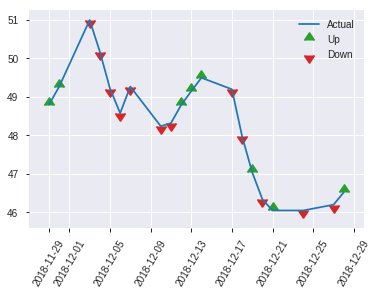


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20551912799594124
RMSE: 0.45334217539948923
LogLoss: 0.5981636507632573
Mean Per-Class Error: 0.30832803560076294
AUC: 0.7408137317228226
pr_auc: 0.7182816932905937
Gini: 0.4816274634456452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40378299355506897: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   61   0.5041   (61.0/121.0)
1      15   115  0.1154   (15.0/130.0)
Total  75   176  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403783     0.751634  175
max f2                       0.201321     0.857909  225
max f0point5                 0.56109      0.695876  112
max accuracy                 0.44448      0.697211  165
max precision                0.841362     1         0
max recall                   0.124861     1         247
max specificity              0.841362     1         0
max absolute_mcc             0.403783     0.415349  175
max min_per_class_accuracy   0.531205     0.669421  127
max mean_per_class_accuracy  0.44448      0.691672  165

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.793119           1.28718   1.28718            0.666667         0.819356  0.666667                    0.819356            0.0153846       0.0153846                  28.7179   28.7179
    2        0.0239044                   0.781363           1.93077   1.60897            1                0.784091  0.833333                    0.801723            0.0230769       0.0384615                  93.0769   60.8974
    3        0.0318725                   0.778462           1.93077   1.68942            1                0.779902  0.875                       0.796268            0.0153846       0.0538462                  93.0769   68.9423
    4        0.0438247                   0.773157           1.28718   1.57972            0.666667         0.775387  0.818182                    0.790573            0.0153846       0.0692308                  28.7179   57.972
    5        0.0517928                   0.757862           0.965385  1.48521            0.5              0.759545  0.769231                    0.7858              0.00769231      0.0769231                  -3.46154  48.5207
    6        0.103586                    0.70499            1.78225   1.63373            0.923077         0.724992  0.846154                    0.755396            0.0923077       0.169231                   78.2249   63.3728
    7        0.151394                    0.669077           1.12628   1.47348            0.583333         0.688482  0.763158                    0.734265            0.0538462       0.223077                   12.6282   47.3482
    8        0.203187                    0.657328           1.48521   1.47647            0.769231         0.661642  0.764706                    0.715753            0.0769231       0.3                        48.5207   47.6471
    9        0.302789                    0.619165           1.31292   1.42267            0.68             0.63594   0.736842                    0.689499            0.130769        0.430769                   31.2923   42.2672
    10       0.40239                     0.582621           1.31292   1.39551            0.68             0.598035  0.722772                    0.666859            0.130769        0.561538                   31.2923   39.5506
    11       0.501992                    0.535063           1.004     1.31783            0.52             0.557663  0.68254                     0.645193            0.1             0.661538                   0.4       31.7827
    12       0.601594                    0.488972           0.926769  1.25308            0.48             0.512088  0.649007                    0.623156            0.0923077       0.753846                   -7.32308  25.3082
    13       0.701195                    0.403783           1.31292   1.26158            0.68             0.449318  0.653409                    0.598463            0.130769        0.884615                   31.2923   26.1582
    14       0.800797                    0.305078           0.386154  1.1527             0.2              0.347053  0.597015                    0.567193            0.0384615       0.923077                   -61.3846  15.2698
    15       0.900398                    0.201321           0.617846  1.09353            0.32             0.254045  0.566372                    0.532553            0.0615385       0.984615                   -38.2154  9.3533
    16       1                           0.108424           0.154462  1                  0.08             0.15313   0.517928                    0.494762           

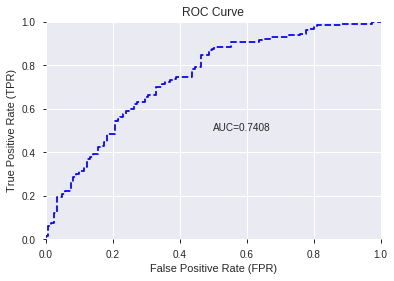

This function is available for GLM models only


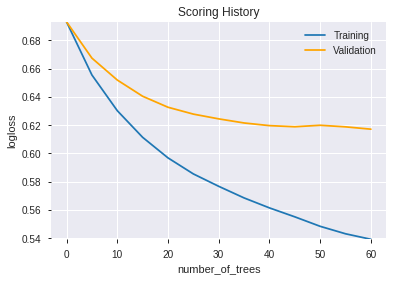

--2019-08-27 18:43:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_184303_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_184303_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'STOCHF_fastk',
 'ULTOSC',
 'CCI_12',
 'DIV',
 'PLUS_DI_14',
 'day',
 'MFI_12',
 'ADOSC',
 'SAREXT',
 'DX_12',
 'DX_14',
 'MFI_14',
 'MFI_20',
 'WILLR_30',
 'dayofweek',
 'WILLR_8',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'TRANGE',
 'aroonup_8',
 'CORREL_8',
 'DX_8',
 'HT_PHASOR_inphase',
 'WILLR_12',
 'aroonup_30',
 'WILLR_14',
 'WILLR_24',
 'AROONOSC_12',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI',
 'weekday_name',
 'WILLR_20']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [895 916 940] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


55

['SAR_0.08',
 'SAR_0.12',
 'SAR_0.14',
 'SAR_0.2',
 'SAR_0.24',
 'SAR_0.3',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'LINEARREG_ANGLE_8',
 'LINEARREG_INTERCEPT_8',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_184331_model_8  0.766052  0.606259              0.310045  0.456394  0.208296
1  DeepLearning_grid_1_AutoML_20190827_184331_model_9  0.749015  0.616486              0.304196  0.462205  0.213633
2  DeepLearning_grid_1_AutoML_20190827_184331_model_7  0.740623  0.779454              0.340401  0.501689  0.251692
3  DeepLearning_grid_1_AutoML_20190827_184331_model_5  0.740242  0.621499              0.340973  0.464829  0.216066
4  DeepLearning_grid_1_AutoML_20190827_184331_model_6  0.720025  0.628121              0.351939  0.465906  0.217068
5  DeepLearning_grid_1_AutoML_20190827_184331_model_4  0.717737  0.696091              0.360490  0.484459  0.234701
6               DeepLearning_1_AutoML_20190827_184331  0.716402  0.660399              0.381723  0.477254  0.227771
7  DeepLearning_grid_1_AutoML_20190827_184331_model_2  0.702734  0.808923              0.359345  0.504885  0.254909
8  DeepLearning_grid_1_AutoML_20190827_184331_model_3  0.692435  0.759411              0.397394  0.503726  0.253740
9  DeepLearning_grid_1_AutoML_20190827_184331_model_1  0.610744  0.820025              0.461666  0.532680  0.283748

variable  relative_importance  scaled_importance  percentage
0                     BOP             1.000000           1.000000    0.031556
1      CDLCLOSINGMARUBOZU             0.923140           0.923140    0.029131
2                     SUB             0.778718           0.778718    0.024574
3             CDLLONGLINE             0.727719           0.727719    0.022964
4                  ULTOSC             0.705782           0.705782    0.022272
5            STOCHF_fastk             0.686923           0.686923    0.021677
6                   CCI_8             0.654014           0.654014    0.020638
7             CDLMARUBOZU             0.634653           0.634653    0.020027
8                  TRANGE             0.629784           0.629784    0.019874
9                   ADOSC             0.629727           0.629727    0.019872
10                    DIV             0.615008           0.615008    0.019407
11         STOCHRSI_fastk             0.596702           0.596702    0.018830
12          CDLHANGINGMAN             0.592901           0.592901    0.018710
13  LINEARREG_INTERCEPT_8             0.585699           0.585699    0.018483
14                 CCI_12             0.581641           0.581641    0.018355
15           CDLENGULFING             0.579575           0.579575    0.018289
16               WILLR_24             0.575730           0.575730    0.018168
17                 CCI_24             0.575531           0.575531    0.018162
18         STOCHRSI_fastd             0.572681           0.572681    0.018072
19      CDLLONGLEGGEDDOJI             0.565237           0.565237    0.017837
20                CDLDOJI             0.565173           0.565173    0.017835
21                 CCI_14             0.563138           0.563138    0.017771
22               SAR_0.12             0.555398           0.555398    0.017526
23                 CCI_20             0.551229           0.551229    0.017395
24             MINUS_DI_8             0.548247           0.548247    0.017301
25               WILLR_12             0.545842           0.545842    0.017225
26           STOCHF_fastd             0.542948           0.542948    0.017134
27                 RSI_20             0.542279           0.542279    0.017112
28                  MOM_8             0.542084           0.542084    0.017106
29            CDLBELTHOLD             0.541407           0.541407    0.017085
30      LINEARREG_ANGLE_8             0.541178           0.541178    0.017078
31               SAR_0.08             0.540742           0.540742    0.017064
32                 CMO_14             0.540216           0.540216    0.017047
33                 RSI_12             0.539950           0.539950    0.017039
34            STOCH_slowk             0.538749           0.538749    0.017001
35                WILLR_8             0.536705           0.536705    0.016937
36                SAR_0.3             0.536655           0.536655    0.016935
37              ROCR100_8             0.535007           0.535007    0.016883
38                 RSI_14             0.534642           0.534642    0.016871
39                 CCI_30             0.533287           0.533287    0.016829
40                 ROCR_8             0.527802           0.527802    0.016656
41                  ROC_8             0.525899           0.525899    0.016596
42                 CMO_12             0.520395           0.520395    0.016422
43                  RSI_8             0.514289           0.514289    0.016229
44                SAR_0.2             0.513553           0.513553    0.016206
45               WILLR_30             0.512560           0.512560    0.016175
46                 CMO_20             0.508121           0.508121    0.016034
47               SAR_0.24             0.507817           0.507817    0.016025
48               WILLR_20             0.505907           0.505907    0.015965
49                 RSI_24             0.501837           0.501837    0.015836
50                 CMO_24             0

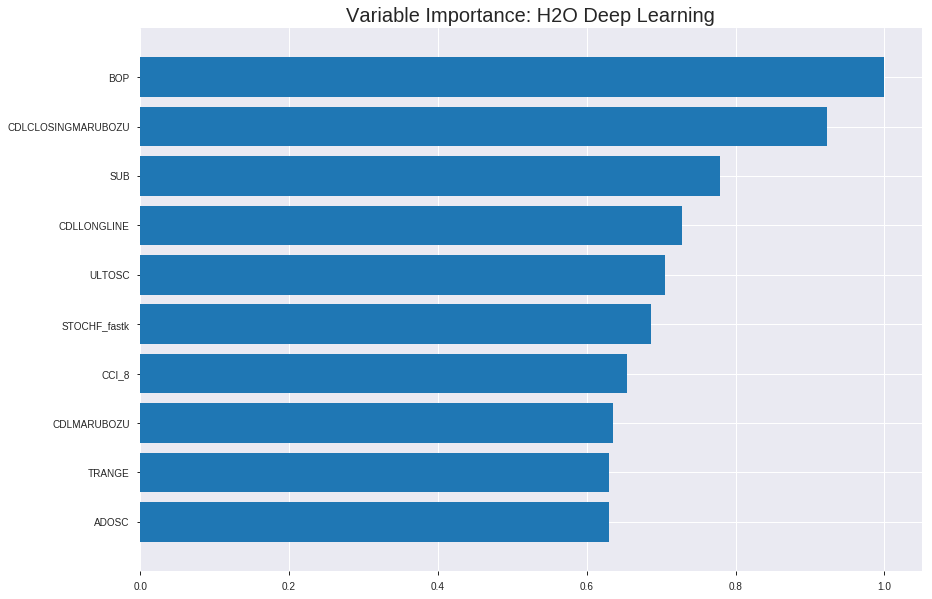

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_184331_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21627553442526354
RMSE: 0.4650543349171831
LogLoss: 0.6203722904052601
Mean Per-Class Error: 0.3103755589605679
AUC: 0.7558039390433305
pr_auc: 0.7552418933249562
Gini: 0.5116078780866611
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5398183910407841: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      357  492   0.5795   (492.0/849.0)
1      88   816   0.0973   (88.0/904.0)
Total  445  1308  0.3309   (580.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539818     0.737794  251
max f2                       0.348743     0.849971  347
max f0point5                 0.64561      0.70365   175
max accuracy                 0.608542     0.691957  205
max precision                0.948545     1         0
max recall                   0.239011     1         388
max specificity              0.948545     1         0
max absolute_mcc             0.602259     0.38486   210
max min_per_class_accuracy   0.631244     0.683157  186
max mean_per_class_accuracy  0.643441     0.689624  177

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 62.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.914863           1.83143   1.83143            0.944444         0.928362  0.944444                    0.928362            0.0188053       0.0188053                  83.1428   83.1428
    2        0.0205362                   0.896572           1.83143   1.83143            0.944444         0.904351  0.944444                    0.916356            0.0188053       0.0376106                  83.1428   83.1428
    3        0.0302339                   0.887406           1.71102   1.79281            0.882353         0.893273  0.924528                    0.908952            0.0165929       0.0542035                  71.1023   79.2808
    4        0.040502                    0.8725             1.50824   1.72066            0.777778         0.881048  0.887324                    0.901878            0.0154867       0.0696903                  50.8235   72.0662
    5        0.0501997                   0.860589           1.82509   1.74084            0.941176         0.865139  0.897727                    0.894781            0.0176991       0.0873894                  82.5091   74.0836
    6        0.100399                    0.816754           1.63066   1.68575            0.840909         0.838668  0.869318                    0.866724            0.0818584       0.169248                   63.0657   68.5746
    7        0.150029                    0.78088            1.58253   1.6516             0.816092         0.797979  0.851711                    0.843983            0.0785398       0.247788                   58.2532   65.1603
    8        0.200228                    0.754743           1.36623   1.58006            0.704545         0.767848  0.814815                    0.824895            0.0685841       0.316372                   36.6226   58.0056
    9        0.300057                    0.705322           1.22998   1.46359            0.634286         0.729221  0.754753                    0.793065            0.122788        0.439159                   22.9981   46.3586
    10       0.399886                    0.66677            1.28539   1.4191             0.662857         0.687144  0.731812                    0.766622            0.128319        0.567478                   28.5386   41.9099
    11       0.500285                    0.631638           1.11281   1.35763            0.573864         0.649804  0.700114                    0.743179            0.111726        0.679204                   11.2813   35.7633
    12       0.600114                    0.60367            1.03052   1.30322            0.531429         0.618688  0.672053                    0.72247             0.102876        0.78208                    3.05247   30.3218
    13       0.699943                    0.561941           0.775664  1.22798            0.4              0.583466  0.633252                    0.702644            0.0774336       0.859513                   -22.4336  22.7976
    14       0.799772                    0.491703           0.742421  1.16737            0.382857         0.531542  0.601997                    0.681287            0.074115        0.933628                   -25.7579  16.7368
    15       0.899601                    0.401242           0.376751  1.07963            0.194286         0.447959  0.556753                    0.655394            0.0376106       0.971239                   -62.3249  7.96334
    16       1                           0.152972           0.286467  1                  0.147727         0.321932  0.515687                    0.621915         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2226263005221992
RMSE: 0.47183291589523424
LogLoss: 0.6378593665506818
Mean Per-Class Error: 0.3138099339649727
AUC: 0.7319839219064025
pr_auc: 0.7036852606782313
Gini: 0.463967843812805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49016054747168974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   162  0.6667   (162.0/243.0)
1      12   246  0.0465   (12.0/258.0)
Total  93   408  0.3473   (174.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490161     0.738739  312
max f2                       0.447683     0.854409  334
max f0point5                 0.603318     0.690377  225
max accuracy                 0.603318     0.688623  225
max precision                0.924427     1         0
max recall                   0.279782     1         389
max specificity              0.924427     1         0
max absolute_mcc             0.603318     0.377955  225
max min_per_class_accuracy   0.62835      0.666667  196
max mean_per_class_accuracy  0.603318     0.68619   225

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 61.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.914545           1.61822   1.61822            0.833333         0.919287  0.833333                    0.919287            0.0193798       0.0193798                  61.8217   61.8217
    2        0.0219561                   0.905475           1.16512   1.41226            0.6              0.908593  0.727273                    0.914426            0.0116279       0.0310078                  16.5116   41.2262
    3        0.0319361                   0.880698           1.94186   1.57776            1                0.892559  0.8125                      0.907593            0.0193798       0.0503876                  94.186    57.7762
    4        0.0419162                   0.867355           1.16512   1.47951            0.6              0.875007  0.761905                    0.899834            0.0116279       0.0620155                  16.5116   47.9513
    5        0.0518962                   0.844124           1.55349   1.49374            0.8              0.854239  0.769231                    0.891066            0.0155039       0.0775194                  55.3488   49.3739
    6        0.101796                    0.794655           1.63116   1.5611             0.84             0.815672  0.803922                    0.854108            0.0813953       0.158915                   63.1163   56.1104
    7        0.151697                    0.757464           1.39814   1.5075             0.72             0.778393  0.776316                    0.829202            0.0697674       0.228682                   39.814    50.7497
    8        0.201597                    0.733978           1.39814   1.48043            0.72             0.74467   0.762376                    0.808278            0.0697674       0.29845                    39.814    48.0428
    9        0.301397                    0.690268           1.24279   1.40174            0.64             0.709938  0.721854                    0.775715            0.124031        0.422481                   24.2791   40.174
    10       0.401198                    0.658996           1.32047   1.38152            0.68             0.6737    0.711443                    0.750338            0.131783        0.554264                   32.0465   38.1523
    11       0.500998                    0.631657           1.0486    1.3152             0.54             0.645402  0.677291                    0.729435            0.104651        0.658915                   4.86047   31.5204
    12       0.600798                    0.598131           1.12628   1.28382            0.58             0.6126    0.66113                     0.710027            0.112403        0.771318                   12.6279   28.3821
    13       0.700599                    0.551816           0.854419  1.22265            0.44             0.577177  0.62963                     0.691102            0.0852713       0.856589                   -14.5581  22.2653
    14       0.800399                    0.499397           0.776744  1.16705            0.4              0.524485  0.600998                    0.670327            0.0775194       0.934109                   -22.3256  16.7053
    15       0.9002                      0.408049           0.388372  1.08073            0.2              0.455571  0.556541                    0.646518            0.0387597       0.972868                   -61.1628  8.0725
    16       1                           0.178362           0.27186   1                  0.14             0.330386  0.51497                     0.614968           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:50:12  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:50:13  1 min 44.522 sec  651 obs/sec       0.532801  1             934        0.502149         0.773484            -0.00960754    0.719546        0.711125           1.61597          0.363377                         0.509765           0.785623              -0.0403728       0.680161          0.668132             1.61822            0.349301
    2019-08-27 18:50:25  1 min 55.704 sec  1011 obs/sec      6.62864   12            11620      0.465054         0.620372            0.134045       0.755804        0.755242           1.83143          0.330861                         0.471833           0.637859              0.108696         0.731984          0.703685             1.61822            0.347305
    2019-08-27 18:50:36  2 min  7.289 sec  1138 obs/sec      14.2635   26            25004      0.449697         0.591718            0.190293       0.758923        0.756586           1.61597          0.320593                         0.46917            0.643731              0.11873          0.715882          0.691684             1.61822            0.363273
    2019-08-27 18:50:48  2 min 18.961 sec  1242 obs/sec      23.0513   42            40409      0.453215         0.595087            0.177577       0.770278        0.774152           1.83143          0.321734                         0.473357           0.642367              0.10293          0.714327          0.680538             1.29457            0.351297
    2019-08-27 18:50:59  2 min 30.314 sec  1306 obs/sec      31.8922   58            55907      0.43701          0.561205            0.235338       0.782739        0.785123           1.93916          0.30405                          0.468472           0.643963              0.121349         0.709526          0.669656             0.97093            0.341317
    2019-08-27 18:51:10  2 min 41.498 sec  1350 obs/sec      40.6549   74            71268      0.432786         0.551675            0.250047       0.790933        0.789197           1.83143          0.306902                         0.471376           0.647803              0.110421         0.707875          0.670767             0.97093            0.341317
    2019-08-27 18:51:23  2 min 53.670 sec  1386 obs/sec      50.502    92            88530      0.43389          0.55561             0.246216       0.799394        0.798508           1.93916          0.302909                         0.468527           0.643515              0.121143         0.710746          0.676279             0.97093            0.335329
    2019-08-27 18:51:24  2 min 54.849 sec  1385 obs/sec      50.502    92            88530      0.465054         0.620372            0.134045       0.755804        0.755242           1.83143          0.330861                         0.471833           0.637859              0.108696         0.731984          0.703685             1.61822            0.347305

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.031556462385317015
CDLCLOSINGMARUBOZU  0.9231396913528442     0.9231396913528442   0.029131022946569187
SUB                 0.7787177562713623     0.7787177562713623   0.02457357758455571
CDLLONGLINE         0.727719247341156      0.727719247341156    0.0229642450557924
ULTOSC              0.7057817578315735     0.7057817578315735   0.02227197549325497
---                 ---                    ---                  ---
CMO_24              0.4962466061115265     0.4962466061115265   0.015659787359599615
SAR_0.14            0.4951671361923218     0.4951671361923218   0.01562572310769815
CMO_8               0.4942110776901245     0.4942110776901245   0.0155955532835354
WILLR_14            0.4929474890232086     0.4929474890232086   0.015555678895297355
ROCP_8              0.48643895983695984    0.48643895983695984  0.015350292738847757


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.7532467532467532)

('auc', 0.7660521296884933)

('logloss', 0.6062594730846858)

('mean_per_class_error', 0.2895104895104895)

('rmse', 0.4563942127653941)

('mse', 0.20829567744574384)

deeplearning prediction progress: |███████████████████████████████████████| 100%


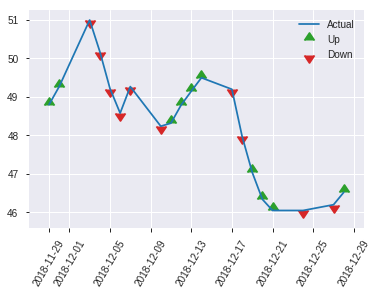


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20829567744574384
RMSE: 0.4563942127653941
LogLoss: 0.6062594730846858
Mean Per-Class Error: 0.2895104895104895
AUC: 0.7660521296884933
pr_auc: 0.7382599671964971
Gini: 0.5321042593769867
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4955751335445684: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   62   0.5124   (62.0/121.0)
1      14   116  0.1077   (14.0/130.0)
Total  73   178  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495575     0.753247  177
max f2                       0.443123     0.857538  202
max f0point5                 0.59597      0.72807   109
max accuracy                 0.550919     0.713147  145
max precision                0.921393     1         0
max recall                   0.308125     1         238
max specificity              0.921393     1         0
max absolute_mcc             0.550919     0.426436  145
max min_per_class_accuracy   0.575137     0.676923  126
max mean_per_class_accuracy  0.550919     0.71049   145

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 56.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.884094           1.28718   1.28718            0.666667         0.908296  0.666667                    0.908296            0.0153846       0.0153846                  28.7179   28.7179
    2        0.0239044                   0.865269           1.93077   1.60897            1                0.874328  0.833333                    0.891312            0.0230769       0.0384615                  93.0769   60.8974
    3        0.0318725                   0.857479           1.93077   1.68942            1                0.862223  0.875                       0.88404             0.0153846       0.0538462                  93.0769   68.9423
    4        0.0438247                   0.838233           1.28718   1.57972            0.666667         0.845094  0.818182                    0.873418            0.0153846       0.0692308                  28.7179   57.972
    5        0.0517928                   0.796929           0.965385  1.48521            0.5              0.813649  0.769231                    0.864223            0.00769231      0.0769231                  -3.46154  48.5207
    6        0.103586                    0.721819           1.48521   1.48521            0.769231         0.755559  0.769231                    0.809891            0.0769231       0.153846                   48.5207   48.5207
    7        0.151394                    0.69689            1.76987   1.5751             0.916667         0.708233  0.815789                    0.777788            0.0846154       0.238462                   76.9872   57.5101
    8        0.203187                    0.675698           1.63373   1.59005            0.846154         0.68583   0.823529                    0.754348            0.0846154       0.323077                   63.3728   59.0045
    9        0.302789                    0.641048           1.39015   1.52429            0.72             0.654341  0.789474                    0.721451            0.138462        0.461538                   39.0154   52.4291
    10       0.40239                     0.608489           1.15846   1.43374            0.6              0.622019  0.742574                    0.696839            0.115385        0.576923                   15.8462   43.374
    11       0.501992                    0.576053           0.926769  1.33315            0.48             0.591809  0.690476                    0.676               0.0923077       0.669231                   -7.32308  33.315
    12       0.601594                    0.54406            1.15846   1.30423            0.6              0.560526  0.675497                    0.656882            0.115385        0.784615                   15.8462   30.4228
    13       0.701195                    0.50276            0.926769  1.25061            0.48             0.523755  0.647727                    0.637972            0.0923077       0.876923                   -7.32308  25.0612
    14       0.800797                    0.446182           0.695077  1.18152            0.36             0.472166  0.61194                     0.617349            0.0692308       0.946154                   -30.4923  18.1515
    15       0.900398                    0.37009            0.308923  1.08499            0.16             0.411113  0.561947                    0.594535            0.0307692       0.976923                   -69.1077  8.49898
    16       1                           0.199428           0.231692  1                  0.12             0.298825  0.517928                    0.565082            

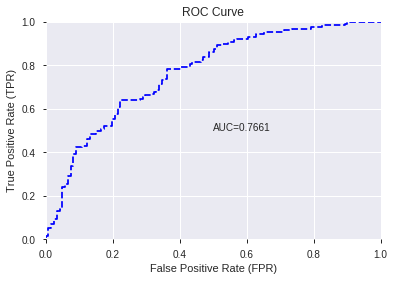

This function is available for GLM models only


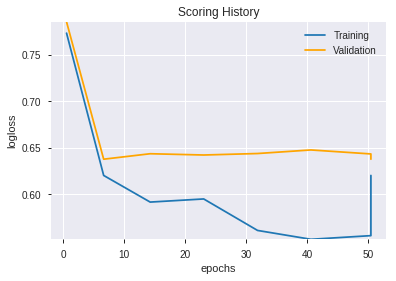

--2019-08-27 18:52:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_184331_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_184331_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLLONGLINE',
 'ULTOSC',
 'STOCHF_fastk',
 'CCI_8',
 'CDLMARUBOZU',
 'TRANGE',
 'ADOSC',
 'DIV',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'LINEARREG_INTERCEPT_8',
 'CCI_12',
 'CDLENGULFING',
 'WILLR_24',
 'CCI_24',
 'STOCHRSI_fastd',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CCI_14',
 'SAR_0.12',
 'CCI_20',
 'MINUS_DI_8',
 'WILLR_12',
 'STOCHF_fastd',
 'RSI_20',
 'MOM_8',
 'CDLBELTHOLD',
 'LINEARREG_ANGLE_8',
 'SAR_0.08',
 'CMO_14',
 'RSI_12',
 'STOCH_slowk',
 'WILLR_8',
 'SAR_0.3',
 'ROCR100_8',
 'RSI_14',
 'CCI_30',
 'ROCR_8',
 'ROC_8',
 'CMO_12',
 'RSI_8',
 'SAR_0.2',
 'WILLR_30',
 'CMO_20',
 'SAR_0.24',
 'WILLR_20',
 'RSI_24',
 'CMO_24',
 'SAR_0.14',
 'CMO_8',
 'WILLR_14',
 'ROCP_8']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_185251_model_1  0.760903  0.594216              0.300064  0.451769  0.204095

variable  relative_importance  scaled_importance  percentage
0                     BOP             0.375533           1.000000    0.094099
1      CDLCLOSINGMARUBOZU             0.206842           0.550794    0.051829
2                     SUB             0.201139           0.535608    0.050400
3                  ULTOSC             0.199910           0.532337    0.050092
4            STOCHF_fastk             0.152432           0.405907    0.038195
5                WILLR_30             0.147367           0.392420    0.036926
6                   CCI_8             0.146127           0.389118    0.036616
7                  CCI_12             0.139726           0.372073    0.035012
8                 WILLR_8             0.138576           0.369012    0.034724
9                     DIV             0.138190           0.367983    0.034627
10            CDLLONGLINE             0.135367           0.360467    0.033920
11                 CCI_14             0.133331           0.355043    0.033409
12          CDLHANGINGMAN             0.133186           0.354658    0.033373
13               WILLR_24             0.118418           0.315333    0.029673
14                 CCI_20             0.108043           0.287707    0.027073
15      LINEARREG_ANGLE_8             0.105418           0.280715    0.026415
16         STOCHRSI_fastk             0.091111           0.242617    0.022830
17            CDLMARUBOZU             0.085348           0.227272    0.021386
18               WILLR_12             0.073747           0.196379    0.018479
19      CDLLONGLEGGEDDOJI             0.066288           0.176518    0.016610
20                 RSI_24             0.057934           0.154271    0.014517
21                 CMO_24             0.057444           0.152966    0.014394
22            CDLBELTHOLD             0.054337           0.144693    0.013615
23               WILLR_14             0.051512           0.137171    0.012908
24                 CCI_24             0.048623           0.129478    0.012184
25               SAR_0.12             0.042999           0.114501    0.010774
26                 CMO_20             0.042225           0.112441    0.010581
27                 RSI_20             0.041791           0.111284    0.010472
28           CDLENGULFING             0.041531           0.110591    0.010407
29               WILLR_20             0.040365           0.107488    0.010115
30                CDLDOJI             0.036488           0.097163    0.009143
31                SAR_0.3             0.036088           0.096097    0.009043
32                 CMO_12             0.035867           0.095510    0.008987
33                 RSI_12             0.035724           0.095129    0.008952
34                  ROC_8             0.034848           0.092797    0.008732
35                 ROCP_8             0.034709           0.092426    0.008697
36                 ROCR_8             0.034674           0.092332    0.008688
37                 CMO_14             0.034574           0.092066    0.008663
38              ROCR100_8             0.034500           0.091869    0.008645
39                  RSI_8             0.033596           0.089461    0.008418
40               SAR_0.14             0.033538           0.089307    0.008404
41                 RSI_14             0.033336           0.088770    0.008353
42                  CMO_8             0.032007           0.085231    0.008020
43                 TRANGE             0.023487           0.062544    0.005885
44  LINEARREG_INTERCEPT_8             0.021270           0.056638    0.005330
45                  ADOSC             0.020926           0.055725    0.005244
46            STOCH_slowk             0.018761           0.049959    0.004701
47           STOCHF_fastd             0.018595           0.049515    0.004659
48         STOCHRSI_fastd             0.017201           0.045806    0.004310
49                 CCI_30             0.014989           0.039914    0.003756
50             MINUS_DI_8             0

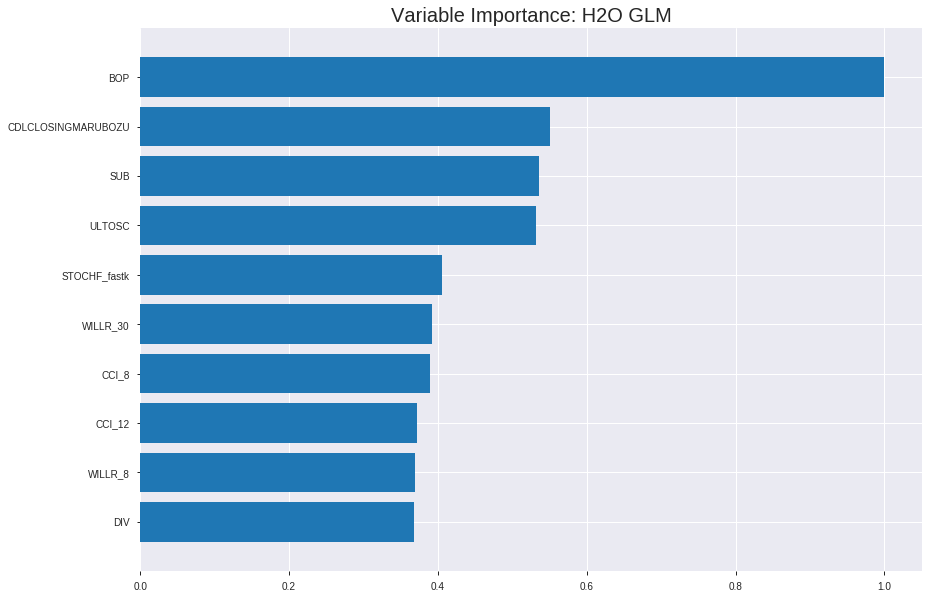

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_185251_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20055838212719254
RMSE: 0.44783745056347457
LogLoss: 0.5851992292552716
Null degrees of freedom: 1752
Residual degrees of freedom: 1697
Null deviance: 2428.4481185881305
Residual deviance: 2051.708497768982
AIC: 2163.708497768982
AUC: 0.7557140362946517
pr_auc: 0.7537980098218406
Gini: 0.5114280725893035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3660567145233263: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      344  505   0.5948   (505.0/849.0)
1      82   822   0.0907   (82.0/904.0)
Total  426  1327  0.3349   (587.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366057     0.736889  272
max f2                       0.165031     0.850418  358
max f0point5                 0.592435     0.697769  152
max accuracy                 0.51759      0.688534  195
max precision                0.933359     1         0
max recall                   0.0726439    1         389
max specificity              0.933359     1         0
max absolute_mcc             0.468705     0.3805    221
max min_per_class_accuracy   0.539118     0.683628  183
max mean_per_class_accuracy  0.51759      0.687295  195

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.895782           1.93916   1.93916            1                0.911843  1                           0.911843            0.0199115       0.0199115                  93.9159   93.9159
    2        0.0205362                   0.872167           1.61597   1.77756            0.833333         0.883794  0.916667                    0.897818            0.0165929       0.0365044                  61.5966   77.7563
    3        0.0302339                   0.857567           1.48289   1.68304            0.764706         0.864798  0.867925                    0.887227            0.0143805       0.050885                   48.2887   68.3044
    4        0.040502                    0.842801           1.61597   1.66604            0.833333         0.850307  0.859155                    0.877867            0.0165929       0.0674779                  61.5966   66.6038
    5        0.0501997                   0.831075           1.93916   1.7188             1                0.837346  0.886364                    0.870039            0.0188053       0.0862832                  93.9159   71.88
    6        0.100399                    0.768565           1.67473   1.69676            0.863636         0.797839  0.875                       0.833939            0.0840708       0.170354                   67.4728   69.6764
    7        0.150029                    0.723111           1.49338   1.62948            0.770115         0.743454  0.840304                    0.804007            0.074115        0.244469                   49.3376   62.9484
    8        0.200228                    0.692252           1.4103    1.57453            0.727273         0.706021  0.811966                    0.779441            0.0707965       0.315265                   41.0298   57.4531
    9        0.300057                    0.636691           1.35187   1.50045            0.697143         0.665875  0.773764                    0.741657            0.134956        0.450221                   35.1871   50.0452
    10       0.399886                    0.590831           1.22998   1.43293            0.634286         0.612422  0.738944                    0.709395            0.122788        0.573009                   22.9981   43.2931
    11       0.500285                    0.540691           1.05772   1.35763            0.545455         0.567694  0.700114                    0.680958            0.106195        0.679204                   5.77233   35.7633
    12       0.600114                    0.48116            1.00836   1.29953            0.52             0.512728  0.670152                    0.652973            0.100664        0.779867                   0.836283  29.9532
    13       0.699943                    0.409955           0.797826  1.22798            0.411429         0.444942  0.633252                    0.623302            0.079646        0.859513                   -20.2174  22.7976
    14       0.799772                    0.327906           0.753502  1.16875            0.388571         0.369956  0.60271                     0.591679            0.0752212       0.934735                   -24.6498  16.8751
    15       0.899601                    0.224831           0.387832  1.08209            0.2              0.279233  0.558022                    0.557007            0.0387168       0.973451                   -61.2168  8.20927
    16       1                           0.0158859          0.264431  1                  0.136364         0.145454  0.515687                    0.515687           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20939659605743757
RMSE: 0.4575987282078454
LogLoss: 0.609386636687798
Null degrees of freedom: 500
Residual degrees of freedom: 445
Null deviance: 694.0853381814004
Residual deviance: 610.6054099611736
AIC: 722.6054099611736
AUC: 0.7323268574345233
pr_auc: 0.6995398733336134
Gini: 0.4646537148690466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37607555346024646: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   150  0.6173   (150.0/243.0)
1      23   235  0.0891   (23.0/258.0)
Total  116  385  0.3453   (173.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376076     0.730949  294
max f2                       0.264468     0.855397  343
max f0point5                 0.507819     0.691114  223
max accuracy                 0.507819     0.688623  223
max precision                0.754464     0.8125    40
max recall                   0.0716206    1         395
max specificity              0.919678     0.995885  0
max absolute_mcc             0.466124     0.38353   244
max min_per_class_accuracy   0.552416     0.662791  194
max mean_per_class_accuracy  0.507819     0.686429  223

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.891735           1.29457   1.29457            0.666667         0.90553   0.666667                    0.90553             0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.873096           1.16512   1.23573            0.6              0.882608  0.636364                    0.895111            0.0116279       0.0271318                  16.5116   23.5729
    3        0.0319361                   0.860795           1.55349   1.33503            0.8              0.863602  0.6875                      0.885265            0.0155039       0.0426357                  55.3488   33.5029
    4        0.0419162                   0.821676           1.16512   1.29457            0.6              0.840202  0.666667                    0.874535            0.0116279       0.0542636                  16.5116   29.4574
    5        0.0518962                   0.799912           1.55349   1.34436            0.8              0.811296  0.692308                    0.862374            0.0155039       0.0697674                  55.3488   34.4365
    6        0.101796                    0.751817           1.78651   1.5611             0.92             0.776863  0.803922                    0.820457            0.0891473       0.158915                   78.6512   56.1104
    7        0.151697                    0.713122           1.55349   1.5586             0.8              0.726721  0.802632                    0.789623            0.0775194       0.236434                   55.3488   55.8599
    8        0.201597                    0.678549           1.24279   1.48043            0.64             0.69158   0.762376                    0.765355            0.0620155       0.29845                    24.2791   48.0428
    9        0.301397                    0.635732           1.39814   1.45318            0.72             0.656079  0.748344                    0.729171            0.139535        0.437984                   39.814    45.318
    10       0.401198                    0.596646           1.12628   1.37186            0.58             0.614817  0.706468                    0.700725            0.112403        0.550388                   12.6279   37.1862
    11       0.500998                    0.552478           1.08744   1.3152             0.56             0.575014  0.677291                    0.675683            0.108527        0.658915                   8.74419   31.5204
    12       0.600798                    0.49372            1.16512   1.29027            0.6              0.525697  0.664452                    0.650768            0.116279        0.775194                   16.5116   29.0273
    13       0.700599                    0.42174            0.737907  1.21159            0.38             0.453057  0.623932                    0.622604            0.0736434       0.848837                   -26.2093  21.1588
    14       0.800399                    0.344763           0.776744  1.15737            0.4              0.385789  0.59601                     0.593076            0.0775194       0.926357                   -22.3256  15.7368
    15       0.9002                      0.24508            0.504884  1.08503            0.26             0.297748  0.558758                    0.560335            0.0503876       0.976744                   -49.5116  8.50307
    16       1                           0.0439334          0.233023  1                  0.12             0.168402  0.51497                     0.52122           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:52:52  0.000 sec   2            17        56            1.3582            1.36776
    2019-08-27 18:52:52  0.013 sec   4            11        56            1.34772           1.36076
    2019-08-27 18:52:52  0.027 sec   6            6.7       56            1.33497           1.35191
    2019-08-27 18:52:52  0.040 sec   8            4.1       56            1.31986           1.34086
    2019-08-27 18:52:52  0.054 sec   10           2.6       56            1.30234           1.32724
    2019-08-27 18:52:52  0.068 sec   12           1.6       56            1.28267           1.31112
    2019-08-27 18:52:52  0.081 sec   14           0.99      56            1.26184           1.29328
    2019-08-27 18:52:52  0.095 sec   16           0.62      56            1.24134           1.2752
    2019-08-27 18:52:52  0.108 sec   18           0.38      56            1.22268           1.2584
    2019-08-27 18:52:52  0.123 sec   20           0.24      56            1.20681           1.24406
    2019-08-27 18:52:52  0.136 sec   22           0.15      56            1.19395           1.23275
    2019-08-27 18:52:52  0.149 sec   24           0.092     56            1.18388           1.2248
    2019-08-27 18:52:52  0.164 sec   26           0.057     56            1.1762            1.22031
    2019-08-27 18:52:52  0.180 sec   28           0.035     56            1.1704            1.21877
    2019-08-27 18:52:52  0.194 sec   30           0.022     56            1.16601           1.21973
    2019-08-27 18:52:52  0.208 sec   32           0.014     56            1.16269           1.22247
    2019-08-27 18:52:52  0.222 sec   34           0.0085    56            1.16017           1.22618
    2019-08-27 18:52:52  0.237 sec   36           0.0053    56            1.15829           1.23023
    2019-08-27 18:52:52  0.250 sec   38           0.0033    56            1.15683           1.23373

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.7482993197278912)

('auc', 0.7609027336300064)

('logloss', 0.594216072338356)

('mean_per_class_error', 0.29863318499682134)

('rmse', 0.45176892981564104)

('mse', 0.2040951659467696)

glm prediction progress: |████████████████████████████████████████████████| 100%


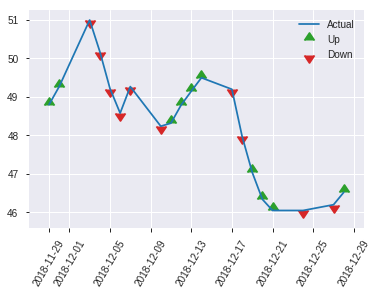


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2040951659467696
RMSE: 0.45176892981564104
LogLoss: 0.594216072338356
Null degrees of freedom: 250
Residual degrees of freedom: 195
Null deviance: 347.642153441148
Residual deviance: 298.2964683138547
AIC: 410.2964683138547
AUC: 0.7609027336300064
pr_auc: 0.7327480813224464
Gini: 0.5218054672600128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38570377242269704: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   54   0.4463   (54.0/121.0)
1      20   110  0.1538   (20.0/130.0)
Total  87   164  0.2948   (74.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385704     0.748299  163
max f2                       0.139807     0.857713  231
max f0point5                 0.552253     0.718623  90
max accuracy                 0.418665     0.705179  153
max precision                0.905863     1         0
max recall                   0.105775     1         242
max specificity              0.905863     1         0
max absolute_mcc             0.385704     0.41986   163
max min_per_class_accuracy   0.462937     0.68595   127
max mean_per_class_accuracy  0.418665     0.701367  153

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 46.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.882421           1.93077   1.93077            1                0.894386  1                           0.894386            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.855509           0.64359   1.28718            0.333333         0.865882  0.666667                    0.880134            0.00769231      0.0307692                  -35.641   28.7179
    3        0.0318725                   0.848643           1.93077   1.44808            1                0.852997  0.75                        0.873349            0.0153846       0.0461538                  93.0769   44.8077
    4        0.0438247                   0.83273            1.28718   1.4042             0.666667         0.839262  0.727273                    0.864053            0.0153846       0.0615385                  28.7179   40.4196
    5        0.0517928                   0.790285           1.93077   1.48521            1                0.796607  0.769231                    0.853676            0.0153846       0.0769231                  93.0769   48.5207
    6        0.103586                    0.702743           1.63373   1.55947            0.846154         0.742345  0.807692                    0.798011            0.0846154       0.161538                   63.3728   55.9467
    7        0.151394                    0.661114           1.76987   1.62591            0.916667         0.673816  0.842105                    0.758791            0.0846154       0.246154                   76.9872   62.5911
    8        0.203187                    0.631703           1.48521   1.59005            0.769231         0.642492  0.823529                    0.729146            0.0769231       0.323077                   48.5207   59.0045
    9        0.302789                    0.580457           1.23569   1.47348            0.64             0.602311  0.763158                    0.687424            0.123077        0.446154                   23.5692   47.3482
    10       0.40239                     0.528088           1.31292   1.43374            0.68             0.557397  0.742574                    0.655239            0.130769        0.576923                   31.2923   43.374
    11       0.501992                    0.464682           1.08123   1.3638             0.56             0.497757  0.706349                    0.623993            0.107692        0.684615                   8.12308   36.3797
    12       0.601594                    0.431726           1.004     1.30423            0.52             0.448333  0.675497                    0.59491             0.1             0.784615                   0.4       30.4228
    13       0.701195                    0.343736           0.695077  1.2177             0.36             0.38731   0.630682                    0.565421            0.0692308       0.853846                   -30.4923  21.7701
    14       0.800797                    0.284397           0.926769  1.18152            0.48             0.312156  0.61194                     0.533921            0.0923077       0.946154                   -7.32308  18.1515
    15       0.900398                    0.174679           0.308923  1.08499            0.16             0.231957  0.561947                    0.500518            0.0307692       0.976923                   -69.1077  8.49898
    16       1                           0.0380397          0.231692  1                  0.12             0.111961  0.517928                    0.461817          

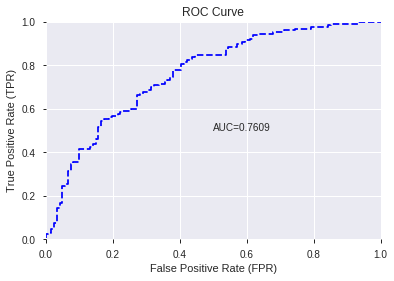

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


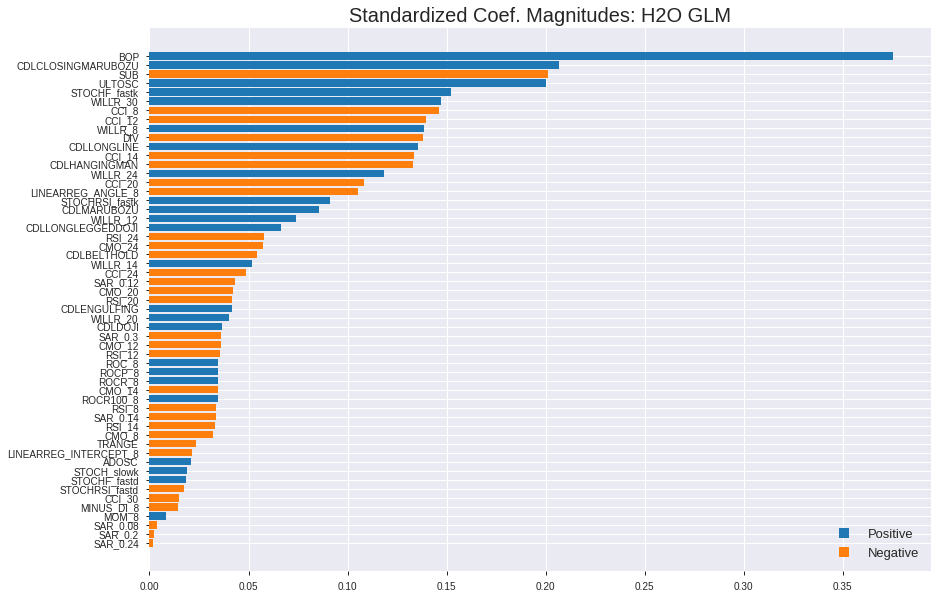

'log_likelihood'
--2019-08-27 18:52:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_185251_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_185251_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'ULTOSC',
 'STOCHF_fastk',
 'WILLR_30',
 'CCI_8',
 'CCI_12',
 'WILLR_8',
 'DIV',
 'CDLLONGLINE',
 'CCI_14',
 'CDLHANGINGMAN',
 'WILLR_24',
 'CCI_20',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'WILLR_12',
 'CDLLONGLEGGEDDOJI',
 'RSI_24',
 'CMO_24',
 'CDLBELTHOLD',
 'WILLR_14',
 'CCI_24',
 'SAR_0.12',
 'CMO_20',
 'RSI_20',
 'CDLENGULFING',
 'WILLR_20',
 'CDLDOJI',
 'SAR_0.3',
 'CMO_12',
 'RSI_12',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'CMO_14',
 'ROCR100_8',
 'RSI_8',
 'SAR_0.14',
 'RSI_14',
 'CMO_8',
 'TRANGE',
 'LINEARREG_INTERCEPT_8',
 'ADOSC',
 'STOCH_slowk',
 'STOCHF_fastd',
 'STOCHRSI_fastd',
 'CCI_30',
 'MINUS_DI_8',
 'MOM_8',
 'SAR_0.08',
 'SAR_0.2',
 'SAR_0.24']

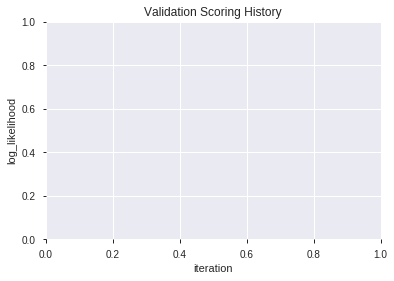

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_185303_model_2  0.740496  0.606895              0.295931  0.457048  0.208893
1               XGBoost_1_AutoML_20190827_185303  0.739860  0.597860              0.339828  0.454840  0.206879
2  XGBoost_grid_1_AutoML_20190827_185303_model_4  0.739415  0.600762              0.318023  0.454768  0.206814
3  XGBoost_grid_1_AutoML_20190827_185303_model_3  0.735410  0.607741              0.334838  0.458028  0.209790
4               XGBoost_3_AutoML_20190827_185303  0.732041  0.605326              0.326287  0.457708  0.209497
5               XGBoost_2_AutoML_20190827_185303  0.731977  0.602865              0.319167  0.456263  0.208176
6  XGBoost_grid_1_AutoML_20190827_185303_model_6  0.730706  0.607979              0.338970  0.458927  0.210614
7  XGBoost_grid_1_AutoML_20190827_185303_model_7  0.726065  0.606915              0.356929  0.459068  0.210744
8  XGBoost_grid_1_AutoML_20190827_185303_model_1  0.724730  0.610372              0.312746  0.460194  0.211779
9  XGBoost_grid_1_AutoML_20190827_185303_model_5  0.702479  0.637359              0.381723  0.472484  0.223241

variable  relative_importance  scaled_importance  percentage
0                     BOP          2123.569580           1.000000    0.286027
1                     SUB           655.346313           0.308606    0.088270
2            STOCHF_fastk           380.673004           0.179261    0.051274
3                   CCI_8           287.062073           0.135179    0.038665
4                     DIV           263.038116           0.123866    0.035429
5                  ULTOSC           253.680099           0.119459    0.034169
6              MINUS_DI_8           226.223892           0.106530    0.030470
7                  CCI_12           201.945084           0.095097    0.027200
8                  CMO_24           169.606689           0.079869    0.022845
9                 WILLR_8           157.612061           0.074220    0.021229
10                 TRANGE           152.913666           0.072008    0.020596
11                  ADOSC           147.682159           0.069544    0.019892
12            STOCH_slowk           144.499252           0.068045    0.019463
13         STOCHRSI_fastd           140.235352           0.066038    0.018889
14                 CCI_30           137.031403           0.064529    0.018457
15  LINEARREG_INTERCEPT_8           132.276779           0.062290    0.017817
16      LINEARREG_ANGLE_8           119.013000           0.056044    0.016030
17               WILLR_12           117.941856           0.055539    0.015886
18               SAR_0.08           115.557861           0.054417    0.015565
19                 CCI_14           107.222252           0.050492    0.014442
20     CDLCLOSINGMARUBOZU           106.676773           0.050235    0.014368
21                  MOM_8            99.455200           0.046834    0.013396
22                 CMO_20            84.906929           0.039983    0.011436
23         STOCHRSI_fastk            83.683533           0.039407    0.011271
24               SAR_0.24            79.880157           0.037616    0.010759
25                 CCI_20            78.729164           0.037074    0.010604
26                  CMO_8            78.096031           0.036776    0.010519
27               SAR_0.14            75.035675           0.035335    0.010107
28                SAR_0.2            74.537361           0.035100    0.010040
29               WILLR_14            74.180511           0.034932    0.009992
30                 CCI_24            73.015343           0.034383    0.009835
31                SAR_0.3            61.480270           0.028951    0.008281
32               SAR_0.12            57.622623           0.027135    0.007761
33                  ROC_8            56.409264           0.026563    0.007598
34               WILLR_30            48.426640           0.022804    0.006523
35               WILLR_20            43.611782           0.020537    0.005874
36            CDLLONGLINE            39.366501           0.018538    0.005302
37                 CMO_12            36.100124           0.017000    0.004862
38                 CMO_14            33.596348           0.015821    0.004525
39               WILLR_24            21.295736           0.010028    0.002868
40            CDLBELTHOLD            19.207109           0.009045    0.002587
41                 RSI_14            17.525457           0.008253    0.002361
42           STOCHF_fastd            10.766926           0.005070    0.001450
43                 RSI_24             9.909189           0.004666    0.001335
44                 RSI_20             9.718122           0.004576    0.001309
45                CDLDOJI             8.416611           0.003963    0.001134
46           CDLENGULFING             4.087613           0.001925    0.000551
47                  RSI_8             3.022692           0.001423    0.000407
48          CDLHANGINGMAN             2.468948           0.001163    0.000333

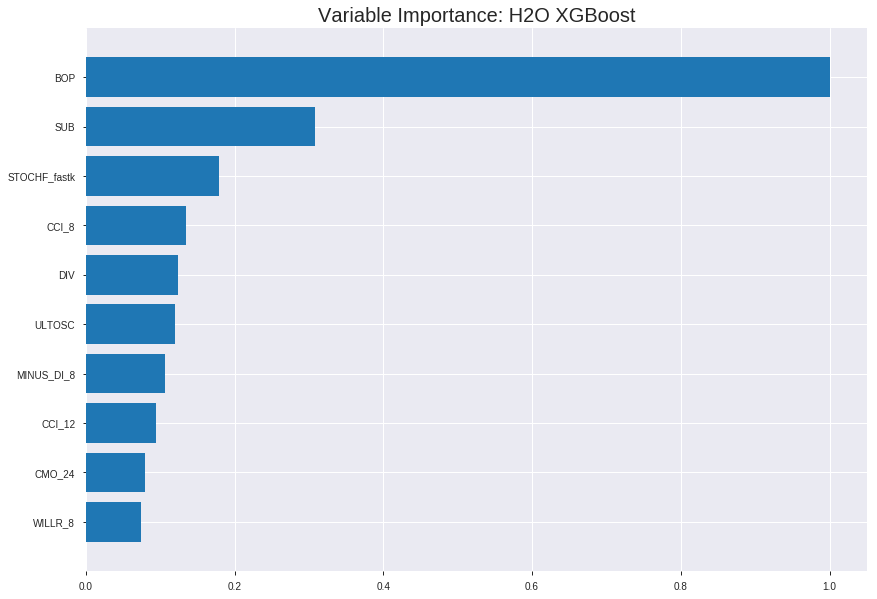

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_185303_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16358860134861444
RMSE: 0.40446087740177594
LogLoss: 0.5042386831256868
Mean Per-Class Error: 0.20814636167484912
AUC: 0.8684794448440122
pr_auc: 0.877485985040528
Gini: 0.7369588896880244
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5150605291128159: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      629  220  0.2591   (220.0/849.0)
1      156  748  0.1726   (156.0/904.0)
Total  785  968  0.2145   (376.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.515061     0.799145  191
max f2                       0.298021     0.874377  305
max f0point5                 0.628235     0.812212  127
max accuracy                 0.546567     0.791786  174
max precision                0.866005     1         0
max recall                   0.164012     1         374
max specificity              0.866005     1         0
max absolute_mcc             0.573218     0.58443   160
max min_per_class_accuracy   0.546567     0.791519  174
max mean_per_class_accuracy  0.573218     0.791854  160

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.838931           1.93916    1.93916            1                0.849465  1                           0.849465            0.0199115       0.0199115                  93.9159   93.9159
    2        0.0205362                   0.827222           1.93916    1.93916            1                0.830517  1                           0.839991            0.0199115       0.039823                   93.9159   93.9159
    3        0.0302339                   0.81566            1.93916    1.93916            1                0.82183   1                           0.834166            0.0188053       0.0586283                  93.9159   93.9159
    4        0.040502                    0.807183           1.93916    1.93916            1                0.810774  1                           0.828235            0.0199115       0.0785398                  93.9159   93.9159
    5        0.0501997                   0.799841           1.82509    1.91712            0.941176         0.803678  0.988636                    0.823491            0.0176991       0.0962389                  82.5091   91.7123
    6        0.100399                    0.76169            1.89509    1.90611            0.977273         0.779858  0.982955                    0.801675            0.0951327       0.191372                   89.5087   90.6105
    7        0.150029                    0.729878           1.85       1.88755            0.954023         0.746859  0.973384                    0.783542            0.0918142       0.283186                   85.0003   88.7547
    8        0.200228                    0.705517           1.63066    1.82314            0.840909         0.717399  0.940171                    0.766959            0.0818584       0.365044                   63.0657   82.3141
    9        0.300057                    0.659841           1.66214    1.76958            0.857143         0.682235  0.912548                    0.738772            0.165929        0.530973                   66.2137   76.9575
    10       0.399886                    0.611354           1.34079    1.66253            0.691429         0.635809  0.857347                    0.713068            0.13385         0.664823                   34.079    66.2532
    11       0.500285                    0.554114           1.1679     1.56327            0.602273         0.583893  0.806157                    0.687144            0.117257        0.78208                    16.7903   56.3268
    12       0.600114                    0.478945           0.775664   1.43225            0.4              0.515086  0.738593                    0.658522            0.0774336       0.859513                   -22.4336  43.225
    13       0.699943                    0.408946           0.554046   1.307              0.285714         0.446095  0.674002                    0.628225            0.0553097       0.914823                   -44.5954  30.6997
    14       0.799772                    0.293181           0.554046   1.21301            0.285714         0.353518  0.625535                    0.593936            0.0553097       0.970133                   -44.5954  21.3012
    15       0.899601                    0.203057           0.199456   1.10054            0.102857         0.243593  0.567533                    0.555058            0.0199115       0.990044                   -80.0544  10.0537
    16       1                           0.11522            0.0991616  1                  0.0511364        0.162239  0.515687                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21253993387213474
RMSE: 0.4610205351957055
LogLoss: 0.6152301352595634
Mean Per-Class Error: 0.31225476122116946
AUC: 0.7245430184706672
pr_auc: 0.6979149915232947
Gini: 0.4490860369413343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2810186743736267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      60   183  0.7531   (183.0/243.0)
1      10   248  0.0388   (10.0/258.0)
Total  70   431  0.3852   (193.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281019     0.719884  335
max f2                       0.281019     0.847573  335
max f0point5                 0.540778     0.695489  204
max accuracy                 0.540778     0.688623  204
max precision                0.758389     0.837838  31
max recall                   0.125458     1         399
max specificity              0.859989     0.995885  0
max absolute_mcc             0.540778     0.376241  204
max min_per_class_accuracy   0.562092     0.682171  192
max mean_per_class_accuracy  0.540778     0.687745  204

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 52.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.818328           1.29457   1.29457            0.666667         0.842288  0.666667                    0.842288            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.806892           1.55349   1.41226            0.8              0.810474  0.727273                    0.827827            0.0155039       0.0310078                  55.3488   41.2262
    3        0.0319361                   0.795443           1.16512   1.33503            0.6              0.800014  0.6875                      0.819136            0.0116279       0.0426357                  16.5116   33.5029
    4        0.0419162                   0.788184           1.94186   1.47951            1                0.791187  0.761905                    0.812481            0.0193798       0.0620155                  94.186    47.9513
    5        0.0518962                   0.782213           1.94186   1.56843            1                0.78426   0.807692                    0.807054            0.0193798       0.0813953                  94.186    56.8426
    6        0.101796                    0.745034           1.32047   1.44688            0.68             0.759869  0.745098                    0.783924            0.0658915       0.147287                   32.0465   44.6876
    7        0.151697                    0.710781           1.55349   1.48195            0.8              0.72393   0.763158                    0.764189            0.0775194       0.224806                   55.3488   48.1946
    8        0.201597                    0.691324           1.70884   1.53811            0.88             0.701347  0.792079                    0.748634            0.0852713       0.310078                   70.8837   53.8107
    9        0.301397                    0.653925           1.12628   1.40174            0.58             0.670274  0.721854                    0.722687            0.112403        0.422481                   12.6279   40.174
    10       0.401198                    0.603716           1.20395   1.35254            0.62             0.629624  0.696517                    0.699537            0.120155        0.542636                   20.3953   35.254
    11       0.500998                    0.562968           1.3593    1.35389            0.7              0.581039  0.697211                    0.675932            0.135659        0.678295                   35.9302   35.3887
    12       0.600798                    0.499926           0.815581  1.26447            0.42             0.53039   0.651163                    0.651756            0.0813953       0.75969                    -18.4419  26.4467
    13       0.700599                    0.432433           0.815581  1.20052            0.42             0.463047  0.618234                    0.624874            0.0813953       0.841085                   -18.4419  20.0523
    14       0.800399                    0.338982           0.69907   1.138              0.36             0.387526  0.586035                    0.595279            0.0697674       0.910853                   -30.093   13.7998
    15       0.9002                      0.245459           0.582558  1.07642            0.3              0.290217  0.554324                    0.561459            0.0581395       0.968992                   -41.7442  7.64193
    16       1                           0.125458           0.310698  1                  0.16             0.193685  0.51497                     0.524755           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:53:09  1.034 sec   0                  0.5              0.693147            0.5             0                  1                0.484313                         0.5                0.693147              0.5               0                    1                  0.48503
    2019-08-27 18:53:10  1.165 sec   5                  0.480135         0.654068            0.80934         0.781615           1.87229          0.259555                         0.488478           0.670291              0.692594          0.688188             1.79249            0.367265
    2019-08-27 18:53:10  1.241 sec   10                 0.464874         0.624578            0.821492        0.825389           1.93916          0.246435                         0.480026           0.653605              0.706112          0.673558             1.61822            0.319361
    2019-08-27 18:53:10  1.318 sec   15                 0.453308         0.602199            0.82821         0.835119           1.93916          0.242442                         0.47453            0.642648              0.709366          0.689949             1.61822            0.325349
    2019-08-27 18:53:10  1.407 sec   20                 0.444423         0.584872            0.831773        0.836678           1.93916          0.239589                         0.470204           0.633964              0.71652           0.694745             1.29457            0.303393
    2019-08-27 18:53:10  1.497 sec   25                 0.436633         0.569497            0.836788        0.846365           1.93916          0.232173                         0.467254           0.627893              0.718195          0.695859             1.29457            0.307385
    2019-08-27 18:53:10  1.579 sec   30                 0.430508         0.55723             0.842661        0.855313           1.93916          0.231603                         0.465356           0.623951              0.71979           0.694224             1.29457            0.343313
    2019-08-27 18:53:10  1.663 sec   35                 0.424993         0.546121            0.847419        0.860523           1.93916          0.224187                         0.464082           0.621144              0.720563          0.695714             1.29457            0.347305
    2019-08-27 18:53:10  1.756 sec   40                 0.419903         0.535768            0.852059        0.864558           1.93916          0.22818                          0.463484           0.619952              0.719606          0.693177             1.29457            0.321357
    2019-08-27 18:53:10  1.838 sec   45                 0.415211         0.526353            0.857211        0.869065           1.93916          0.225898                         0.463245           0.619545              0.718673          0.691696             1.29457            0.343313
    2019-08-27 18:53:10  1.933 sec   50                 0.410956         0.517792            0.862052        0.873707           1.93916          0.214489                         0.462154           0.617425              0.721568          0.694264             1.29457            0.353293
    2019-08-27 18:53:10  2.025 sec   55                 0.407686         0.510948            0.865022        0.876402           1.93916          0.216771                         0.461403           0.615887              0.723546          0.

Variable Importances: 


variable       relative_importance    scaled_importance      percentage
-------------  ---------------------  ---------------------  ---------------------
BOP            2123.569580078125      1.0                    0.2860273248552896
SUB            655.3463134765625      0.3086059998337576     0.08826974856674162
STOCHF_fastk   380.6730041503906      0.17926090471515696    0.05127351702681531
CCI_8          287.06207275390625     0.13517902848436233    0.03866489589391915
DIV            263.0381164550781      0.12386602206149568    0.03542906693071589
---            ---                    ---                    ---
RSI_20         9.718121528625488      0.004576314155087851   0.001308950895477173
CDLDOJI        8.416610717773438      0.00396342592055015    0.0011336481133170729
CDLENGULFING   4.087613105773926      0.001924878348287295   0.0005505678046324834
RSI_8          3.0226924419403076     0.0014234016489486087  0.0004071317658433786
CDLHANGINGMAN  2.4689483642578125     0.0011626406722999776  0.000332547001265918


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7131474103585658)

('F1', 0.7508532423208191)

('auc', 0.740495867768595)

('logloss', 0.6068945914278822)

('mean_per_class_error', 0.2912269548633184)

('rmse', 0.4570482788388479)

('mse', 0.20889312918955327)

xgboost prediction progress: |████████████████████████████████████████████| 100%


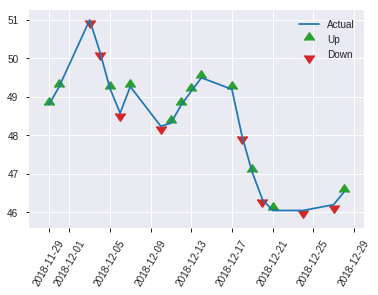


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20889312918955327
RMSE: 0.4570482788388479
LogLoss: 0.6068945914278822
Mean Per-Class Error: 0.2912269548633184
AUC: 0.740495867768595
pr_auc: 0.7247923279909222
Gini: 0.48099173553719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42768266797065735: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   53   0.438    (53.0/121.0)
1      20   110  0.1538   (20.0/130.0)
Total  88   163  0.2908   (73.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427683     0.750853  162
max f2                       0.221471     0.849802  238
max f0point5                 0.439877     0.708661  157
max accuracy                 0.439877     0.713147  157
max precision                0.818228     1         0
max recall                   0.173058     1         248
max specificity              0.818228     1         0
max absolute_mcc             0.439877     0.432015  157
max min_per_class_accuracy   0.495315     0.669421  127
max mean_per_class_accuracy  0.439877     0.708773  157

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 48.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.791152           1.93077   1.93077            1                0.809435  1                           0.809435            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.761862           1.28718   1.60897            0.666667         0.77183   0.833333                    0.790633            0.0153846       0.0384615                  28.7179   60.8974
    3        0.0318725                   0.747058           0.965385  1.44808            0.5              0.752376  0.75                        0.781069            0.00769231      0.0461538                  -3.46154  44.8077
    4        0.0438247                   0.73955            1.28718   1.4042             0.666667         0.741338  0.727273                    0.770233            0.0153846       0.0615385                  28.7179   40.4196
    5        0.0517928                   0.731394           1.93077   1.48521            1                0.737318  0.769231                    0.765169            0.0153846       0.0769231                  93.0769   48.5207
    6        0.103586                    0.694463           1.93077   1.70799            1                0.707982  0.884615                    0.736575            0.1             0.176923                   93.0769   70.7988
    7        0.151394                    0.671171           1.28718   1.5751             0.666667         0.68135   0.815789                    0.719136            0.0615385       0.238462                   28.7179   57.5101
    8        0.203187                    0.649153           1.48521   1.55219            0.769231         0.658553  0.803922                    0.703693            0.0769231       0.315385                   48.5207   55.2187
    9        0.302789                    0.599749           1.23569   1.44808            0.64             0.621663  0.75                        0.67671             0.123077        0.438462                   23.5692   44.8077
    10       0.40239                     0.552              1.08123   1.35727            0.56             0.57606   0.70297                     0.651796            0.107692        0.546154                   8.12308   35.7273
    11       0.501992                    0.498451           1.15846   1.31783            0.6              0.523826  0.68254                     0.626405            0.115385        0.661538                   15.8462   31.7827
    12       0.601594                    0.45256            1.31292   1.31701            0.68             0.46868   0.682119                    0.600292            0.130769        0.792308                   31.2923   31.7015
    13       0.701195                    0.402053           0.695077  1.22867            0.36             0.426236  0.636364                    0.575568            0.0692308       0.861538                   -30.4923  22.8671
    14       0.800797                    0.309996           0.695077  1.1623             0.36             0.358507  0.60199                     0.54857             0.0692308       0.930769                   -30.4923  16.2304
    15       0.900398                    0.246567           0.154462  1.05082            0.08             0.276462  0.544248                    0.51847             0.0153846       0.946154                   -84.5538  5.08169
    16       1                           0.144064           0.540615  1                  0.28             0.215813  0.517928                    0.488325         

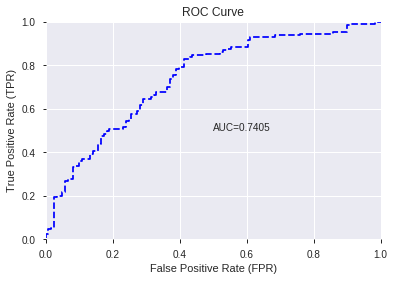

This function is available for GLM models only


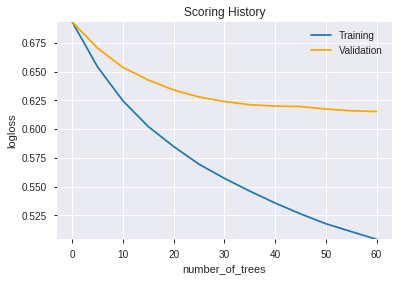

--2019-08-27 18:53:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_185303_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_185303_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'STOCHF_fastk',
 'CCI_8',
 'DIV',
 'ULTOSC',
 'MINUS_DI_8',
 'CCI_12',
 'CMO_24',
 'WILLR_8',
 'TRANGE',
 'ADOSC',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'CCI_30',
 'LINEARREG_INTERCEPT_8',
 'LINEARREG_ANGLE_8',
 'WILLR_12',
 'SAR_0.08',
 'CCI_14',
 'CDLCLOSINGMARUBOZU',
 'MOM_8',
 'CMO_20',
 'STOCHRSI_fastk',
 'SAR_0.24',
 'CCI_20',
 'CMO_8',
 'SAR_0.14',
 'SAR_0.2',
 'WILLR_14',
 'CCI_24',
 'SAR_0.3',
 'SAR_0.12',
 'ROC_8',
 'WILLR_30',
 'WILLR_20',
 'CDLLONGLINE',
 'CMO_12',
 'CMO_14',
 'WILLR_24',
 'CDLBELTHOLD',
 'RSI_14',
 'STOCHF_fastd',
 'RSI_24',
 'RSI_20',
 'CDLDOJI',
 'CDLENGULFING',
 'RSI_8',
 'CDLHANGINGMAN']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

65

['BBANDS_upperband_14_2_5',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_upperband_20_7_2',
 'BBANDS_lowerband_24_6_3',
 'BBANDS_lowerband_30_2_5',
 'BOP',
 'ADXR_8',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'aroonup_12',
 'AROONOSC_12',
 'MACDFIX_signal_12',
 'MACDFIX_hist_12',
 'MFI_12',
 'MOM_12',
 'ROCR_12',
 'RSI_12',
 'ADXR_14',
 'aroondown_14',
 'CCI_14',
 'DX_14',
 'PLUS_DM_14',
 'ROCR_14',
 'ROCR100_14',
 'TRIX_14',
 'WILLR_14',
 'aroondown_20',
 'CCI_20',
 'CMO_20',
 'MINUS_DI_20',
 'ROC_20',
 'ROCR_20',
 'RSI_20',
 'ADX_24',
 'DX_24',
 'MFI_24',
 'ROCR_24',
 'ROCR100_24',
 'WILLR_24',
 'ROCR_30',
 'WILLR_30',
 'MACD_signal',
 'MACD_hist',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'OBV',
 'ATR_8',
 'ATR_20',
 'TRANGE',
 'MEDPRICE',
 'TYPPRICE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'CORREL_8',
 'LINEARREG_8',
 'LINEARREG_ANGLE_8',
 'VAR_8',
 'BETA_12',
 'CORREL_12',
 'LINEARREG_ANGLE_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_185549_model_9  0.727718  0.607516              0.360776  0.458981  0.210663
1  DeepLearning_grid_1_AutoML_20190827_185549_model_8  0.715226  0.621872              0.332263  0.466886  0.217982
2  DeepLearning_grid_1_AutoML_20190827_185549_model_6  0.712905  0.621052              0.374317  0.466528  0.217649
3  DeepLearning_grid_1_AutoML_20190827_185549_model_5  0.708964  0.604859              0.357788  0.459801  0.211417
4  DeepLearning_grid_1_AutoML_20190827_185549_model_7  0.674825  0.668996              0.408233  0.485876  0.236075
5  DeepLearning_grid_1_AutoML_20190827_185549_model_2  0.637381  0.971845              0.448983  0.560463  0.314119
6               DeepLearning_1_AutoML_20190827_185549  0.633757  0.717448              0.434011  0.502274  0.252280
7  DeepLearning_grid_1_AutoML_20190827_185549_model_3  0.631278  1.063335              0.432740  0.574317  0.329840
8  DeepLearning_grid_1_AutoML_20190827_185549_model_4  0.621170  0.875940              0.413350  0.536424  0.287751
9  DeepLearning_grid_1_AutoML_20190827_185549_model_1  0.508709  1.673680              0.487317  0.633901  0.401830

variable  relative_importance  scaled_importance  percentage
0        CDLCLOSINGMARUBOZU             1.000000           1.000000    0.037010
1                    TRANGE             0.922903           0.922903    0.034157
2                       BOP             0.826594           0.826594    0.030592
3               CDLLONGLINE             0.800538           0.800538    0.029628
4                    MFI_12             0.525332           0.525332    0.019443
..                      ...                  ...                ...         ...
60  BBANDS_lowerband_30_2_5             0.349229           0.349229    0.012925
61              LINEARREG_8             0.348623           0.348623    0.012903
62       LINEARREG_ANGLE_12             0.346529           0.346529    0.012825
63        MACDFIX_signal_12             0.343804           0.343804    0.012724
64                 MEDPRICE             0.341565           0.341565    0.012641

[65 rows x 4 columns]

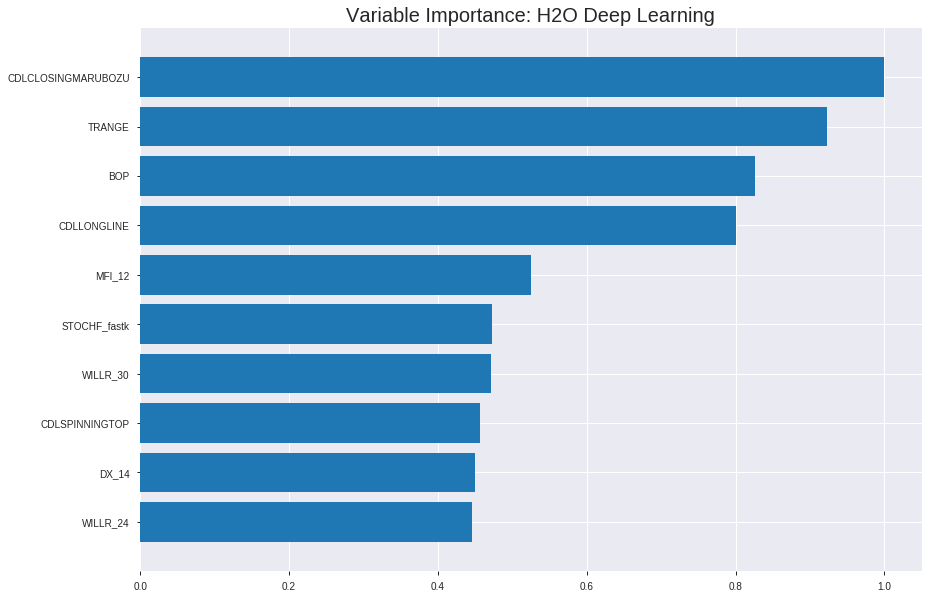

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_185549_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19775811019524006
RMSE: 0.4447000227065882
LogLoss: 0.5793006061638761
Mean Per-Class Error: 0.3076393883486037
AUC: 0.7632319907856197
pr_auc: 0.7571945684763457
Gini: 0.5264639815712393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39778414581441046: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      437  412   0.4853   (412.0/849.0)
1      125  779   0.1383   (125.0/904.0)
Total  562  1191  0.3063   (537.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397784     0.743675  257
max f2                       0.171765     0.854291  361
max f0point5                 0.596016     0.712603  149
max accuracy                 0.414433     0.69652   250
max precision                0.911077     1         0
max recall                   0.105405     1         395
max specificity              0.911077     1         0
max absolute_mcc             0.412185     0.404843  251
max min_per_class_accuracy   0.502604     0.681979  200
max mean_per_class_accuracy  0.471283     0.692361  219

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 49.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.893168           1.83143   1.83143            0.944444         0.900196  0.944444                    0.900196            0.0188053       0.0188053                  83.1428    83.1428
    2        0.0205362                   0.877649           1.7237    1.77756            0.888889         0.883376  0.916667                    0.891786            0.0176991       0.0365044                  72.3697    77.7563
    3        0.0302339                   0.864044           1.71102   1.75622            0.882353         0.870063  0.90566                     0.884818            0.0165929       0.0530973                  71.1023    75.622
    4        0.040502                    0.845756           1.61597   1.72066            0.833333         0.8549    0.887324                    0.877233            0.0165929       0.0696903                  61.5966    72.0662
    5        0.0501997                   0.830421           1.82509   1.74084            0.941176         0.838115  0.897727                    0.869676            0.0176991       0.0873894                  82.5091    74.0836
    6        0.100399                    0.780492           1.56455   1.65269            0.806818         0.803971  0.852273                    0.836824            0.0785398       0.165929                   56.4549    65.2693
    7        0.150029                    0.741736           1.51566   1.60736            0.781609         0.760836  0.828897                    0.811687            0.0752212       0.24115                    51.5665    60.7364
    8        0.200228                    0.705281           1.45437   1.56901            0.75             0.723137  0.809117                    0.789486            0.0730088       0.314159                   45.4369    56.9006
    9        0.300057                    0.628746           1.40728   1.5152             0.725714         0.665561  0.781369                    0.748257            0.140487        0.454646                   40.7276    51.5199
    10       0.399886                    0.565558           1.24106   1.44676            0.64             0.597308  0.746077                    0.710573            0.123894        0.57854                    24.1062    44.6762
    11       0.500285                    0.505221           0.991616  1.35542            0.511364         0.536522  0.698974                    0.675644            0.0995575       0.678097                   -0.838445  35.5421
    12       0.600114                    0.451599           1.00836   1.29769            0.52             0.477408  0.669202                    0.642667            0.100664        0.778761                   0.836283   29.7688
    13       0.699943                    0.375338           0.930796  1.24536            0.48             0.417856  0.642217                    0.610604            0.0929204       0.871681                   -6.92035   24.5361
    14       0.799772                    0.272467           0.653774  1.17152            0.337143         0.327458  0.604137                    0.575261            0.0652655       0.936947                   -34.6226   17.1518
    15       0.899601                    0.177021           0.398913  1.08578            0.205714         0.222188  0.559924                    0.53608             0.039823        0.97677                    -60.1087   8.57816
    16       1                           0.0811759          0.231377  1                  0.119318         0.144712  0.515687                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21193899602482705
RMSE: 0.46036832647873055
LogLoss: 0.6140146153774274
Mean Per-Class Error: 0.3330940759881329
AUC: 0.723059622930424
pr_auc: 0.6925795584459028
Gini: 0.44611924586084806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30938248288606096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   165  0.679    (165.0/243.0)
1      16   242  0.062    (16.0/258.0)
Total  94   407  0.3613   (181.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309382     0.72782   316
max f2                       0.255983     0.848797  332
max f0point5                 0.625891     0.681818  146
max accuracy                 0.474659     0.668663  242
max precision                0.912793     1         0
max recall                   0.110634     1         398
max specificity              0.912793     1         0
max absolute_mcc             0.466396     0.342058  246
max min_per_class_accuracy   0.555074     0.662791  192
max mean_per_class_accuracy  0.560539     0.666906  191

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 53.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.896759           0.97093   0.97093            0.5              0.904035  0.5                         0.904035            0.0116279       0.0116279                  -2.90698  -2.90698
    2        0.0219561                   0.890018           1.94186   1.41226            1                0.892712  0.727273                    0.898888            0.0193798       0.0310078                  94.186    41.2262
    3        0.0319361                   0.877652           1.16512   1.33503            0.6              0.882805  0.6875                      0.893862            0.0116279       0.0426357                  16.5116   33.5029
    4        0.0419162                   0.863389           1.94186   1.47951            1                0.868759  0.761905                    0.887885            0.0193798       0.0620155                  94.186    47.9513
    5        0.0518962                   0.84682            1.55349   1.49374            0.8              0.852019  0.769231                    0.880988            0.0155039       0.0775194                  55.3488   49.3739
    6        0.101796                    0.807581           1.55349   1.52303            0.8              0.823675  0.784314                    0.852893            0.0775194       0.155039                   55.3488   52.3028
    7        0.151697                    0.770909           1.55349   1.53305            0.8              0.785933  0.789474                    0.830867            0.0775194       0.232558                   55.3488   53.3048
    8        0.201597                    0.732214           1.24279   1.4612             0.64             0.748402  0.752475                    0.810455            0.0620155       0.294574                   24.2791   46.1202
    9        0.301397                    0.682748           1.47581   1.46604            0.76             0.706724  0.754967                    0.776107            0.147287        0.44186                    47.5814   46.604
    10       0.401198                    0.609234           1.12628   1.38152            0.58             0.645551  0.711443                    0.74363             0.112403        0.554264                   12.6279   38.1523
    11       0.500998                    0.555054           1.08744   1.32294            0.56             0.581858  0.681275                    0.711405            0.108527        0.662791                   8.74419   32.2941
    12       0.600798                    0.488346           0.932093  1.25802            0.48             0.522385  0.647841                    0.680006            0.0930233       0.755814                   -6.7907   25.8016
    13       0.700599                    0.438378           0.893256  1.20606            0.46             0.458804  0.621083                    0.648496            0.0891473       0.844961                   -10.6744  20.6056
    14       0.800399                    0.328563           0.776744  1.15253            0.4              0.382166  0.593516                    0.615288            0.0775194       0.922481                   -22.3256  15.2526
    15       0.9002                      0.177423           0.504884  1.08073            0.26             0.250127  0.556541                    0.574804            0.0503876       0.972868                   -49.5116  8.0725
    16       1                           0.106994           0.27186   1                  0.14             0.144046  0.51497                     0.531814          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:03:24  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:03:26  2 min 36.880 sec  460 obs/sec       0.515117  1             903        0.63118          1.5254              -0.595125      0.664693        0.662024           1.7237           0.422704                         0.672879           1.87731               -0.81269         0.654289          0.651285             1.94186            0.401198
    2019-08-27 19:03:38  2 min 48.269 sec  755 obs/sec       5.27268   10            9243       0.456327         0.602839            0.166243       0.732743        0.729113           1.83143          0.361666                         0.471866           0.637741              0.10857          0.694859          0.681574             1.29457            0.401198
    2019-08-27 19:03:50  3 min  0.077 sec  888 obs/sec       11.6184   22            20367      0.457079         0.605197            0.163493       0.755463        0.752242           1.83143          0.318311                         0.467499           0.626893              0.124994         0.716432          0.684044             0.97093            0.343313
    2019-08-27 19:04:01  3 min 11.496 sec  976 obs/sec       18.518    35            32462      0.4447           0.579301            0.208188       0.763232        0.757195           1.83143          0.306332                         0.460368           0.614015              0.151483         0.72306           0.69258              0.97093            0.361277
    2019-08-27 19:04:12  3 min 22.646 sec  1004 obs/sec      24.8152   47            43501      0.44766          0.586476            0.197611       0.765112        0.75921            1.83143          0.307473                         0.464604           0.621689              0.135798         0.71573           0.691534             0.97093            0.365269
    2019-08-27 19:04:24  3 min 34.348 sec  1068 obs/sec      32.8169   62            57528      0.439769         0.569634            0.225649       0.774887        0.766981           1.83143          0.290359                         0.462401           0.618191              0.143973         0.720348          0.694005             0.97093            0.371257
    2019-08-27 19:04:36  3 min 46.087 sec  1122 obs/sec      41.2812   78            72366      0.440062         0.570354            0.224618       0.773719        0.767354           1.93916          0.309755                         0.470552           0.638871              0.11353          0.708736          0.685486             0.97093            0.38523
    2019-08-27 19:04:37  3 min 47.302 sec  1122 obs/sec      41.2812   78            72366      0.4447           0.579301            0.208188       0.763232        0.757195           1.83143          0.306332                         0.460368           0.614015              0.151483         0.72306           0.69258              0.97093            0.361277

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU       1.0                    1.0                  0.03701007747919267
TRANGE                   0.9229030609130859     0.9229030609130859   0.03415671379017738
BOP                      0.8265936970710754     0.8265936970710754   0.030592296772412816
CDLLONGLINE              0.8005379438400269     0.8005379438400269   0.029627971326552982
MFI_12                   0.5253324508666992     0.5253324508666992   0.019442594708910715
---                      ---                    ---                  ---
BBANDS_lowerband_30_2_5  0.34922856092453003    0.34922856092453003  0.012924976097763814
LINEARREG_8              0.34862279891967773    0.34862279891967773  0.012902556799030278
LINEARREG_ANGLE_12       0.3465290665626526     0.3465290665626526   0.012825067602276086
MACDFIX_signal_12        0.3438037633895874     0.3438037633895874   0.012724203920686654
MEDPRICE                 0.34156495332717896    0.34156495332717896  0.01264134538681572


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.7317073170731707)

('auc', 0.7277177368086459)

('logloss', 0.6075155984521344)

('mean_per_class_error', 0.32171010807374445)

('rmse', 0.4589806171023395)

('mse', 0.2106632068756444)

deeplearning prediction progress: |███████████████████████████████████████| 100%


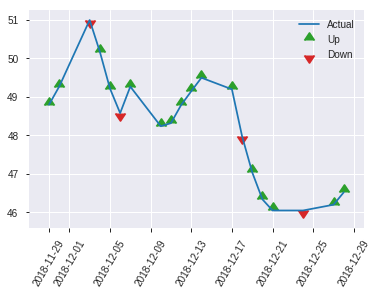


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2106632068756444
RMSE: 0.4589806171023395
LogLoss: 0.6075155984521344
Mean Per-Class Error: 0.32171010807374445
AUC: 0.7277177368086459
pr_auc: 0.7158973881640539
Gini: 0.45543547361729186
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33717123510371616: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   78   0.6446   (78.0/121.0)
1      10   120  0.0769   (10.0/130.0)
Total  53   198  0.3506   (88.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337171     0.731707  197
max f2                       0.201838     0.860215  223
max f0point5                 0.49486      0.689655  126
max accuracy                 0.460638     0.681275  147
max precision                0.899095     1         0
max recall                   0.136469     1         240
max specificity              0.899095     1         0
max absolute_mcc             0.449908     0.364149  153
max min_per_class_accuracy   0.49486      0.676923  126
max mean_per_class_accuracy  0.460638     0.67829   147

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.888751           1.93077   1.93077            1                0.895993  1                           0.895993            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.847778           1.28718   1.60897            0.666667         0.869907  0.833333                    0.88295             0.0153846       0.0384615                  28.7179   60.8974
    3        0.0318725                   0.842972           1.93077   1.68942            1                0.843361  0.875                       0.873053            0.0153846       0.0538462                  93.0769   68.9423
    4        0.0438247                   0.825358           1.93077   1.75524            1                0.832821  0.909091                    0.862081            0.0230769       0.0769231                  93.0769   75.5245
    5        0.0517928                   0.819271           0.965385  1.63373            0.5              0.821771  0.846154                    0.855879            0.00769231      0.0846154                  -3.46154  63.3728
    6        0.103586                    0.762459           1.63373   1.63373            0.846154         0.790398  0.846154                    0.823138            0.0846154       0.169231                   63.3728   63.3728
    7        0.151394                    0.704395           1.12628   1.47348            0.583333         0.724591  0.763158                    0.792018            0.0538462       0.223077                   12.6282   47.3482
    8        0.203187                    0.640586           1.63373   1.51433            0.846154         0.67195   0.784314                    0.761413            0.0846154       0.307692                   63.3728   51.4329
    9        0.302789                    0.589189           1.15846   1.39727            0.6              0.610011  0.723684                    0.711609            0.115385        0.423077                   15.8462   39.7267
    10       0.40239                     0.542147           1.31292   1.37639            0.68             0.563854  0.712871                    0.675036            0.130769        0.553846                   31.2923   37.639
    11       0.501992                    0.497287           1.15846   1.33315            0.6              0.520959  0.690476                    0.644466            0.115385        0.669231                   15.8462   33.315
    12       0.601594                    0.452604           1.004     1.27866            0.52             0.472461  0.662252                    0.615988            0.1             0.769231                   0.4       27.8655
    13       0.701195                    0.404755           0.772308  1.20673            0.4              0.429072  0.625                       0.589437            0.0769231       0.846154                   -22.7692  20.6731
    14       0.800797                    0.332206           0.772308  1.1527             0.4              0.368022  0.597015                    0.561898            0.0769231       0.923077                   -22.7692  15.2698
    15       0.900398                    0.197542           0.617846  1.09353            0.32             0.271531  0.566372                    0.529778            0.0615385       0.984615                   -38.2154  9.3533
    16       1                           0.11138            0.154462  1                  0.08             0.143008  0.517928                    0.491255            

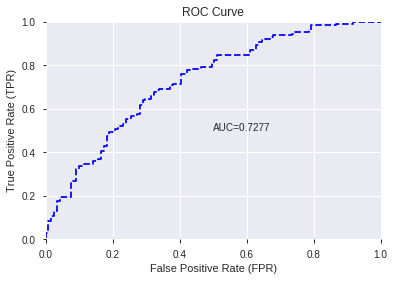

This function is available for GLM models only


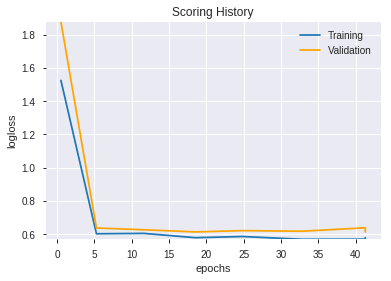

--2019-08-27 19:04:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_185549_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_185549_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'TRANGE',
 'BOP',
 'CDLLONGLINE',
 'MFI_12',
 'STOCHF_fastk',
 'WILLR_30',
 'CDLSPINNINGTOP',
 'DX_14',
 'WILLR_24',
 'AROONOSC_12',
 'CCI_14',
 'ADX_24',
 'CORREL_8',
 'CCI_8',
 'aroondown_14',
 'CORREL_12',
 'ADXR_14',
 'ATR_20',
 'aroonup_12',
 'BBANDS_upperband_14_2_5',
 'BETA_12',
 'WILLR_14',
 'DX_24',
 'BETA_8',
 'OBV',
 'BBANDS_upperband_20_7_2',
 'STOCHRSI_fastk',
 'VAR_8',
 'ROC_20',
 'aroondown_20',
 'ADXR_8',
 'STOCH_slowk',
 'PLUS_DM_14',
 'CMO_20',
 'MFI_24',
 'MACDFIX_hist_12',
 'CCI_20',
 'BBANDS_lowerband_20_6_5',
 'MINUS_DI_8',
 'TRIX_14',
 'ATR_8',
 'LINEARREG_ANGLE_8',
 'ROCR100_24',
 'ROCR_20',
 'TYPPRICE',
 'MINUS_DI_20',
 'BBANDS_lowerband_14_4_4',
 'MOM_12',
 'MACD_signal',
 'ROCR100_14',
 'ROCR_30',
 'BBANDS_lowerband_24_6_3',
 'RSI_20',
 'ROCR_12',
 'MACD_hist',
 'ROCR_14',
 'ROCR_24',
 'CMO_8',
 'RSI_12',
 'BBANDS_lowerband_30_2_5',
 'LINEARREG_8',
 'LINEARREG_ANGLE_12',
 'MACDFIX_signal_12',
 'MEDPRICE']

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_190450_model_1  0.734011  0.604252              0.343675  0.457618  0.209414

variable  relative_importance  scaled_importance  percentage
0                    TRANGE             0.360401           1.000000    0.077956
1                       BOP             0.351075           0.974122    0.075938
2        CDLCLOSINGMARUBOZU             0.230621           0.639900    0.049884
3                    MFI_12             0.193363           0.536523    0.041825
4                  WILLR_30             0.176867           0.490750    0.038257
..                      ...                  ...                ...         ...
60  BBANDS_upperband_20_7_2             0.004265           0.011833    0.000922
61                    CMO_8             0.004215           0.011696    0.000912
62              MINUS_DI_20             0.002748           0.007626    0.000594
63               MINUS_DI_8             0.002380           0.006604    0.000515
64                    ATR_8             0.001818           0.005043    0.000393

[65 rows x 4 columns]

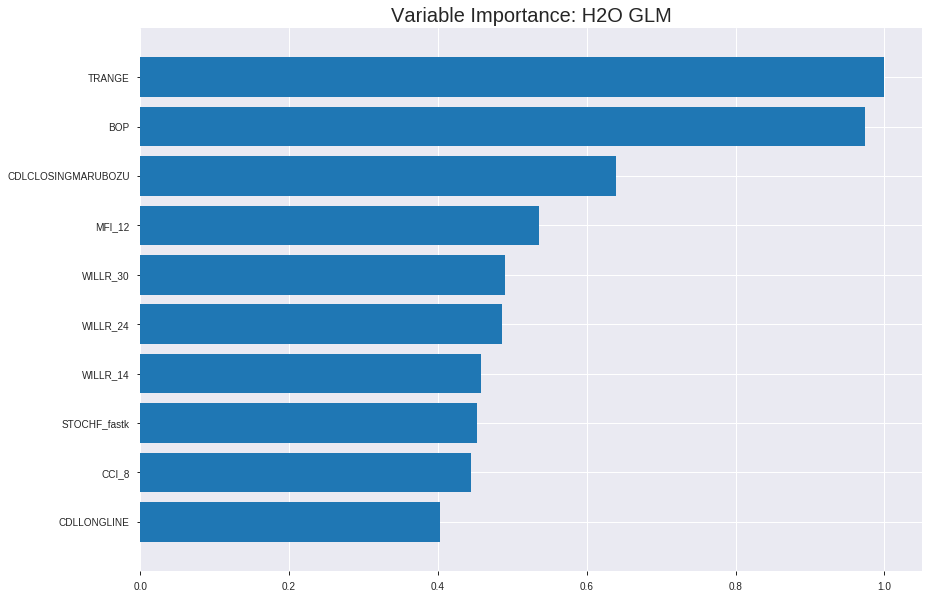

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_190450_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20074703032880023
RMSE: 0.44804802234671254
LogLoss: 0.5865307028588918
Null degrees of freedom: 1752
Residual degrees of freedom: 1687
Null deviance: 2428.4481185881305
Residual deviance: 2056.3766442232745
AIC: 2188.3766442232745
AUC: 0.757271047666698
pr_auc: 0.7498308190125768
Gini: 0.5145420953333959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4310816965892637: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      434  415   0.4888   (415.0/849.0)
1      124  780   0.1372   (124.0/904.0)
Total  558  1195  0.3075   (539.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431082     0.743211  245
max f2                       0.275722     0.849571  318
max f0point5                 0.573526     0.703934  162
max accuracy                 0.436453     0.693098  242
max precision                0.930354     1         0
max recall                   0.0718881    1         390
max specificity              0.930354     1         0
max absolute_mcc             0.431082     0.401267  245
max min_per_class_accuracy   0.5297       0.680801  188
max mean_per_class_accuracy  0.436453     0.687886  242

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.884507           1.83143   1.83143            0.944444         0.905116  0.944444                    0.905116            0.0188053       0.0188053                  83.1428   83.1428
    2        0.0205362                   0.868387           1.7237    1.77756            0.888889         0.876113  0.916667                    0.890615            0.0176991       0.0365044                  72.3697   77.7563
    3        0.0302339                   0.847334           1.71102   1.75622            0.882353         0.859987  0.90566                     0.880791            0.0165929       0.0530973                  71.1023   75.622
    4        0.040502                    0.83149            1.4005    1.66604            0.722222         0.838221  0.859155                    0.869999            0.0143805       0.0674779                  40.0504   66.6038
    5        0.0501997                   0.820177           1.82509   1.69676            0.941176         0.825445  0.875                       0.861392            0.0176991       0.085177                   82.5091   69.6764
    6        0.100399                    0.759876           1.54251   1.61964            0.795455         0.788722  0.835227                    0.825057            0.0774336       0.162611                   54.2513   61.9639
    7        0.150029                    0.71523            1.56024   1.59999            0.804598         0.735402  0.825095                    0.795399            0.0774336       0.240044                   56.0243   59.9991
    8        0.200228                    0.686325           1.47641   1.56901            0.761364         0.700845  0.809117                    0.771693            0.074115        0.314159                   47.6405   56.9006
    9        0.300057                    0.635629           1.40728   1.5152             0.725714         0.661794  0.781369                    0.73513             0.140487        0.454646                   40.7276   51.5199
    10       0.399886                    0.583918           1.20782   1.43846            0.622857         0.609647  0.741797                    0.703804            0.120575        0.575221                   20.7819   43.8463
    11       0.500285                    0.532356           1.01365   1.35321            0.522727         0.558037  0.697834                    0.674551            0.10177         0.676991                   1.36514   35.321
    12       0.600114                    0.481064           1.00836   1.29585            0.52             0.506943  0.668251                    0.646669            0.100664        0.777655                   0.836283  29.5845
    13       0.699943                    0.421929           0.908635  1.24062            0.468571         0.451282  0.639772                    0.618802            0.090708        0.868363                   -9.13654  24.0619
    14       0.799772                    0.342506           0.664855  1.16875            0.342857         0.382882  0.60271                     0.589354            0.0663717       0.934735                   -33.5145  16.8751
    15       0.899601                    0.233972           0.387832  1.08209            0.2              0.291888  0.558022                    0.556345            0.0387168       0.973451                   -61.2168  8.20927
    16       1                           0.0150117          0.264431  1                  0.136364         0.151391  0.515687                    0.515687           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2120969045426836
RMSE: 0.4605397969151891
LogLoss: 0.6148222720816965
Null degrees of freedom: 500
Residual degrees of freedom: 435
Null deviance: 694.0853381814004
Residual deviance: 616.0519166258599
AIC: 748.0519166258599
AUC: 0.7256436022585894
pr_auc: 0.6929274641790848
Gini: 0.45128720451717874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3930380180441937: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   151  0.6214   (151.0/243.0)
1      23   235  0.0891   (23.0/258.0)
Total  115  386  0.3473   (174.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393038     0.729814  298
max f2                       0.288467     0.848033  347
max f0point5                 0.59451      0.690128  165
max accuracy                 0.559211     0.674651  192
max precision                0.917583     1         0
max recall                   0.0686197    1         397
max specificity              0.917583     1         0
max absolute_mcc             0.59451      0.351287  165
max min_per_class_accuracy   0.552999     0.670543  195
max mean_per_class_accuracy  0.559211     0.675017  192

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 53.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.891335           0.97093   0.97093            0.5              0.900246  0.5                         0.900246            0.0116279       0.0116279                  -2.90698  -2.90698
    2        0.0219561                   0.870658           1.55349   1.23573            0.8              0.878837  0.636364                    0.890514            0.0155039       0.0271318                  55.3488   23.5729
    3        0.0319361                   0.84245            1.16512   1.21366            0.6              0.852511  0.625                       0.878638            0.0116279       0.0387597                  16.5116   21.3663
    4        0.0419162                   0.833696           1.94186   1.38704            1                0.837327  0.714286                    0.868802            0.0193798       0.0581395                  94.186    38.7043
    5        0.0518962                   0.822324           1.94186   1.49374            1                0.826832  0.769231                    0.860731            0.0193798       0.0775194                  94.186    49.3739
    6        0.101796                    0.764036           1.70884   1.59918            0.88             0.788414  0.823529                    0.825282            0.0852713       0.162791                   70.8837   59.9179
    7        0.151697                    0.721304           1.32047   1.5075             0.68             0.73989   0.776316                    0.797192            0.0658915       0.228682                   32.0465   50.7497
    8        0.201597                    0.69296            1.16512   1.42275            0.6              0.706131  0.732673                    0.774652            0.0581395       0.286822                   16.5116   42.2749
    9        0.301397                    0.648589           1.39814   1.4146             0.72             0.671508  0.728477                    0.740499            0.139535        0.426357                   39.814    41.46
    10       0.401198                    0.60059            1.3593    1.40084            0.7              0.625284  0.721393                    0.711838            0.135659        0.562016                   35.9302   40.0845
    11       0.500998                    0.552993           1.08744   1.33841            0.56             0.578558  0.689243                    0.685288            0.108527        0.670543                   8.74419   33.8414
    12       0.600798                    0.50202            0.815581  1.25156            0.42             0.526779  0.644518                    0.658958            0.0813953       0.751938                   -18.4419  25.1565
    13       0.700599                    0.447531           0.854419  1.19499            0.44             0.474685  0.615385                    0.632708            0.0852713       0.837209                   -14.5581  19.4991
    14       0.800399                    0.373368           0.893256  1.15737            0.46             0.410067  0.59601                     0.604948            0.0891473       0.926357                   -10.6744  15.7368
    15       0.9002                      0.278574           0.427209  1.07642            0.22             0.319308  0.554324                    0.57328             0.0426357       0.968992                   -57.2791  7.64193
    16       1                           0.0423786          0.310698  1                  0.16             0.182654  0.51497                     0.534296          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 19:04:50  0.000 sec   2            17        66            1.36688           1.373
    2019-08-27 19:04:50  0.018 sec   4            11        66            1.35835           1.36711
    2019-08-27 19:04:50  0.034 sec   6            6.7       66            1.34705           1.35913
    2019-08-27 19:04:50  0.050 sec   8            4.1       66            1.33269           1.34876
    2019-08-27 19:04:50  0.068 sec   10           2.6       66            1.31539           1.33591
    2019-08-27 19:04:50  0.094 sec   12           1.6       66            1.2958            1.32093
    2019-08-27 19:04:50  0.111 sec   14           0.99      66            1.27513           1.30463
    2019-08-27 19:04:50  0.130 sec   16           0.62      66            1.25475           1.28812
    2019-08-27 19:04:50  0.146 sec   18           0.38      66            1.23579           1.27242
    2019-08-27 19:04:50  0.169 sec   20           0.24      66            1.21881           1.25846
    2019-08-27 19:04:50  0.185 sec   22           0.15      66            1.20401           1.24684
    2019-08-27 19:04:50  0.201 sec   24           0.092     66            1.19144           1.23799
    2019-08-27 19:04:50  0.218 sec   26           0.057     66            1.18114           1.23226
    2019-08-27 19:04:50  0.234 sec   28           0.035     66            1.17306           1.22964
    2019-08-27 19:04:50  0.250 sec   30           0.022     66            1.16704           1.22972
    2019-08-27 19:04:50  0.268 sec   32           0.014     66            1.16259           1.23184
    2019-08-27 19:04:50  0.285 sec   34           0.0085    66            1.15918           1.2352
    2019-08-27 19:04:50  0.304 sec   36           0.0053    66            1.15652           1.23833
    2019-08-27 19:04:50  0.321 sec   38           0.0033    66            1.15421           1.24127

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7375)

('auc', 0.7340114431023522)

('logloss', 0.6042522117978979)

('mean_per_class_error', 0.315162110616656)

('rmse', 0.4576181107852758)

('mse', 0.20941433531868495)

glm prediction progress: |████████████████████████████████████████████████| 100%


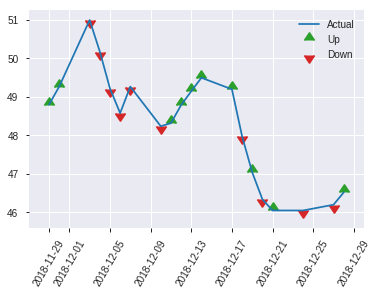


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20941433531868495
RMSE: 0.4576181107852758
LogLoss: 0.6042522117978979
Null degrees of freedom: 250
Residual degrees of freedom: 185
Null deviance: 347.642153441148
Residual deviance: 303.33461032254473
AIC: 435.33461032254473
AUC: 0.7340114431023522
pr_auc: 0.714253245090758
Gini: 0.46802288620470445
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3449724674124801: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   72   0.595    (72.0/121.0)
1      12   118  0.0923   (12.0/130.0)
Total  61   190  0.3347   (84.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344972     0.7375    189
max f2                       0.219751     0.85695   220
max f0point5                 0.505446     0.689369  117
max accuracy                 0.418903     0.689243  157
max precision                0.897656     1         0
max recall                   0.124871     1         238
max specificity              0.897656     1         0
max absolute_mcc             0.417171     0.383647  159
max min_per_class_accuracy   0.489917     0.652893  126
max mean_per_class_accuracy  0.418903     0.684838  157

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 47.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.879652           1.93077   1.93077            1                0.892523  1                           0.892523            0.0230769       0.0230769                  93.0769   93.0769
    2        0.0239044                   0.846655           1.28718   1.60897            0.666667         0.857535  0.833333                    0.875029            0.0153846       0.0384615                  28.7179   60.8974
    3        0.0318725                   0.818667           0.965385  1.44808            0.5              0.825911  0.75                        0.86275             0.00769231      0.0461538                  -3.46154  44.8077
    4        0.0438247                   0.802513           1.93077   1.57972            1                0.806822  0.818182                    0.847497            0.0230769       0.0692308                  93.0769   57.972
    5        0.0517928                   0.77905            0.965385  1.48521            0.5              0.785482  0.769231                    0.837956            0.00769231      0.0769231                  -3.46154  48.5207
    6        0.103586                    0.73227            1.63373   1.55947            0.846154         0.75287   0.807692                    0.795413            0.0846154       0.161538                   63.3728   55.9467
    7        0.151394                    0.67834            1.28718   1.47348            0.666667         0.69128   0.763158                    0.762529            0.0615385       0.223077                   28.7179   47.3482
    8        0.203187                    0.643674           1.48521   1.47647            0.769231         0.661187  0.764706                    0.736697            0.0769231       0.3                        48.5207   47.6471
    9        0.302789                    0.575803           1.31292   1.42267            0.68             0.606993  0.736842                    0.694031            0.130769        0.430769                   31.2923   42.2672
    10       0.40239                     0.53981            1.31292   1.39551            0.68             0.559606  0.722772                    0.660757            0.130769        0.561538                   31.2923   39.5506
    11       0.501992                    0.48996            0.849538  1.28718            0.44             0.514527  0.666667                    0.631743            0.0846154       0.646154                   -15.0462  28.7179
    12       0.601594                    0.429516           1.23569   1.27866            0.64             0.460598  0.662252                    0.603408            0.123077        0.769231                   23.5692   27.8655
    13       0.701195                    0.383483           0.926769  1.22867            0.48             0.407697  0.636364                    0.575608            0.0923077       0.861538                   -7.32308  22.8671
    14       0.800797                    0.294201           0.617846  1.1527             0.32             0.341807  0.597015                    0.546528            0.0615385       0.923077                   -38.2154  15.2698
    15       0.900398                    0.195093           0.540615  1.08499            0.28             0.254653  0.561947                    0.514241            0.0538462       0.976923                   -45.9385  8.49898
    16       1                           0.0491125          0.231692  1                  0.12             0.113261  0.517928                    0.474303          

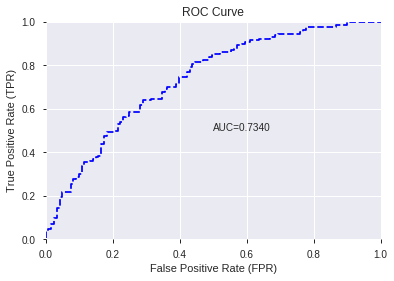

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


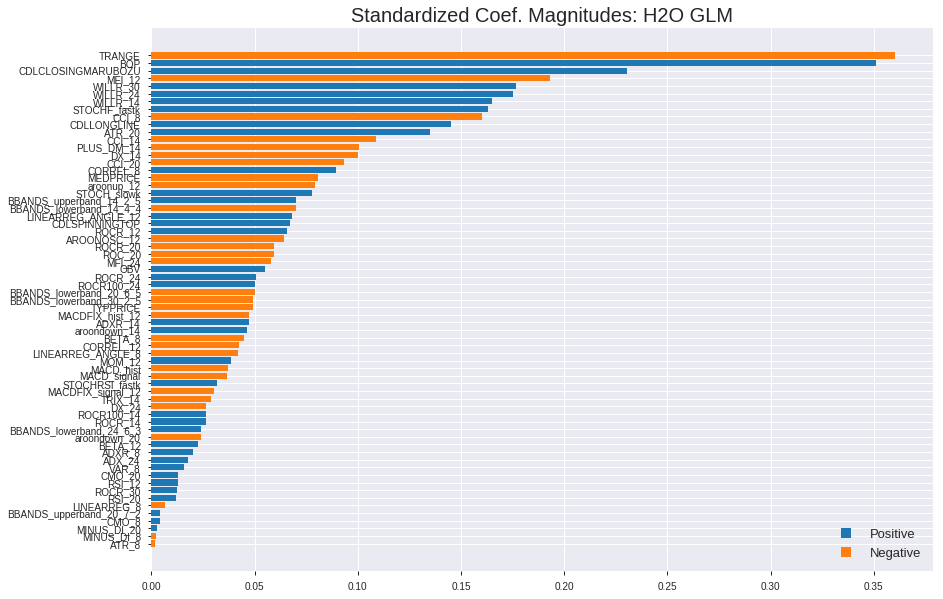

'log_likelihood'
--2019-08-27 19:04:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_190450_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_190450_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['TRANGE',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'MFI_12',
 'WILLR_30',
 'WILLR_24',
 'WILLR_14',
 'STOCHF_fastk',
 'CCI_8',
 'CDLLONGLINE',
 'ATR_20',
 'CCI_14',
 'PLUS_DM_14',
 'DX_14',
 'CCI_20',
 'CORREL_8',
 'MEDPRICE',
 'aroonup_12',
 'STOCH_slowk',
 'BBANDS_upperband_14_2_5',
 'BBANDS_lowerband_14_4_4',
 'LINEARREG_ANGLE_12',
 'CDLSPINNINGTOP',
 'ROCR_12',
 'AROONOSC_12',
 'ROCR_20',
 'ROC_20',
 'MFI_24',
 'OBV',
 'ROCR_24',
 'ROCR100_24',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_lowerband_30_2_5',
 'TYPPRICE',
 'MACDFIX_hist_12',
 'ADXR_14',
 'aroondown_14',
 'BETA_8',
 'CORREL_12',
 'LINEARREG_ANGLE_8',
 'MOM_12',
 'MACD_hist',
 'MACD_signal',
 'STOCHRSI_fastk',
 'MACDFIX_signal_12',
 'TRIX_14',
 'DX_24',
 'ROCR100_14',
 'ROCR_14',
 'BBANDS_lowerband_24_6_3',
 'aroondown_20',
 'BETA_12',
 'ADXR_8',
 'ADX_24',
 'VAR_8',
 'CMO_20',
 'RSI_12',
 'ROCR_30',
 'RSI_20',
 'LINEARREG_8',
 'BBANDS_upperband_20_7_2',
 'CMO_8',
 'MINUS_DI_20',
 'MINUS_DI_8',
 'ATR_8']

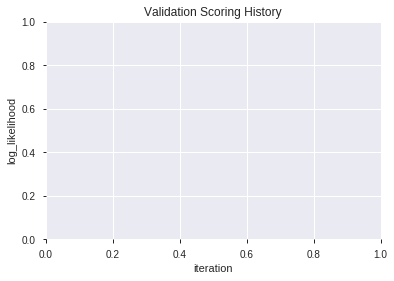

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_190501_model_6  0.722123  0.621387              0.339256  0.465306  0.216510
1               XGBoost_3_AutoML_20190827_190501  0.721488  0.612632              0.374317  0.462179  0.213609
2  XGBoost_grid_1_AutoML_20190827_190501_model_7  0.716910  0.623300              0.383725  0.467475  0.218533
3  XGBoost_grid_1_AutoML_20190827_190501_model_2  0.715957  0.621209              0.333694  0.465224  0.216434
4  XGBoost_grid_1_AutoML_20190827_190501_model_4  0.714177  0.616318              0.308614  0.463114  0.214475
5               XGBoost_1_AutoML_20190827_190501  0.713414  0.621706              0.316879  0.465982  0.217140
6  XGBoost_grid_1_AutoML_20190827_190501_model_1  0.710998  0.620363              0.332835  0.465853  0.217019
7               XGBoost_2_AutoML_20190827_190501  0.707311  0.620030              0.365194  0.465332  0.216534
8  XGBoost_grid_1_AutoML_20190827_190501_model_3  0.701208  0.635637              0.364908  0.472272  0.223041
9  XGBoost_grid_1_AutoML_20190827_190501_model_5  0.696376  0.646510              0.317451  0.477738  0.228233

variable  relative_importance  scaled_importance  percentage
0              BOP          1514.014282           1.000000    0.166427
1           TRANGE           692.373535           0.457310    0.076109
2     STOCHF_fastk           529.846802           0.349962    0.058243
3            CCI_8           316.228058           0.208867    0.034761
4           BETA_8           247.175705           0.163259    0.027171
..             ...                  ...                ...         ...
60    aroondown_14            32.125076           0.021218    0.003531
61         ROCR_20            24.073696           0.015901    0.002646
62  CDLSPINNINGTOP            23.884342           0.015776    0.002625
63      ROCR100_24            13.229846           0.008738    0.001454
64          RSI_20             8.764650           0.005789    0.000963

[65 rows x 4 columns]

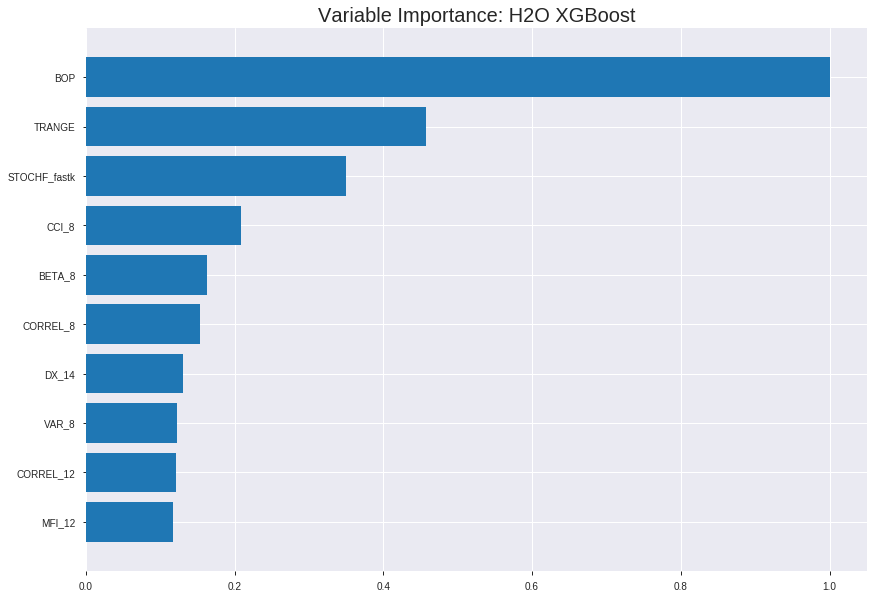

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_190501_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14745245223516196
RMSE: 0.3839953804867475
LogLoss: 0.4677583918844426
Mean Per-Class Error: 0.17004518590324902
AUC: 0.9119780428823081
pr_auc: 0.9234200293649785
Gini: 0.8239560857646162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.515823483467102: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      658  191  0.225    (191.0/849.0)
1      128  776  0.1416   (128.0/904.0)
Total  786  967  0.182    (319.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.515823     0.829503  200
max f2                       0.337134     0.88936   286
max f0point5                 0.618233     0.866591  139
max accuracy                 0.582835     0.827724  162
max precision                0.897638     1         0
max recall                   0.174722     1         362
max specificity              0.897638     1         0
max absolute_mcc             0.585662     0.664838  160
max min_per_class_accuracy   0.543689     0.816254  184
max mean_per_class_accuracy  0.582835     0.829955  162

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.867835           1.93916   1.93916            1                0.882351  1                           0.882351            0.0199115       0.0199115                  93.9159   93.9159
    2        0.0205362                   0.850591           1.93916   1.93916            1                0.857452  1                           0.869902            0.0199115       0.039823                   93.9159   93.9159
    3        0.0302339                   0.833118           1.93916   1.93916            1                0.841153  1                           0.86068             0.0188053       0.0586283                  93.9159   93.9159
    4        0.040502                    0.821823           1.93916   1.93916            1                0.827779  1                           0.852339            0.0199115       0.0785398                  93.9159   93.9159
    5        0.0501997                   0.814948           1.93916   1.93916            1                0.818328  1                           0.845769            0.0188053       0.0973451                  93.9159   93.9159
    6        0.100399                    0.771466           1.91712   1.92814            0.988636         0.791655  0.994318                    0.818712            0.0962389       0.193584                   91.7123   92.8141
    7        0.150029                    0.740412           1.93916   1.93179            1                0.75745   0.996198                    0.798447            0.0962389       0.289823                   93.9159   93.1786
    8        0.200228                    0.709068           1.89509   1.92259            0.977273         0.72608   0.991453                    0.780303            0.0951327       0.384956                   89.5087   92.2585
    9        0.300057                    0.656487           1.77295   1.8728             0.914286         0.683537  0.965779                    0.748109            0.176991        0.561947                   77.2946   87.28
    10       0.399886                    0.602625           1.4516    1.76765            0.748571         0.629033  0.911555                    0.718383            0.144912        0.706858                   45.1599   76.765
    11       0.500285                    0.546764           1.02467   1.61855            0.528409         0.575673  0.834664                    0.689743            0.102876        0.809735                   2.46694   61.8546
    12       0.600114                    0.485012           0.819987  1.48571            0.422857         0.515556  0.76616                     0.660767            0.0818584       0.891593                   -18.0013  48.5706
    13       0.699943                    0.394821           0.542965  1.35125            0.28             0.439044  0.696822                    0.629144            0.0542035       0.945796                   -45.7035  35.1248
    14       0.799772                    0.302797           0.387832  1.23099            0.2              0.348673  0.634807                    0.594135            0.0387168       0.984513                   -61.2168  23.0993
    15       0.899601                    0.2019             0.144052  1.11037            0.0742857        0.250307  0.572606                    0.55598             0.0143805       0.998894                   -85.5948  11.0375
    16       1                           0.0759953          0.011018  1                  0.00568182       0.152866  0.515687                    0.515508            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21527358829237336
RMSE: 0.4639758488244548
LogLoss: 0.6197983219706708
Mean Per-Class Error: 0.3320652694037707
AUC: 0.7138242894056848
pr_auc: 0.6960795495341489
Gini: 0.42764857881136953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4265817105770111: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  120  0.4938   (120.0/243.0)
1      44   214  0.1705   (44.0/258.0)
Total  167  334  0.3273   (164.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426582     0.722973  253
max f2                       0.213739     0.848363  368
max f0point5                 0.43139      0.671501  251
max accuracy                 0.43139      0.672655  251
max precision                0.743351     0.857143  34
max recall                   0.107268     1         395
max specificity              0.845928     0.995885  0
max absolute_mcc             0.426582     0.35583   253
max min_per_class_accuracy   0.517173     0.647287  189
max mean_per_class_accuracy  0.43139      0.667935  251

Gains/Lift Table: Avg response rate: 51.50 %, avg score: 49.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.828317           1.29457   1.29457            0.666667         0.835044  0.666667                    0.835044            0.0155039       0.0155039                  29.4574   29.4574
    2        0.0219561                   0.817071           1.55349   1.41226            0.8              0.821233  0.727273                    0.828766            0.0155039       0.0310078                  55.3488   41.2262
    3        0.0319361                   0.796978           1.55349   1.4564             0.8              0.805856  0.75                        0.821607            0.0155039       0.0465116                  55.3488   45.6395
    4        0.0419162                   0.784148           1.94186   1.57198            1                0.789449  0.809524                    0.81395             0.0193798       0.0658915                  94.186    57.1982
    5        0.0518962                   0.776012           1.55349   1.56843            0.8              0.778536  0.807692                    0.80714             0.0155039       0.0813953                  55.3488   56.8426
    6        0.101796                    0.718071           1.55349   1.5611             0.8              0.746023  0.803922                    0.777181            0.0775194       0.158915                   55.3488   56.1104
    7        0.151697                    0.676402           1.55349   1.5586             0.8              0.696857  0.802632                    0.750758            0.0775194       0.236434                   55.3488   55.8599
    8        0.201597                    0.654989           1.32047   1.49965            0.68             0.664841  0.772277                    0.729492            0.0658915       0.302326                   32.0465   49.9655
    9        0.301397                    0.610805           1.32047   1.44032            0.68             0.633024  0.741722                    0.697549            0.131783        0.434109                   32.0465   44.032
    10       0.401198                    0.57484            0.97093   1.32356            0.5              0.595498  0.681592                    0.672163            0.0968992       0.531008                   -2.90698  32.3557
    11       0.500998                    0.517417           1.12628   1.28426            0.58             0.549672  0.661355                    0.647762            0.112403        0.643411                   12.6279   28.4258
    12       0.600798                    0.470948           1.0486    1.24511            0.54             0.49253   0.641196                    0.621976            0.104651        0.748062                   4.86047   24.5113
    13       0.700599                    0.400268           0.97093   1.20606            0.5              0.435775  0.621083                    0.595452            0.0968992       0.844961                   -2.90698  20.6056
    14       0.800399                    0.308808           0.621395  1.13316            0.32             0.351319  0.583541                    0.565011            0.0620155       0.906977                   -37.8605  13.3155
    15       0.9002                      0.246569           0.621395  1.07642            0.32             0.27566   0.554324                    0.532932            0.0620155       0.968992                   -37.8605  7.64193
    16       1                           0.0941499          0.310698  1                  0.16             0.181713  0.51497                     0.497881          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:05:14  8.014 sec   0                  0.5              0.693147            0.5             0                  1                0.484313                         0.5                0.693147              0.5               0                    1                  0.48503
    2019-08-27 19:05:14  8.148 sec   5                  0.475137         0.644366            0.825902        0.833744           1.93916          0.296634                         0.487204           0.667745              0.696422          0.685727             1.29457            0.353293
    2019-08-27 19:05:14  8.215 sec   10                 0.456439         0.608339            0.842628        0.852659           1.93916          0.251569                         0.479155           0.651662              0.700306          0.682973             1.61822            0.371257
    2019-08-27 19:05:14  8.281 sec   15                 0.442937         0.582159            0.851107        0.863023           1.93916          0.249287                         0.474021           0.641158              0.702994          0.688836             1.94186            0.381238
    2019-08-27 19:05:14  8.358 sec   20                 0.431564         0.560107            0.861802        0.874343           1.93916          0.226469                         0.470594           0.634003              0.705666          0.688033             1.61822            0.379242
    2019-08-27 19:05:14  8.428 sec   25                 0.421285         0.540049            0.872892        0.885778           1.93916          0.209926                         0.468046           0.628546              0.704222          0.689393             1.61822            0.381238
    2019-08-27 19:05:14  8.499 sec   30                 0.413263         0.524187            0.879281        0.891022           1.93916          0.209355                         0.466013           0.624254              0.708832          0.693379             1.29457            0.351297
    2019-08-27 19:05:14  8.567 sec   35                 0.406373         0.510805            0.887624        0.90052            1.93916          0.195665                         0.465365           0.622878              0.71065           0.695151             1.29457            0.343313
    2019-08-27 19:05:14  8.645 sec   40                 0.40124          0.500506            0.8923          0.905319           1.93916          0.213919                         0.465185           0.622341              0.711328          0.695659             1.29457            0.379242
    2019-08-27 19:05:14  8.715 sec   45                 0.395373         0.489054            0.897964        0.909617           1.93916          0.18939                          0.464547           0.62102               0.712062          0.689632             1.29457            0.37525
    2019-08-27 19:05:14  8.785 sec   50                 0.389695         0.478304            0.904297        0.915076           1.93916          0.193953                         0.464279           0.620384              0.714008          0.691143             0.97093            0.373253
    2019-08-27 19:05:14  8.859 sec   55                 0.383995         0.467758            0.911978        0.92342            1.93916          0.181974                         0.463976           0.619798              0.713824          0.6

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             1514.0142822265625     1.0                   0.16642696147222413
TRANGE          692.37353515625        0.4573097779091101    0.07610867678895084
STOCHF_fastk    529.8468017578125      0.3499615611146027    0.05824303924837939
CCI_8           316.2280578613281      0.20886728848837016   0.0347611481740619
BETA_8          247.1757049560547      0.1632585028144843    0.027170616557919174
---             ---                    ---                   ---
aroondown_14    32.12507629394531      0.02121847638497904   0.0035313265518222047
ROCR_20         24.07369613647461      0.015900574003219432  0.002646284217020049
CDLSPINNINGTOP  23.884342193603516     0.015775506528563497  0.0026254696172340573
ROCR100_24      13.229846000671387     0.008738257066647423  0.001454281572165321
RSI_20          8.764650344848633      0.005789014309666241  0.0009634480614769776


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7381703470031546)

('auc', 0.7221233312142403)

('logloss', 0.6213872507616198)

('mean_per_class_error', 0.31087094723458364)

('rmse', 0.46530633548784384)

('mse', 0.2165099858451259)

xgboost prediction progress: |████████████████████████████████████████████| 100%


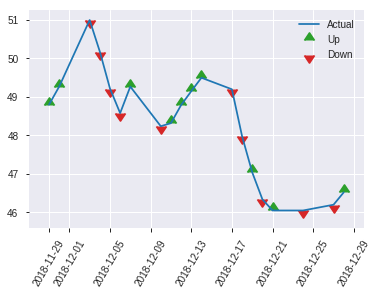


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2165099858451259
RMSE: 0.46530633548784384
LogLoss: 0.6213872507616198
Mean Per-Class Error: 0.31087094723458364
AUC: 0.7221233312142403
pr_auc: 0.695553788451162
Gini: 0.44424666242848065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31753823161125183: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   70   0.5785   (70.0/121.0)
1      13   117  0.1      (13.0/130.0)
Total  64   187  0.3307   (83.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317538     0.73817   186
max f2                       0.169712     0.85639   238
max f0point5                 0.472245     0.700935  127
max accuracy                 0.472245     0.689243  127
max precision                0.86035      1         0
max recall                   0.169712     1         238
max specificity              0.86035      1         0
max absolute_mcc             0.472245     0.37809   127
max min_per_class_accuracy   0.472245     0.68595   127
max mean_per_class_accuracy  0.472245     0.689129  127

Gains/Lift Table: Avg response rate: 51.79 %, avg score: 45.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.802513           1.28718   1.28718            0.666667         0.83006   0.666667                    0.83006             0.0153846       0.0153846                  28.7179   28.7179
    2        0.0239044                   0.7678             1.93077   1.60897            1                0.780422  0.833333                    0.805241            0.0230769       0.0384615                  93.0769   60.8974
    3        0.0318725                   0.734466           1.93077   1.68942            1                0.747966  0.875                       0.790923            0.0153846       0.0538462                  93.0769   68.9423
    4        0.0438247                   0.721486           1.93077   1.75524            1                0.724044  0.909091                    0.772683            0.0230769       0.0769231                  93.0769   75.5245
    5        0.0517928                   0.710242           0.965385  1.63373            0.5              0.712835  0.846154                    0.763476            0.00769231      0.0846154                  -3.46154  63.3728
    6        0.103586                    0.657578           1.18817   1.41095            0.615385         0.671343  0.730769                    0.717409            0.0615385       0.146154                   18.8166   41.0947
    7        0.151394                    0.634762           1.60897   1.47348            0.833333         0.646569  0.763158                    0.695039            0.0769231       0.223077                   60.8974   47.3482
    8        0.203187                    0.617477           1.63373   1.51433            0.846154         0.623168  0.784314                    0.676719            0.0846154       0.307692                   63.3728   51.4329
    9        0.302789                    0.567696           1.004     1.34646            0.52             0.585577  0.697368                    0.646738            0.1             0.407692                   0.4       34.6457
    10       0.40239                     0.519569           1.31292   1.33816            0.68             0.5433    0.693069                    0.621134            0.130769        0.538462                   31.2923   33.8157
    11       0.501992                    0.474106           1.39015   1.34847            0.72             0.496307  0.698413                    0.596367            0.138462        0.676923                   39.0154   34.8474
    12       0.601594                    0.421294           0.926769  1.27866            0.48             0.446575  0.662252                    0.571567            0.0923077       0.769231                   -7.32308  27.8655
    13       0.701195                    0.354137           0.772308  1.20673            0.4              0.380206  0.625                       0.544385            0.0769231       0.846154                   -22.7692  20.6731
    14       0.800797                    0.281956           0.772308  1.1527             0.4              0.314032  0.597015                    0.515734            0.0769231       0.923077                   -22.7692  15.2698
    15       0.900398                    0.23331            0.540615  1.08499            0.28             0.25398   0.561947                    0.486779            0.0538462       0.976923                   -45.9385  8.49898
    16       1                           0.116133           0.231692  1                  0.12             0.178762  0.517928                    0.4561           

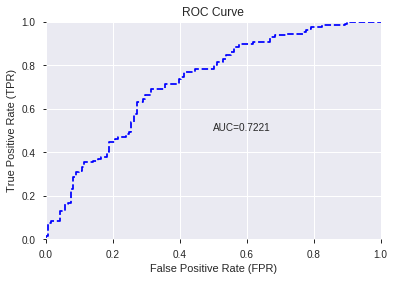

This function is available for GLM models only


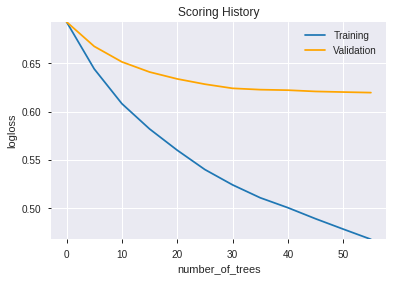

--2019-08-27 19:05:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.225.224
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.225.224|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_190501_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_190501_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a573',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_8',
 'BETA_8',
 'CORREL_8',
 'DX_14',
 'VAR_8',
 'CORREL_12',
 'MFI_12',
 'STOCH_slowk',
 'ATR_8',
 'BBANDS_upperband_14_2_5',
 'CCI_14',
 'ROC_20',
 'ADX_24',
 'ADXR_14',
 'MINUS_DI_20',
 'BBANDS_lowerband_30_2_5',
 'WILLR_14',
 'BBANDS_lowerband_14_4_4',
 'ATR_20',
 'MINUS_DI_8',
 'CDLCLOSINGMARUBOZU',
 'BETA_12',
 'PLUS_DM_14',
 'BBANDS_lowerband_24_6_3',
 'MACD_hist',
 'CCI_20',
 'MFI_24',
 'ADXR_8',
 'OBV',
 'MACD_signal',
 'BBANDS_lowerband_20_6_5',
 'LINEARREG_ANGLE_12',
 'CMO_20',
 'BBANDS_upperband_20_7_2',
 'ROCR_30',
 'aroonup_12',
 'CMO_8',
 'ROCR_14',
 'STOCHRSI_fastk',
 'RSI_12',
 'aroondown_20',
 'LINEARREG_ANGLE_8',
 'TRIX_14',
 'WILLR_30',
 'LINEARREG_8',
 'CDLLONGLINE',
 'MEDPRICE',
 'MACDFIX_signal_12',
 'ROCR_12',
 'ROCR100_14',
 'MOM_12',
 'DX_24',
 'ROCR_24',
 'MACDFIX_hist_12',
 'AROONOSC_12',
 'TYPPRICE',
 'WILLR_24',
 'aroondown_14',
 'ROCR_20',
 'CDLSPINNINGTOP',
 'ROCR100_24',
 'RSI_20']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.713
GLM             0.705
XGBoost         0.713
dtype: float64

DeepLearning    GLM  XGBoost
All          0.689  0.657    0.697
DLF          0.705  0.701    0.697
Fwe          0.713  0.705    0.713
RFE          0.681  0.689    0.689
XGBF         0.709  0.701    0.697





F1


DeepLearning    0.753
GLM             0.748
XGBoost         0.752
dtype: float64

DeepLearning    GLM  XGBoost
All          0.730  0.719    0.736
DLF          0.737  0.732    0.752
Fwe          0.753  0.748    0.751
RFE          0.732  0.738    0.738
XGBF         0.741  0.732    0.752





auc


DeepLearning    0.766
GLM             0.761
XGBoost         0.741
dtype: float64

DeepLearning    GLM  XGBoost
All          0.734  0.693    0.739
DLF          0.752  0.732    0.741
Fwe          0.766  0.761    0.740
RFE          0.728  0.734    0.722
XGBF         0.755  0.732    0.741





logloss


DeepLearning    0.634
GLM             0.642
XGBoost         0.621
dtype: float64

DeepLearning    GLM  XGBoost
All          0.634  0.642    0.608
DLF          0.588  0.605    0.598
Fwe          0.606  0.594    0.607
RFE          0.608  0.604    0.621
XGBF         0.598  0.605    0.598





mean_per_class_error


DeepLearning    0.322
GLM             0.344
XGBoost         0.311
dtype: float64

DeepLearning    GLM  XGBoost
All          0.307  0.344    0.303
DLF          0.293  0.301    0.308
Fwe          0.290  0.299    0.291
RFE          0.322  0.315    0.311
XGBF         0.292  0.301    0.308





rmse


DeepLearning    0.471
GLM             0.474
XGBoost         0.465
dtype: float64

DeepLearning    GLM  XGBoost
All          0.471  0.474    0.459
DLF          0.450  0.457    0.453
Fwe          0.456  0.452    0.457
RFE          0.459  0.458    0.465
XGBF         0.453  0.457    0.453





mse


DeepLearning    0.222
GLM             0.225
XGBoost         0.217
dtype: float64

DeepLearning    GLM  XGBoost
All          0.222  0.225    0.211
DLF          0.203  0.209    0.206
Fwe          0.208  0.204    0.209
RFE          0.211  0.209    0.217
XGBF         0.206  0.209    0.206

{'F1':       DeepLearning    GLM  XGBoost
 All          0.730    NaN      NaN
 DLF          0.737    NaN      NaN
 DLF            NaN  0.732      NaN
 DLF            NaN    NaN    0.752
 All            NaN  0.719      NaN
 All            NaN    NaN    0.736
 XGBF         0.741    NaN      NaN
 XGBF           NaN  0.732      NaN
 XGBF           NaN    NaN    0.752
 Fwe          0.753    NaN      NaN
 Fwe            NaN  0.748      NaN
 Fwe            NaN    NaN    0.751
 RFE          0.732    NaN      NaN
 RFE            NaN  0.738      NaN
 RFE            NaN    NaN    0.738,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.689    NaN      NaN
 DLF          0.705    NaN      NaN
 DLF            NaN  0.701      NaN
 DLF            NaN    NaN    0.697
 All            NaN  0.657      NaN
 All            NaN    NaN    0.697
 XGBF         0.709    NaN      NaN
 XGBF           NaN  0.701      NaN
 XGBF           NaN    NaN    0.697
 Fwe          0.713    NaN      NaN
 Fwe     